In [1]:
import time
import torch
import json
import random
import math
import warnings
import torchvision
import os
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torchvision.models as models

from pathlib import Path
from datetime import datetime
from tqdm import tqdm
from PIL import Image
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances_argmin_min, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, StratifiedKFold
from torch.utils.data import Subset, Dataset, DataLoader
from torchvision.models import EfficientNet
from torchvision.datasets import ImageFolder

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
# Hyperparameters
learning_rate = 0.0005 # 0.096779
epochs = 200
epochs_pretrain = 3
epochs_optimal_lr = 3
patience = 6
momentum = 0.9
step_size = 30
gamma = 0.1
batch_size = 64
num_workers = 4

# list of lambda values to loop through for grid search
epsilon = 0.05
margin = 0.01
lambda_factor_list = [0,50,150,200,100]

# labels used including for plotting
class_labels = [0, 1, 3, 4, 6, 7, 11, 15, 17, 18, 19, 20, 22, 25, 27, 28, 30, 31, 33, 35, 36, 37, 39, 43, 44, 50, 51, 54, 57, 58]
class_labels_new = torch.tensor([i for i in range(len(class_labels))])
num_classes = 16
class_names_new = [f"Class {label}" for label in range(num_classes)]


In [3]:
# set device to cuda if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Check if CUDA is available
cuda_available = torch.cuda.is_available()

# Count the number of GPUs available
num_gpus = torch.cuda.device_count()

print("CUDA Available:", cuda_available)
print("Number of GPUs:", num_gpus)

torch.cuda.empty_cache()

CUDA Available: True
Number of GPUs: 1


In [4]:
# Assuming your JSON file is named 'your_file.json'
file_path = './WIDER/Annotations/wider_attribute_trainval.json'

with open(file_path, 'r') as file:
    # Load the JSON data from the file
    data = json.load(file)

class_idx = data['scene_id_map']

In [5]:
new_label_mapping = {
    0: "Team_Sports",
    1: "Celebration",
    2: "Parade",
    3: "Waiter_Or_Waitress",
    4: "Individual_Sports",
    5: "Surgeons",
    6: "Spa",
    7: "Law_Enforcement",
    8: "Business",
    9: "Dresses",
    10: "Water_Activities",
    11: "Picnic",
    12: "Rescue",
    13: "Cheering",
    14: "Performance_And_Entertainment",
    15: "Family"
}

# Ensure that all 16 new classes are covered
# If some classes are not explicitly mentioned in new_label_mapping, add them
for i in range(num_classes):
    if i not in new_label_mapping:
        new_label_mapping[i] = "Additional Category {}".format(i)

class_idx = new_label_mapping

In [6]:
class DataSet(Dataset):
    def __init__(self, ann_files, augs, img_size, dataset):

        # Create a mapping from old labels to new labels
        self.label_mapping = {old_label: new_label for new_label, old_label in enumerate(sorted(class_labels))}

        self.new_label_mapping = {
            0: 2,  # Parade
            1: 8,  # Business
            2: 7,  # Law Enforcement
            3: 14,  # Performance and Entertainment
            4: 1,  # Celebration
            5: 13,  # Cheering
            6: 8,  # Business
            7: 8,  # Business
            8: 1,  # Celebration
            9: 14,  # Performance and Entertainment
            10: 15, # Family
            11: 15, # Family
            12: 11, # Picnic
            13: 7, # Law Enforcement
            14: 6, # Spa
            15: 13, # Cheering
            16: 5, # Surgeons
            17: 3, # Waiter or Waitress
            18: 4, # Individual Sports
            19: 0, # Team Sports
            20: 0, # Team Sports
            21: 0, # Team Sports
            22: 4, # Individual Sports
            23: 10, # Water Activities
            24: 4, # Individual Sports
            25: 1, # Celebration
            26: 9, # Dresses
            27: 12, # Rescue
            28: 10,# Water Activities
            29: 0  # Team Sports
        }

        self.dataset = dataset
        self.ann_files = ann_files
        self.augment = self.augs_function(augs, img_size)
        # Initialize transformations directly
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1])
            ] 
        )
        if self.dataset == "wider":
            self.transform = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])                ] 
            )        

        self.anns = []
        self.load_anns()
        print(self.augment)

    def augs_function(self, augs, img_size):            
        t = []
        if 'randomflip' in augs:
            t.append(transforms.RandomHorizontalFlip())
        if 'ColorJitter' in augs:
            t.append(transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0))
        if 'resizedcrop' in augs:
            t.append(transforms.RandomResizedCrop(img_size, scale=(0.7, 1.0)))
        if 'RandAugment' in augs:
            t.append(transforms.RandAugment())

        t.append(transforms.Resize((img_size, img_size)))

        return transforms.Compose(t)
    
    def load_anns(self):
        self.anns = []
        for ann_file in self.ann_files:
            json_data = json.load(open(ann_file, "r"))
            self.anns += json_data

    def __len__(self):
        return len(self.anns)

    def __getitem__(self, idx):
        # Make sure the index is within bounds
        idx = idx % len(self)
        ann = self.anns[idx]
        
        try:
            # Attempt to open the image file
            img = Image.open(f'WIDER/Image/{ann["file_name"]}').convert("RGB")

            # If this is the wider dataset, proceed with specific processing
            # x, y, w, h = ann['bbox']
            # img_area = img.crop([x, y, x+w, y+h])
            img_area = self.augment(img)
            img_area = self.transform(img_area)
            attributes_list = [target['attribute'] for target in ann['targets']]
            num_people = len(attributes_list)
            attributes_distribution = [max(sum(attribute), 0)/num_people for attribute in zip(*attributes_list)]
            # Extract label from image path
            img_path = f'WIDER/Image/{ann["file_name"]}'
            label = self.extract_label(img_path)  # You might need to implement this method
            
            return {
                "label": label,
                "target": torch.tensor([attributes_distribution[0]], dtype=torch.float32),
                "img": img_area
            }
            
        except Exception as e:
            # If any error occurs during the processing of an image, log the error and the index
            print(f"Error processing image at index {idx}: {e}")
            # Instead of returning None, raise the exception
            raise

    def extract_label(self, img_path):
        original_label = None
    
        if "WIDER/Image/train" in img_path:
            label_str = img_path.split("WIDER/Image/train/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
        elif "WIDER/Image/test" in img_path:
            label_str = img_path.split("WIDER/Image/test/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
        elif "WIDER/Image/val" in img_path:  # Handle validation images
            label_str = img_path.split("WIDER/Image/val/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
    
        if original_label is not None:
            remapped_label = self.label_mapping[original_label]
            new_label_mapping = self.new_label_mapping[remapped_label]
            return new_label_mapping
        else:
            raise ValueError(f"Label could not be extracted from path: {img_path}")


In [7]:
train_file = ['data/wider/trainval_wider.json']
test_file = ['data/wider/test_wider.json']


In [8]:
def custom_collate(batch):
    # Filter out any None items in the batch
    batch = [item for item in batch if item is not None]
    # If after filtering the batch is empty, handle this case by either returning an empty tensor or raising an exception
    if len(batch) == 0:
        raise ValueError("Batch is empty after filtering out None items.")
    return torch.utils.data.dataloader.default_collate(batch)


In [9]:
# train_dataset = DataSet(train_file, augs = ['RandAugment'], img_size = 226, dataset = 'wider')
train_dataset = DataSet(train_file, augs = [], img_size = 226, dataset = 'wider')
test_dataset = DataSet(test_file, augs = [], img_size = 226, dataset = 'wider')

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                         num_workers=num_workers, collate_fn=custom_collate)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=custom_collate)


Compose(
    Resize(size=(226, 226), interpolation=bilinear, max_size=None, antialias=warn)
)
Compose(
    Resize(size=(226, 226), interpolation=bilinear, max_size=None, antialias=warn)
)


In [11]:
def one_hot_encode(labels, num_classes):
    return np.eye(num_classes)[labels]

def calculate_recall_multiclass(conf_matrix):
    recalls = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
    recalls[np.isnan(recalls)] = 0  # Replace NaN with 0
    return recalls

def evaluate_model_with_gender_multiclass(pred, label, gender, num_classes):
    predictions = pred.cpu()
    true_labels = label.cpu()
    gender = gender.cpu()

    # Identify male and female indices based on the gender threshold
    male_indices = np.where(gender >= 0.5)[0]
    female_indices = np.where(gender < 0.5)[0]

    # Convert labels to one-hot encoding
    one_hot_labels = one_hot_encode(true_labels, num_classes=num_classes)
    one_hot_preds = one_hot_encode(predictions, num_classes=num_classes)

    # Initialize recall arrays
    male_recall = np.zeros(num_classes)
    female_recall = np.zeros(num_classes)

    # Extract predictions and labels for male and female indices
    male_predictions = np.argmax(one_hot_preds[male_indices], axis=1)
    female_predictions = np.argmax(one_hot_preds[female_indices], axis=1)
    male_labels = np.argmax(one_hot_labels[male_indices], axis=1)
    female_labels = np.argmax(one_hot_labels[female_indices], axis=1)

    # Check if the class labels are within the expected range
    assert (0 <= male_predictions.min() < num_classes) and (0 <= male_predictions.max() < num_classes), "Invalid class indices in male predictions"
    assert (0 <= female_predictions.min() < num_classes) and (0 <= female_predictions.max() < num_classes), "Invalid class indices in female predictions"
    assert (0 <= male_labels.min() < num_classes) and (0 <= male_labels.max() < num_classes), "Invalid class indices in male labels"
    assert (0 <= female_labels.min() < num_classes) and (0 <= female_labels.max() < num_classes), "Invalid class indices in female labels"

    # Calculate confusion matrices for each gender
    male_conf_matrix = confusion_matrix(male_labels, male_predictions, labels=np.arange(num_classes))
    female_conf_matrix = confusion_matrix(female_labels, female_predictions, labels=np.arange(num_classes))

    # Calculate recall for each class and gender
    male_recall[:len(male_conf_matrix)] = calculate_recall_multiclass(male_conf_matrix)
    female_recall[:len(female_conf_matrix)] = calculate_recall_multiclass(female_conf_matrix)

    return male_recall - female_recall, male_conf_matrix, female_conf_matrix


In [12]:
class Critic(nn.Module):
    def __init__(self, input_size, hidden_size=256):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)  # Outputting a single value for bias

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x
        

In [13]:
def train_model(actor, actor_optimizer, actor_loss_fn, critic, critic_optimizer, critic_loss_fn,
               lambda_factor, epsilon, margin, patience, epochs, device, base_save_dir):
    train_accuracies = []
    train_disparities = []
    train_mean_non_zero_abs_disparities = []
    train_losses = []
    train_main_losses = []
    train_critic_losses = []
    val_accuracies = []
    val_disparities = []
    val_mean_non_zero_abs_disparities = []
    val_losses = []
    val_main_losses = []
    val_critic_losses = []
    
    patience_counter = 0 
    best_val_accuracy = 0
    best_val_loss = float('inf')
    best_val_mean_abs_disparity = 0
    best_model_state = None

    # Create a subdirectory for the current lambda_factor
    lambda_dir = os.path.join(base_save_dir, f'lambda_{lambda_factor}')
    os.makedirs(lambda_dir, exist_ok=True)
    
    # Training and Validation Loop
    for epoch in range(epochs):
        # Initialize metrics for each epoch
        epoch_train_disparities = []
        epoch_train_losses = []
        epoch_train_accuracies = []
        epoch_val_disparities = []
        epoch_val_losses = []
        epoch_val_accuracies = []
    
        confusion_male = np.zeros((num_classes, num_classes))
        confusion_female = np.zeros((num_classes, num_classes))
        total_correct = 0
        total_samples = 0
        total_val_loss = 0.0
        num_batches = 0
        
        # Training
        actor.train()
        for batch_data in tqdm(trainloader, desc=f'Epoch {epoch+1}/{epochs}, Training'):
            # Load data to device
            images = batch_data["img"].to(device)
            labels = batch_data["label"].to(device)
            gender_scores = batch_data["target"].to(device)
    
            # Forward pass through actor
            actor_output = actor(images)
            class_predictions = torch.argmax(actor_output, dim=1)
    
            # Compute bias
            total_samples += labels.size(0)
            total_correct += (class_predictions == labels).sum().item()
            num_batches += 1
            recall_diff = evaluate_model_with_gender_multiclass(class_predictions, labels, gender_scores, num_classes=num_classes)
            confusion_male += recall_diff[1]
            confusion_female += recall_diff[2]
            bias = np.mean(recall_diff[0])
            bias_mean = torch.tensor([bias], device=device, dtype=torch.float32)
    
            critic_optimizer.zero_grad()
            
            for param in critic.parameters():
                param.requires_grad = True
            for param in actor.parameters():
                param.requires_grad = False
                
            critic.train()
            actor.eval()
            
            critic_output = critic(actor_output)
            critic_loss = critic_loss_fn(critic_output, bias_mean)
            critic_loss.backward(retain_graph=True)
    
            critic_optimizer.step()
    
            for param in critic.parameters():
                param.requires_grad = False
            for param in actor.parameters():
                param.requires_grad = True
                
            actor.train()
            critic.eval()
    
            actor_optimizer.zero_grad()
    
            critic_output = critic(actor_output)
            main_loss = actor_loss_fn(actor_output, labels)
    
            combined_loss = max(1, lambda_factor * (abs(critic_output[0][0]) - epsilon + margin) + 1) * main_loss
    
            combined_loss.backward(retain_graph=True)
            actor_optimizer.step()
    
            # Calculate and accumulate metrics
            accuracy = (class_predictions == labels).float().mean().item()
            epoch_train_accuracies.append(accuracy)
            epoch_train_disparities.append(bias)
        
            # Record the losses
            epoch_train_losses.append((combined_loss.item(), main_loss.item(), critic_loss.item()))
    
        confusion_male /= num_batches
        confusion_female /= num_batches
    
        # Calculate training metrics for the epoch
        train_epoch_disparity = calculate_recall_multiclass(confusion_male) - calculate_recall_multiclass(confusion_female)
        train_non_zero_abs_values = np.abs(train_epoch_disparity[train_epoch_disparity != 0])
        
        # Store average training metrics for the epoch
        train_accuracy = np.mean(epoch_train_accuracies)
        train_disparity = np.mean(epoch_train_disparities)
        train_mean_non_zero_abs_disparity = np.mean(train_non_zero_abs_values)
        train_combined_loss = np.mean([x[0] for x in epoch_train_losses])
        train_main_loss = np.mean([x[1] for x in epoch_train_losses])
        train_critic_loss = np.mean([x[2] for x in epoch_train_losses])
    
        train_accuracies.append(train_accuracy)
        train_disparities.append(train_disparity)
        train_mean_non_zero_abs_disparities.append(train_mean_non_zero_abs_disparity)
        train_losses.append(train_combined_loss)
        train_main_losses.append(train_main_loss)
        train_critic_losses.append(train_critic_loss)
    
        # Validation Phase
        confusion_male = np.zeros((num_classes, num_classes))
        confusion_female = np.zeros((num_classes, num_classes))
        total_correct = 0
        total_samples = 0
        num_batches = 0
        
        actor.eval()
        with torch.no_grad():
            for batch_data in tqdm(testloader, desc=f'Epoch {epoch+1}/{epochs}, Validation'):
                # Load data to device
                images = batch_data["img"].to(device)
                labels = batch_data["label"].to(device)
                gender_scores = batch_data["target"].to(device)
        
                # Forward pass
                actor_output = actor(images)
                val_critic_output = critic(actor_output)
                class_predictions = torch.argmax(actor_output, dim=1)
        
                # Calculate and accumulate validation metrics
                accuracy = (class_predictions == labels).float().mean().item()
    
                # Compute bias
                num_batches += 1
                recall_diff = evaluate_model_with_gender_multiclass(class_predictions, labels, gender_scores, num_classes=num_classes)
                confusion_male += recall_diff[1]
                confusion_female += recall_diff[2]
                
                # Calculate validation losses (similar to training losses)
                batch_bias = np.mean(recall_diff[0])
                mean_batch_bias = torch.tensor([batch_bias], device=device, dtype=torch.float32)
                val_main_loss = actor_loss_fn(actor_output, labels)
                val_critic_loss = critic_loss_fn(val_critic_output, mean_batch_bias)
        
                val_combined_loss = max(1, lambda_factor * (abs(val_critic_output[0][0]) - epsilon + margin) + 1) * val_main_loss
    
                epoch_val_accuracies.append(accuracy)
                epoch_val_losses.append((val_combined_loss.item(), val_main_loss.item(), val_critic_loss.item()))
                
            confusion_male /= num_batches
            confusion_female /= num_batches
    
            val_epoch_disparity = calculate_recall_multiclass(confusion_male) - calculate_recall_multiclass(confusion_female)
            val_non_zero_abs_values = np.abs(val_epoch_disparity[val_epoch_disparity != 0])
    
            # Store average training metrics for the epoch
            val_accuracy = np.mean(epoch_val_accuracies)
            val_disparity = np.mean(epoch_val_disparities)
            val_mean_non_zero_abs_disparity = np.mean(val_non_zero_abs_values)
            val_combined_loss = np.mean([x[0] for x in epoch_val_losses])
            val_main_loss = np.mean([x[1] for x in epoch_val_losses])
            val_critic_loss = np.mean([x[2] for x in epoch_val_losses])
        
            val_accuracies.append(val_accuracy)
            val_disparities.append(val_disparity)
            val_mean_non_zero_abs_disparities.append(val_mean_non_zero_abs_disparity)
            val_losses.append(val_combined_loss)
            val_main_losses.append(val_main_loss)
            val_critic_losses.append(val_critic_loss)

            # Check if current validation combined loss is lower than the best combined loss
        if val_combined_loss < best_val_loss:
            best_val_loss = val_combined_loss
            best_val_accuracy = val_accuracy
            best_val_mean_non_zero_abs_disparity = val_mean_non_zero_abs_disparity
        
            # Create a mapping of class recall disparities
            class_recall_mapping = {class_name: val_epoch_disparity[int(class_label)] for class_label, class_name in class_idx.items()}
        
            best_model_state = {
                'epoch': epoch,
                'actor_state_dict': actor.state_dict(),
                'critic_state_dict': critic.state_dict(),
                'optimizer_actor_state_dict': actor_optimizer.state_dict(),
                'optimizer_critic_state_dict': critic_optimizer.state_dict(),
                'best_val_loss': best_val_loss,
                'best_val_accuracy': best_val_accuracy,
                'best_val_mean_abs_disparity': best_val_mean_non_zero_abs_disparity,
                'class_recall_mapping': class_recall_mapping
            }
            save_path = os.path.join(lambda_dir, f'best_model_lambda_{lambda_factor}.pth')
            torch.save(best_model_state, save_path)
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

        print("\n" + "="*50)
        print(f"Lambda {lambda_factor} - Epoch {epoch + 1} Metrics:")
        print("-"*50)
        print(f"TRAINING Accuracy: {train_accuracy:.6f}, VALIDATION Accuracy: {val_accuracy:.4f}")
        print(f"TRAINING Disparity: {train_mean_non_zero_abs_disparity:.6f}, VALIDATION Disparity: {val_mean_non_zero_abs_disparity:.4f}")
        print(f"TRAINING Combined Loss: {train_combined_loss:.6f}, VALIDATION Combined Loss: {val_combined_loss:.4f}")
        print("-"*50 + "\n")
        # Print disparities by class label
        for class_label, recall_diff in class_recall_mapping.items():
            print(f"Class {class_label}: Val Disparity = {recall_diff}")
        print("="*50 + "\n")
      
        # Plotting
        plt.figure(figsize=(15, 10))
        
        # Plot Training and Validation Accuracy
        plt.subplot(2, 2, 1)
        plt.plot(train_accuracies, label='Training Accuracy')
        plt.plot(val_accuracies, label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        
        # Plot Training and Validation Disparity
        plt.subplot(2, 2, 2)
        plt.plot(train_mean_non_zero_abs_disparities, label='Training Mean Absolute Disparity')
        plt.plot(val_mean_non_zero_abs_disparities, label='Validation Mean Absolute Disparity')
        plt.title('Training and Validation Mean Absolute Disparity')
        plt.xlabel('Epoch')
        plt.ylabel('Mean Absolute Disparity')
        plt.legend()
        
        # Plot Training Loss Components, Including Combined Loss
        plt.subplot(2, 2, 3)
        plt.plot(train_losses, label='Training Combined Loss')
        plt.plot(train_main_losses, label='Training Main Loss')
        plt.plot(train_critic_losses, label='Training Critic Loss')
        plt.title('Training Loss Components')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
    
        # Plot Validation Loss Components, Including Combined Loss
        plt.subplot(2, 2, 4)
        plt.plot(val_losses, label='Validation Combined Loss')
        plt.plot(val_main_losses, label='Validation Main Loss')
        plt.plot(val_critic_losses, label='Validation Critic Loss')
        plt.title('Validation Loss Components')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
            
        plt.tight_layout()
        plt.show()

    best_epoch = best_model_state['epoch'] + 1 if best_model_state else epochs
    print(f"Finished Training with lambda value of {lambda_factor}. Best (stopping) epoch number: {best_epoch}")

    return best_model_state

Epoch 1/200, Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.31it/s]



Lambda 0 - Epoch 1 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.511960, VALIDATION Accuracy: 0.6049
TRAINING Disparity: 0.103926, VALIDATION Disparity: 0.1259
TRAINING Combined Loss: 1.606160, VALIDATION Combined Loss: 1.2551
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.039014749060332976
Class Celebration: Val Disparity = 0.03524752475247517
Class Parade: Val Disparity = 0.023674242424242653
Class Waiter_Or_Waitress: Val Disparity = -0.050782741504390994
Class Individual_Sports: Val Disparity = -0.13346598002496868
Class Surgeons: Val Disparity = -0.033998521803399795
Class Spa: Val Disparity = -0.22916666666666674
Class Law_Enforcement: Val Disparity = 0.16830985915492958
Class Business: Val Disparity = -0.049930799531566095
Class Dresses: Val Disparity = -0.5219560878243513
Class Water_Activities: Val Disparity = 0.03299978709814777
Class Picnic: Val Disparity = -0.36601307189542487
Class Rescue: Val Di

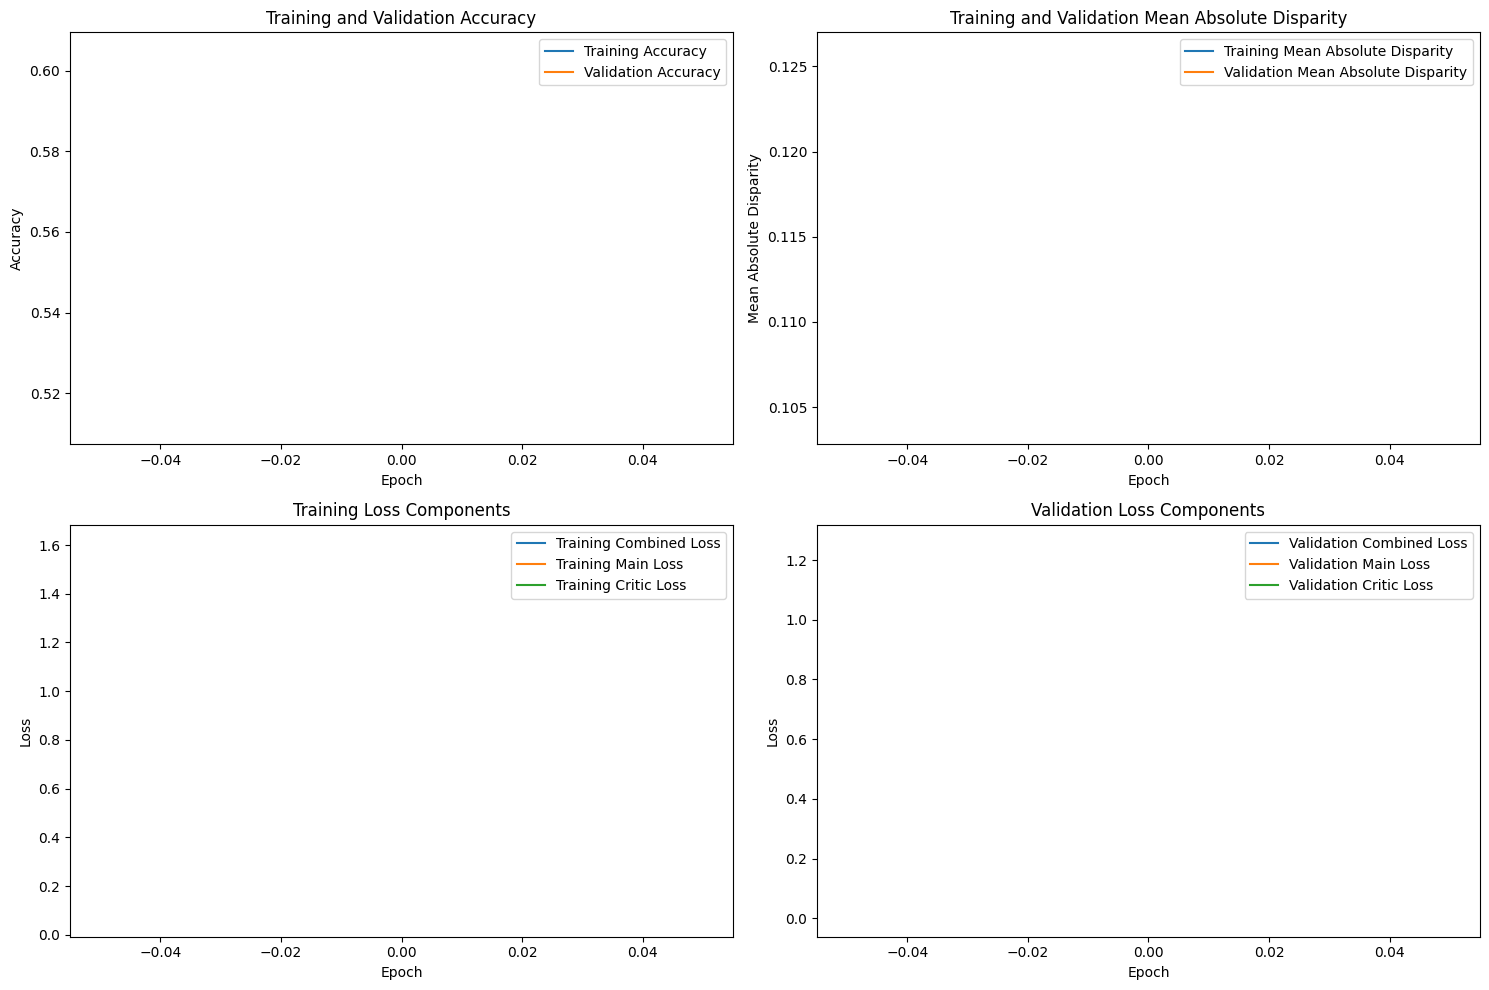

Epoch 2/200, Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.31it/s]



Lambda 0 - Epoch 2 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.697840, VALIDATION Accuracy: 0.6365
TRAINING Disparity: 0.124191, VALIDATION Disparity: 0.1639
TRAINING Combined Loss: 0.981383, VALIDATION Combined Loss: 1.2141
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.05767099656121821
Class Celebration: Val Disparity = -0.09445544554455448
Class Parade: Val Disparity = 0.02556818181818188
Class Waiter_Or_Waitress: Val Disparity = -0.03856433753340982
Class Individual_Sports: Val Disparity = -0.17532771535580516
Class Surgeons: Val Disparity = 0.10643015521064308
Class Spa: Val Disparity = -0.27083333333333326
Class Law_Enforcement: Val Disparity = 0.08755868544600942
Class Business: Val Disparity = 0.09773235388054935
Class Dresses: Val Disparity = -0.7904191616766467
Class Water_Activities: Val Disparity = 0.03023206301894843
Class Picnic: Val Disparity = -0.3856209150326797
Class Rescue: Val Disparity

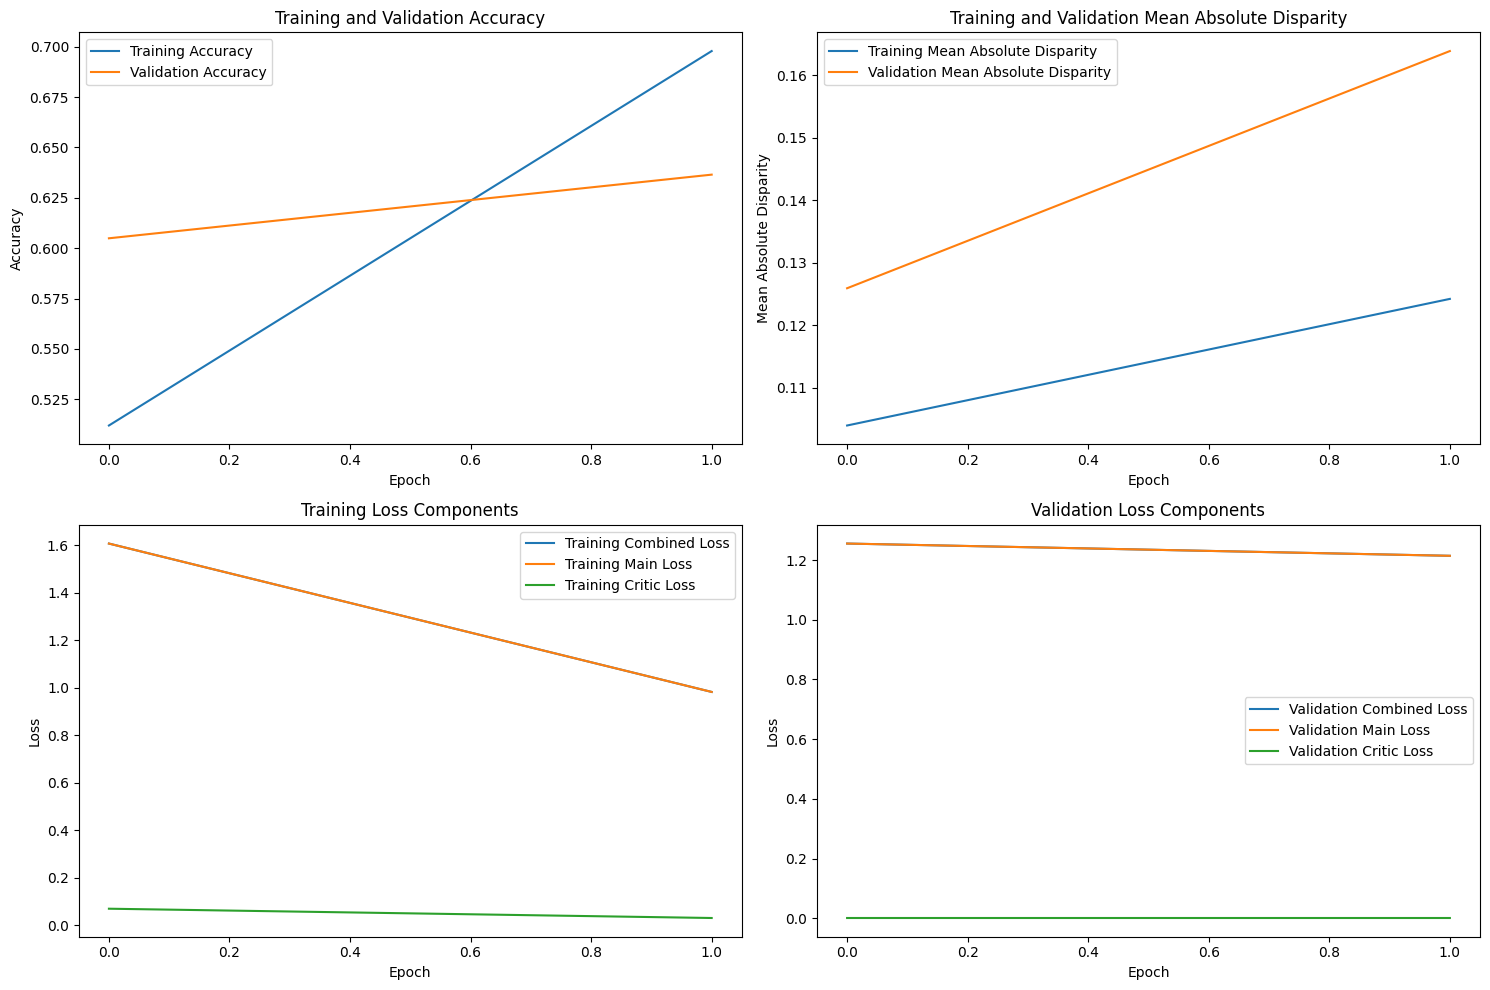

Epoch 3/200, Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.30it/s]



Lambda 0 - Epoch 3 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.808854, VALIDATION Accuracy: 0.6106
TRAINING Disparity: 0.098074, VALIDATION Disparity: 0.1383
TRAINING Combined Loss: 0.611236, VALIDATION Combined Loss: 1.4390
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.05767099656121821
Class Celebration: Val Disparity = -0.09445544554455448
Class Parade: Val Disparity = 0.02556818181818188
Class Waiter_Or_Waitress: Val Disparity = -0.03856433753340982
Class Individual_Sports: Val Disparity = -0.17532771535580516
Class Surgeons: Val Disparity = 0.10643015521064308
Class Spa: Val Disparity = -0.27083333333333326
Class Law_Enforcement: Val Disparity = 0.08755868544600942
Class Business: Val Disparity = 0.09773235388054935
Class Dresses: Val Disparity = -0.7904191616766467
Class Water_Activities: Val Disparity = 0.03023206301894843
Class Picnic: Val Disparity = -0.3856209150326797
Class Rescue: Val Disparity

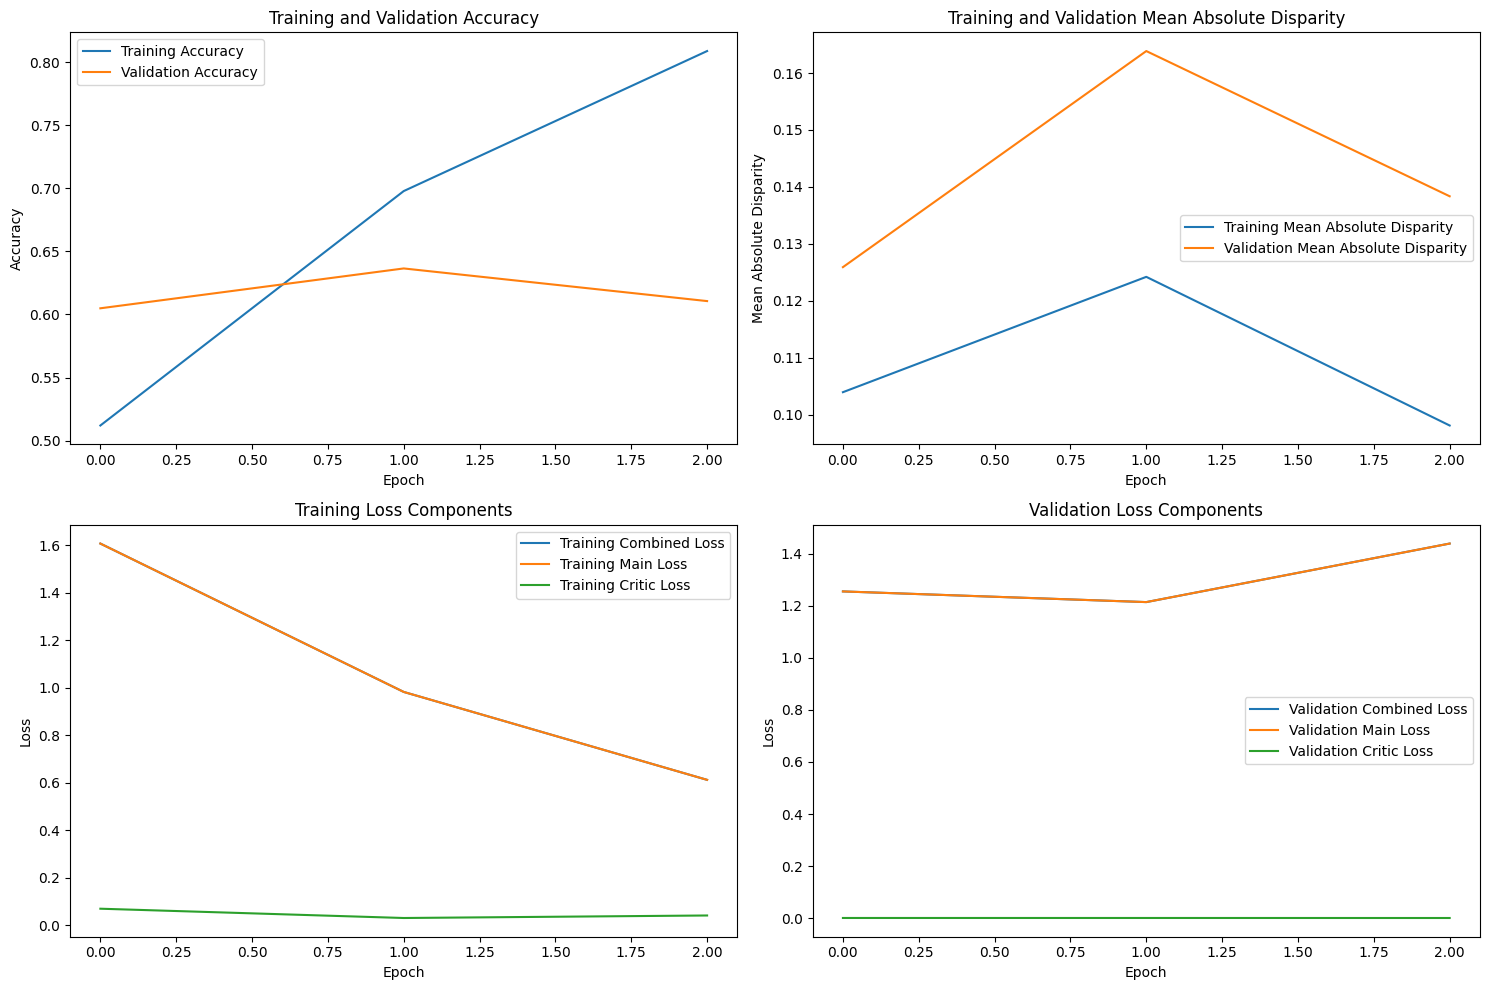

Epoch 4/200, Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.26it/s]



Lambda 0 - Epoch 4 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.876775, VALIDATION Accuracy: 0.6134
TRAINING Disparity: 0.056513, VALIDATION Disparity: 0.1456
TRAINING Combined Loss: 0.388871, VALIDATION Combined Loss: 1.4714
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.05767099656121821
Class Celebration: Val Disparity = -0.09445544554455448
Class Parade: Val Disparity = 0.02556818181818188
Class Waiter_Or_Waitress: Val Disparity = -0.03856433753340982
Class Individual_Sports: Val Disparity = -0.17532771535580516
Class Surgeons: Val Disparity = 0.10643015521064308
Class Spa: Val Disparity = -0.27083333333333326
Class Law_Enforcement: Val Disparity = 0.08755868544600942
Class Business: Val Disparity = 0.09773235388054935
Class Dresses: Val Disparity = -0.7904191616766467
Class Water_Activities: Val Disparity = 0.03023206301894843
Class Picnic: Val Disparity = -0.3856209150326797
Class Rescue: Val Disparity

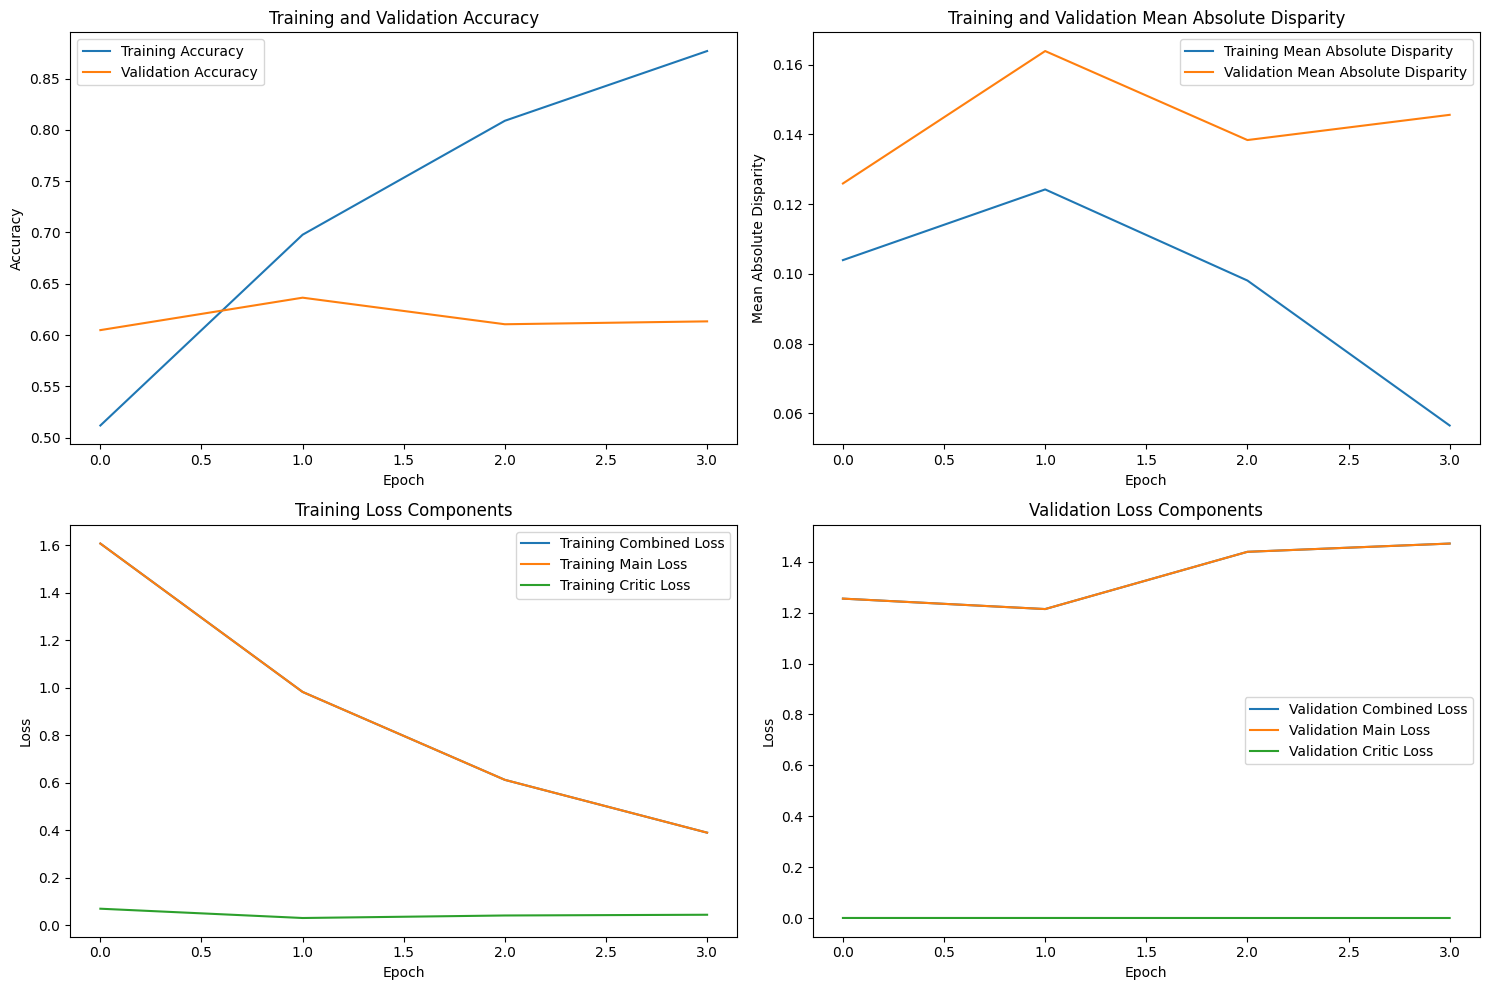

Epoch 5/200, Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.25it/s]



Lambda 0 - Epoch 5 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.916628, VALIDATION Accuracy: 0.6219
TRAINING Disparity: 0.036954, VALIDATION Disparity: 0.1384
TRAINING Combined Loss: 0.257636, VALIDATION Combined Loss: 1.7454
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.05767099656121821
Class Celebration: Val Disparity = -0.09445544554455448
Class Parade: Val Disparity = 0.02556818181818188
Class Waiter_Or_Waitress: Val Disparity = -0.03856433753340982
Class Individual_Sports: Val Disparity = -0.17532771535580516
Class Surgeons: Val Disparity = 0.10643015521064308
Class Spa: Val Disparity = -0.27083333333333326
Class Law_Enforcement: Val Disparity = 0.08755868544600942
Class Business: Val Disparity = 0.09773235388054935
Class Dresses: Val Disparity = -0.7904191616766467
Class Water_Activities: Val Disparity = 0.03023206301894843
Class Picnic: Val Disparity = -0.3856209150326797
Class Rescue: Val Disparity

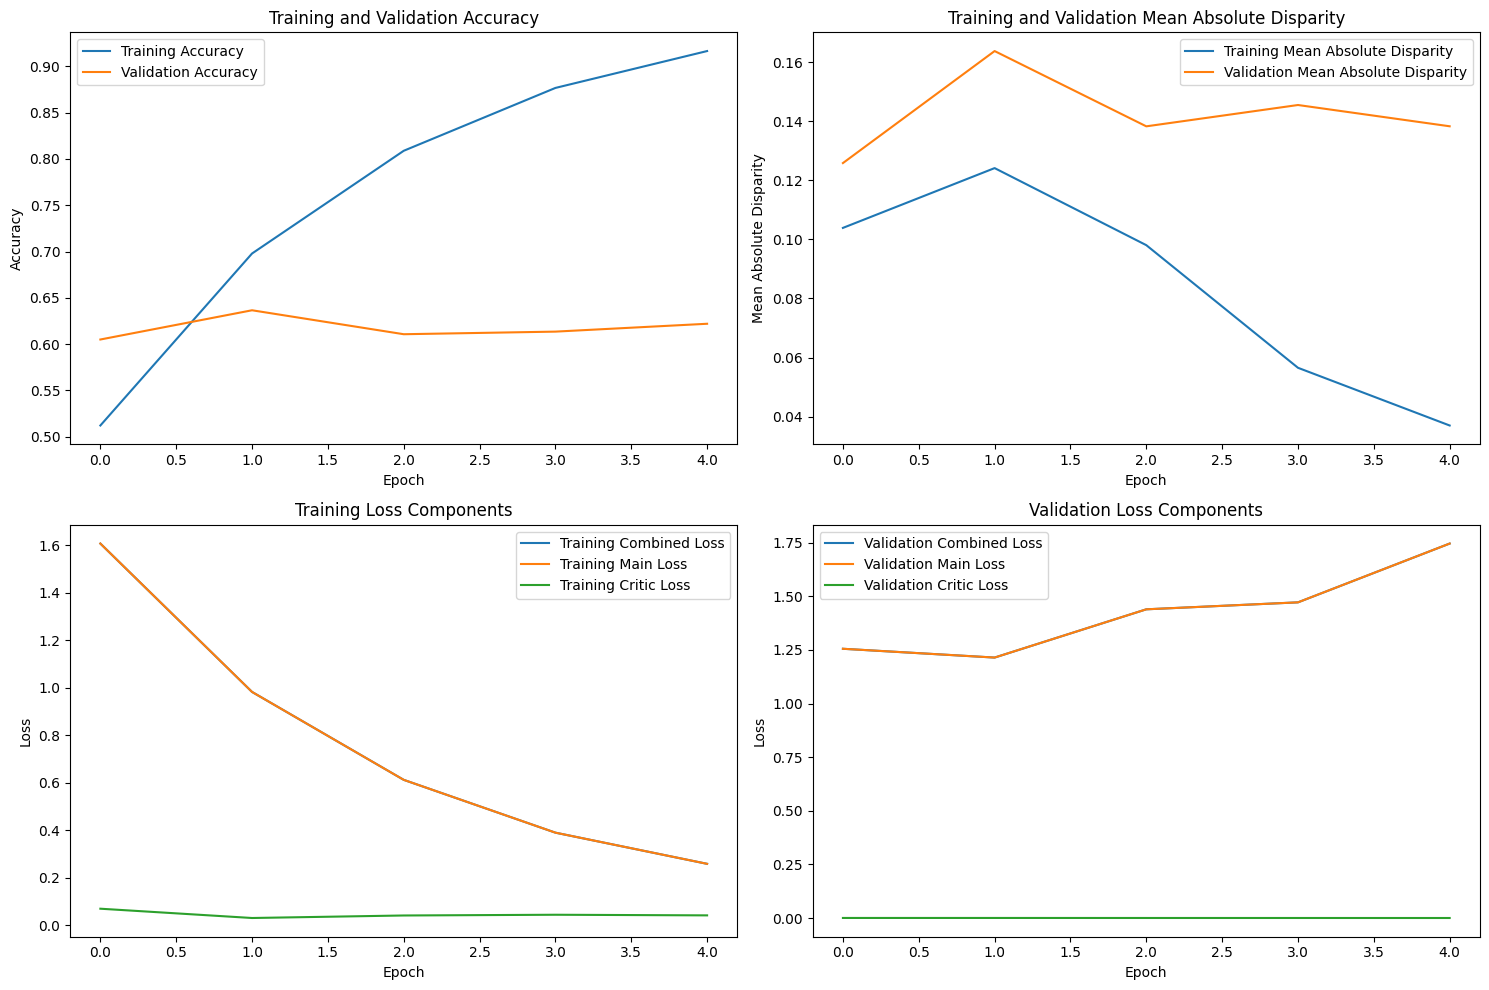

Epoch 6/200, Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.27it/s]



Lambda 0 - Epoch 6 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.934857, VALIDATION Accuracy: 0.6077
TRAINING Disparity: 0.024227, VALIDATION Disparity: 0.1665
TRAINING Combined Loss: 0.202549, VALIDATION Combined Loss: 1.8019
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.05767099656121821
Class Celebration: Val Disparity = -0.09445544554455448
Class Parade: Val Disparity = 0.02556818181818188
Class Waiter_Or_Waitress: Val Disparity = -0.03856433753340982
Class Individual_Sports: Val Disparity = -0.17532771535580516
Class Surgeons: Val Disparity = 0.10643015521064308
Class Spa: Val Disparity = -0.27083333333333326
Class Law_Enforcement: Val Disparity = 0.08755868544600942
Class Business: Val Disparity = 0.09773235388054935
Class Dresses: Val Disparity = -0.7904191616766467
Class Water_Activities: Val Disparity = 0.03023206301894843
Class Picnic: Val Disparity = -0.3856209150326797
Class Rescue: Val Disparity

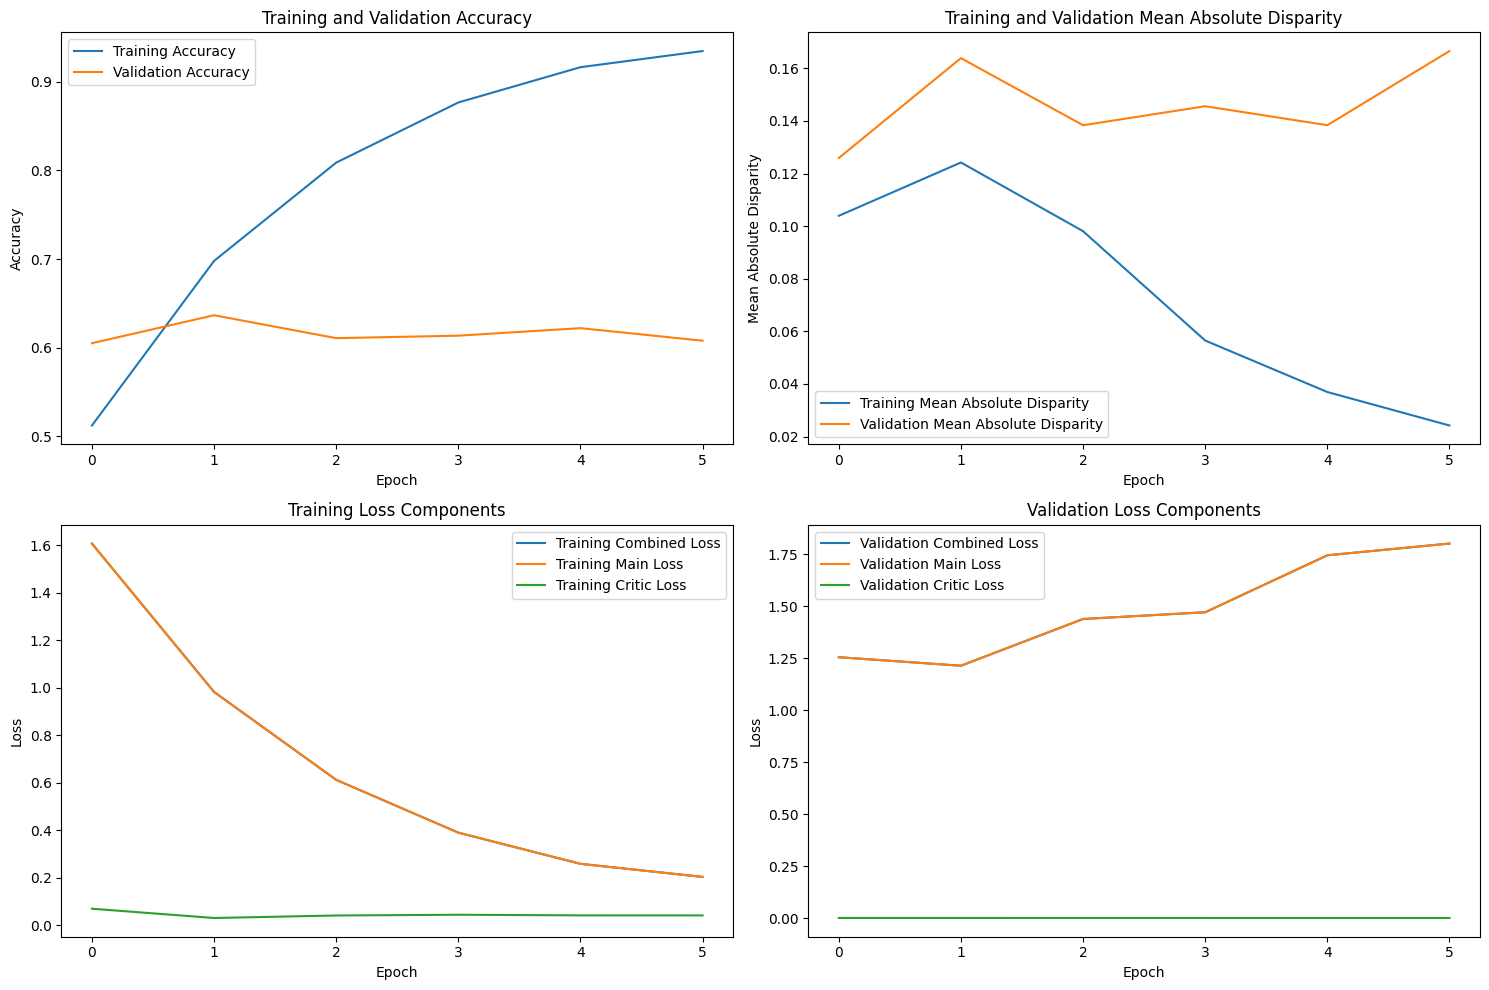

Epoch 7/200, Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.34it/s]



Lambda 0 - Epoch 7 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.945660, VALIDATION Accuracy: 0.6208
TRAINING Disparity: 0.044899, VALIDATION Disparity: 0.1394
TRAINING Combined Loss: 0.169644, VALIDATION Combined Loss: 1.7742
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.05767099656121821
Class Celebration: Val Disparity = -0.09445544554455448
Class Parade: Val Disparity = 0.02556818181818188
Class Waiter_Or_Waitress: Val Disparity = -0.03856433753340982
Class Individual_Sports: Val Disparity = -0.17532771535580516
Class Surgeons: Val Disparity = 0.10643015521064308
Class Spa: Val Disparity = -0.27083333333333326
Class Law_Enforcement: Val Disparity = 0.08755868544600942
Class Business: Val Disparity = 0.09773235388054935
Class Dresses: Val Disparity = -0.7904191616766467
Class Water_Activities: Val Disparity = 0.03023206301894843
Class Picnic: Val Disparity = -0.3856209150326797
Class Rescue: Val Disparity

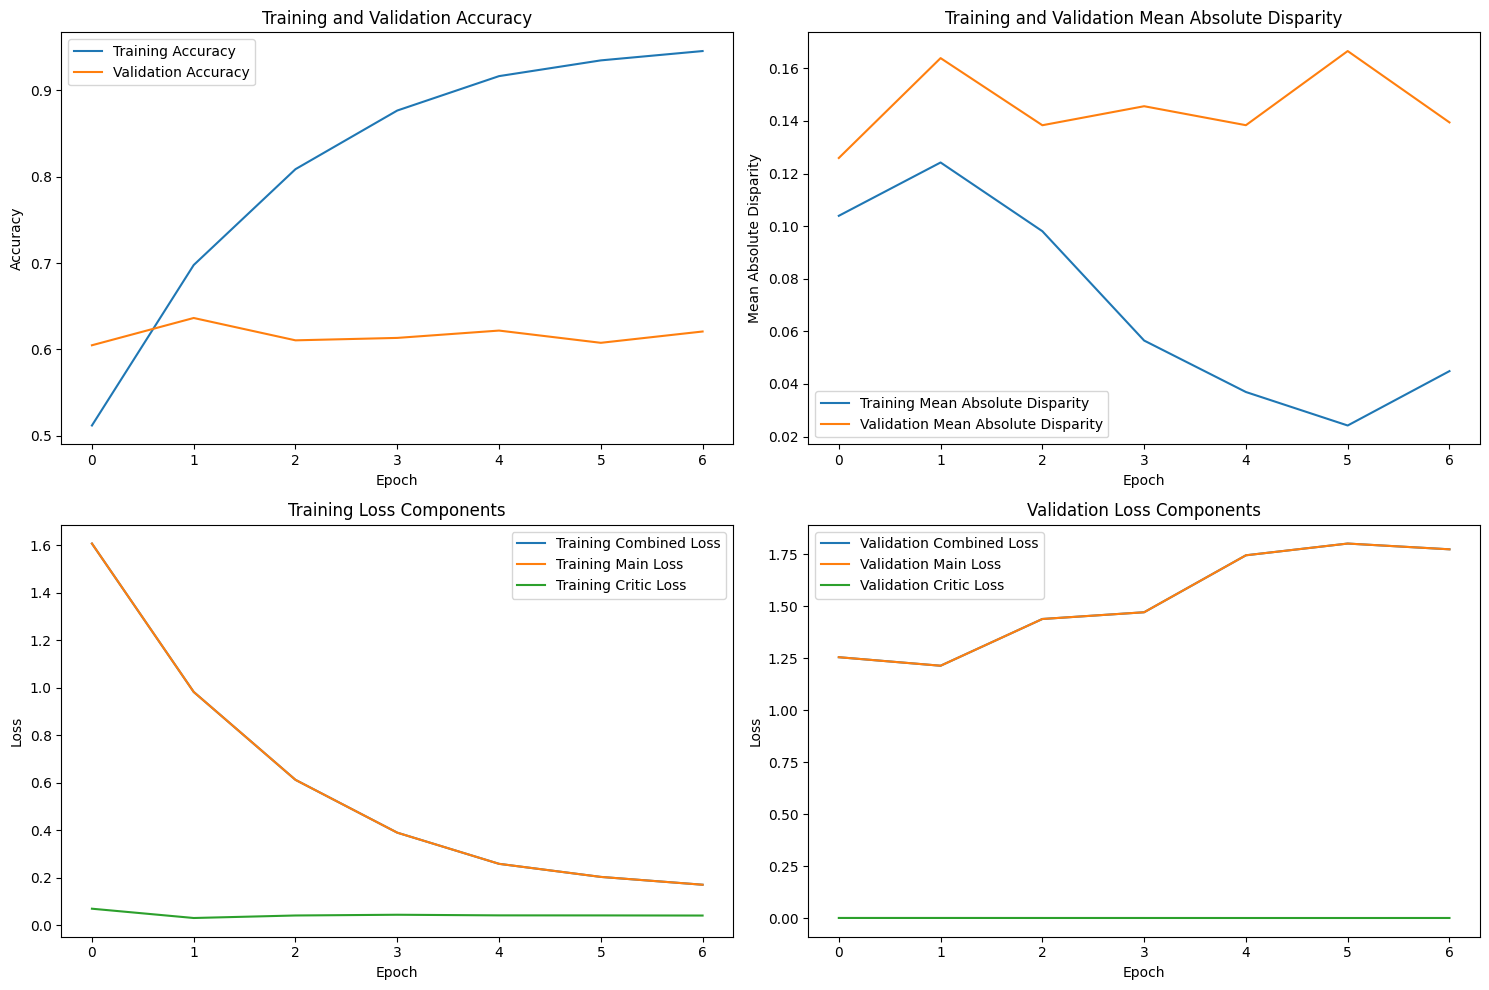

Epoch 8/200, Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.31it/s]


Early stopping triggered at epoch 8
Finished Training with lambda value of 0. Best (stopping) epoch number: 2


Epoch 1/200, Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.26it/s]



Lambda 50 - Epoch 1 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.285147, VALIDATION Accuracy: 0.2949
TRAINING Disparity: 0.025289, VALIDATION Disparity: 0.0656
TRAINING Combined Loss: 12.293409, VALIDATION Combined Loss: 2.8843
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.06789594543647393
Class Celebration: Val Disparity = -0.016584158415841627
Class Parade: Val Disparity = 0.04450757575757569
Class Waiter_Or_Waitress: Val Disparity = 0.0
Class Individual_Sports: Val Disparity = 0.13592384519350814
Class Surgeons: Val Disparity = 0.0
Class Spa: Val Disparity = 0.0
Class Law_Enforcement: Val Disparity = 0.06431924882629103
Class Business: Val Disparity = 0.0
Class Dresses: Val Disparity = -0.08982035928143713
Class Water_Activities: Val Disparity = -0.05365126676602078
Class Picnic: Val Disparity = 0.0
Class Rescue: Val Disparity = 0.0
Class Cheering: Val Disparity = 0.0
Class Performance_And_Entertainment

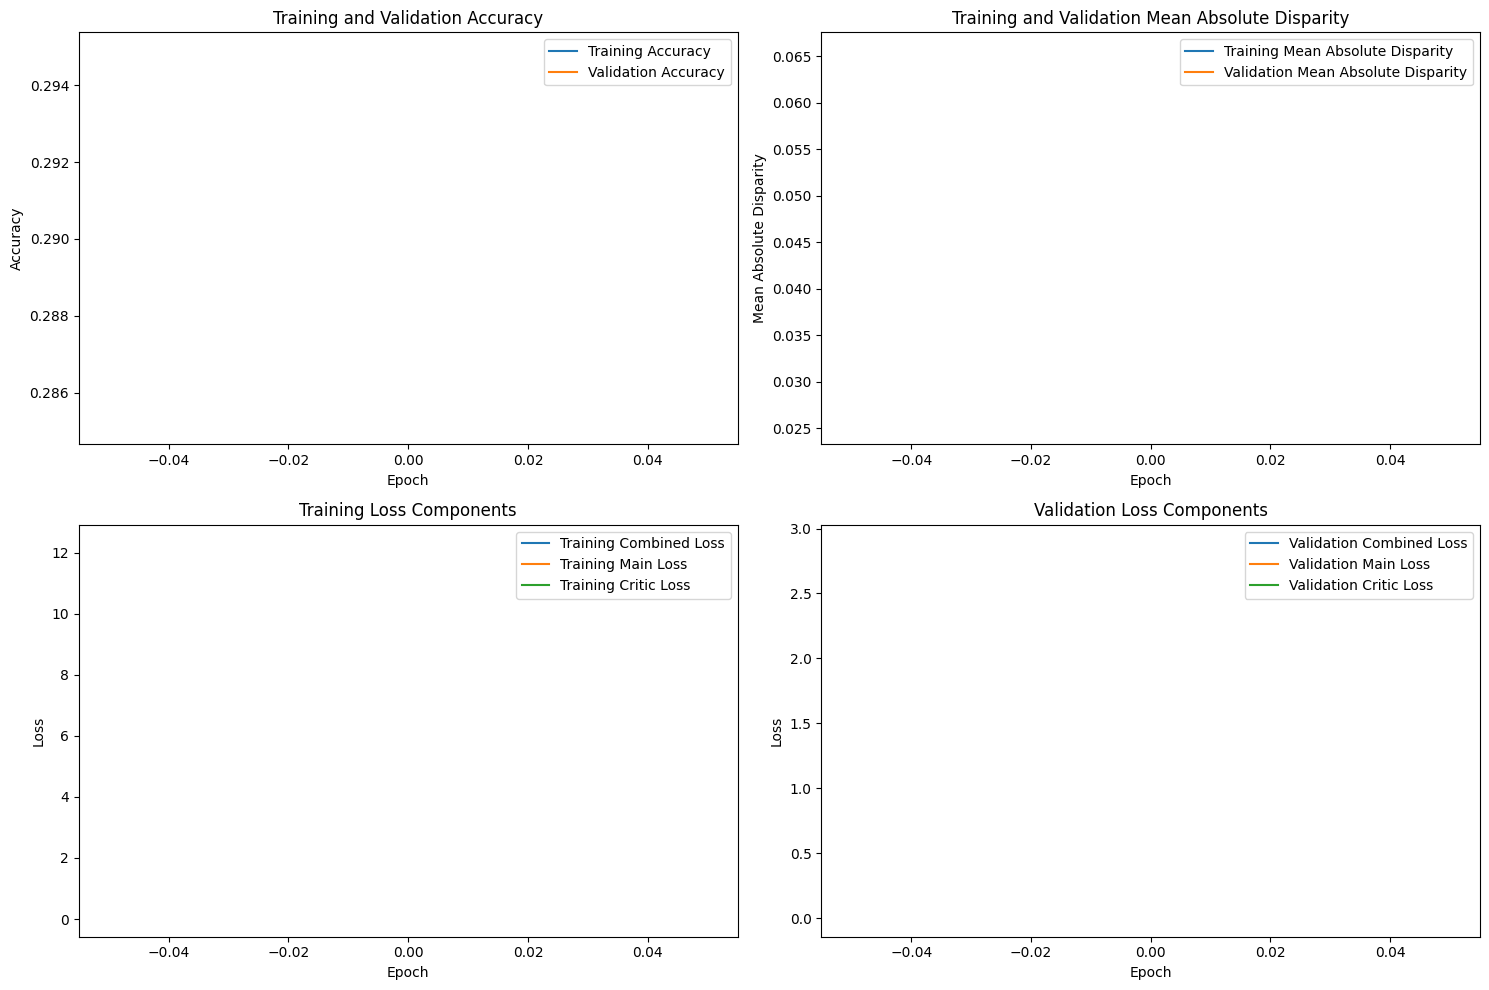

Epoch 2/200, Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.30it/s]



Lambda 50 - Epoch 2 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.312828, VALIDATION Accuracy: 0.3449
TRAINING Disparity: 0.045887, VALIDATION Disparity: 0.0669
TRAINING Combined Loss: 2.577180, VALIDATION Combined Loss: 2.4764
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.07917195050896264
Class Celebration: Val Disparity = 0.02193069306930695
Class Parade: Val Disparity = 0.024621212121212155
Class Waiter_Or_Waitress: Val Disparity = 0.0
Class Individual_Sports: Val Disparity = 0.06015917602996251
Class Surgeons: Val Disparity = 0.048780487804878044
Class Spa: Val Disparity = 0.0
Class Law_Enforcement: Val Disparity = 0.12065727699530521
Class Business: Val Disparity = 0.0
Class Dresses: Val Disparity = -0.1337325349301397
Class Water_Activities: Val Disparity = -0.09058973813072169
Class Picnic: Val Disparity = 0.0
Class Rescue: Val Disparity = 0.0
Class Cheering: Val Disparity = 0.0
Class Performance_And

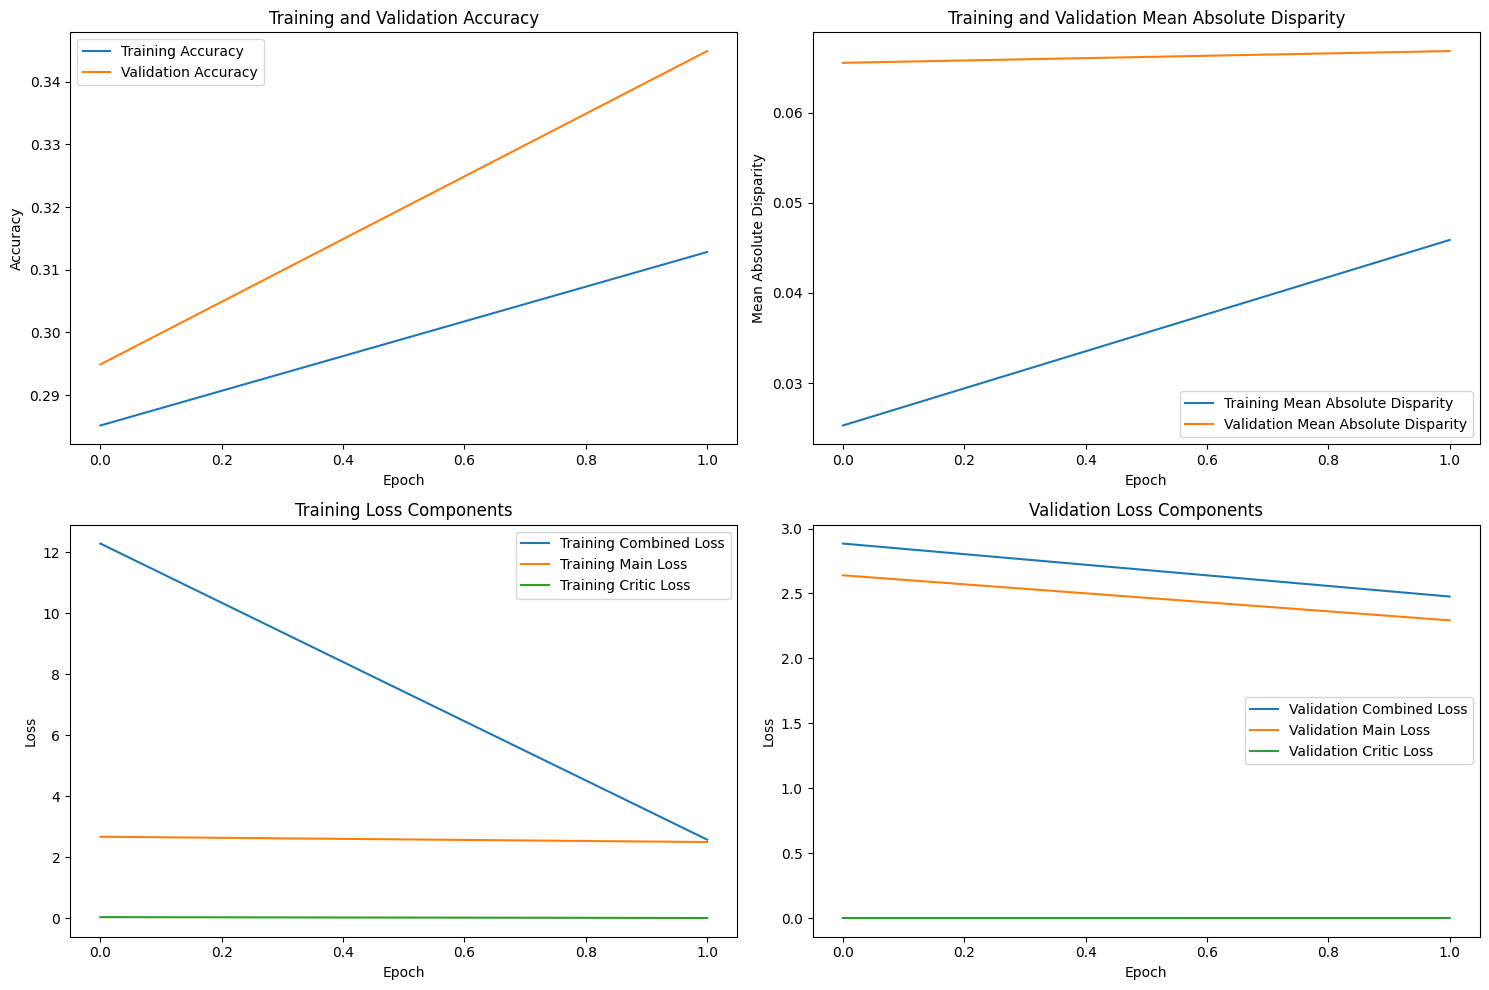

Epoch 3/200, Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.30it/s]



Lambda 50 - Epoch 3 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.371393, VALIDATION Accuracy: 0.3884
TRAINING Disparity: 0.078343, VALIDATION Disparity: 0.0938
TRAINING Combined Loss: 2.264831, VALIDATION Combined Loss: 2.0652
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.10017022540585618
Class Celebration: Val Disparity = 0.08173267326732672
Class Parade: Val Disparity = 0.019886363636363757
Class Waiter_Or_Waitress: Val Disparity = 0.0
Class Individual_Sports: Val Disparity = -0.002340823970037431
Class Surgeons: Val Disparity = 0.0
Class Spa: Val Disparity = 0.0
Class Law_Enforcement: Val Disparity = 0.12323943661971826
Class Business: Val Disparity = 0.0
Class Dresses: Val Disparity = -0.22954091816367278
Class Water_Activities: Val Disparity = -0.08856717053438357
Class Picnic: Val Disparity = 0.0
Class Rescue: Val Disparity = 0.024331550802139036
Class Cheering: Val Disparity = 0.0
Class Performance_

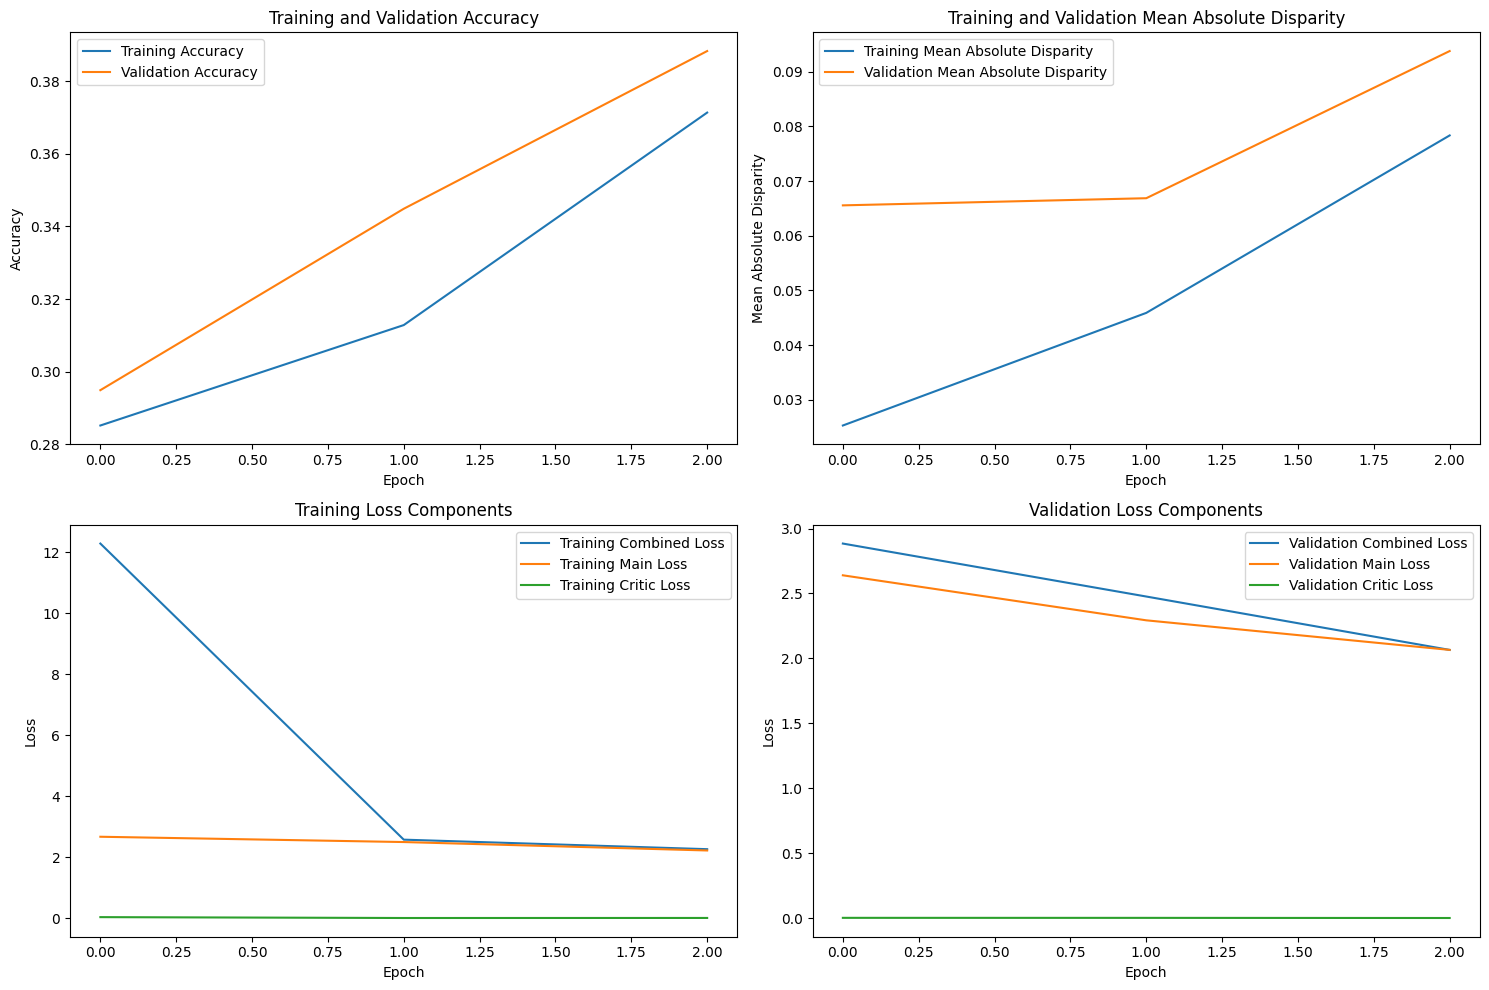

Epoch 4/200, Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.28it/s]



Lambda 50 - Epoch 4 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.407253, VALIDATION Accuracy: 0.4009
TRAINING Disparity: 0.074316, VALIDATION Disparity: 0.1060
TRAINING Combined Loss: 2.051945, VALIDATION Combined Loss: 2.0118
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.10002170659537757
Class Celebration: Val Disparity = -0.033564356435643594
Class Parade: Val Disparity = -0.017045454545454475
Class Waiter_Or_Waitress: Val Disparity = 0.0
Class Individual_Sports: Val Disparity = 0.059534956304619246
Class Surgeons: Val Disparity = -0.04212860310421286
Class Spa: Val Disparity = 0.0
Class Law_Enforcement: Val Disparity = 0.18779342723004688
Class Business: Val Disparity = 0.009049292025976787
Class Dresses: Val Disparity = -0.5389221556886228
Class Water_Activities: Val Disparity = -0.014796678731104906
Class Picnic: Val Disparity = 0.0
Class Rescue: Val Disparity = 0.0008021390374331541
Class Cheering: V

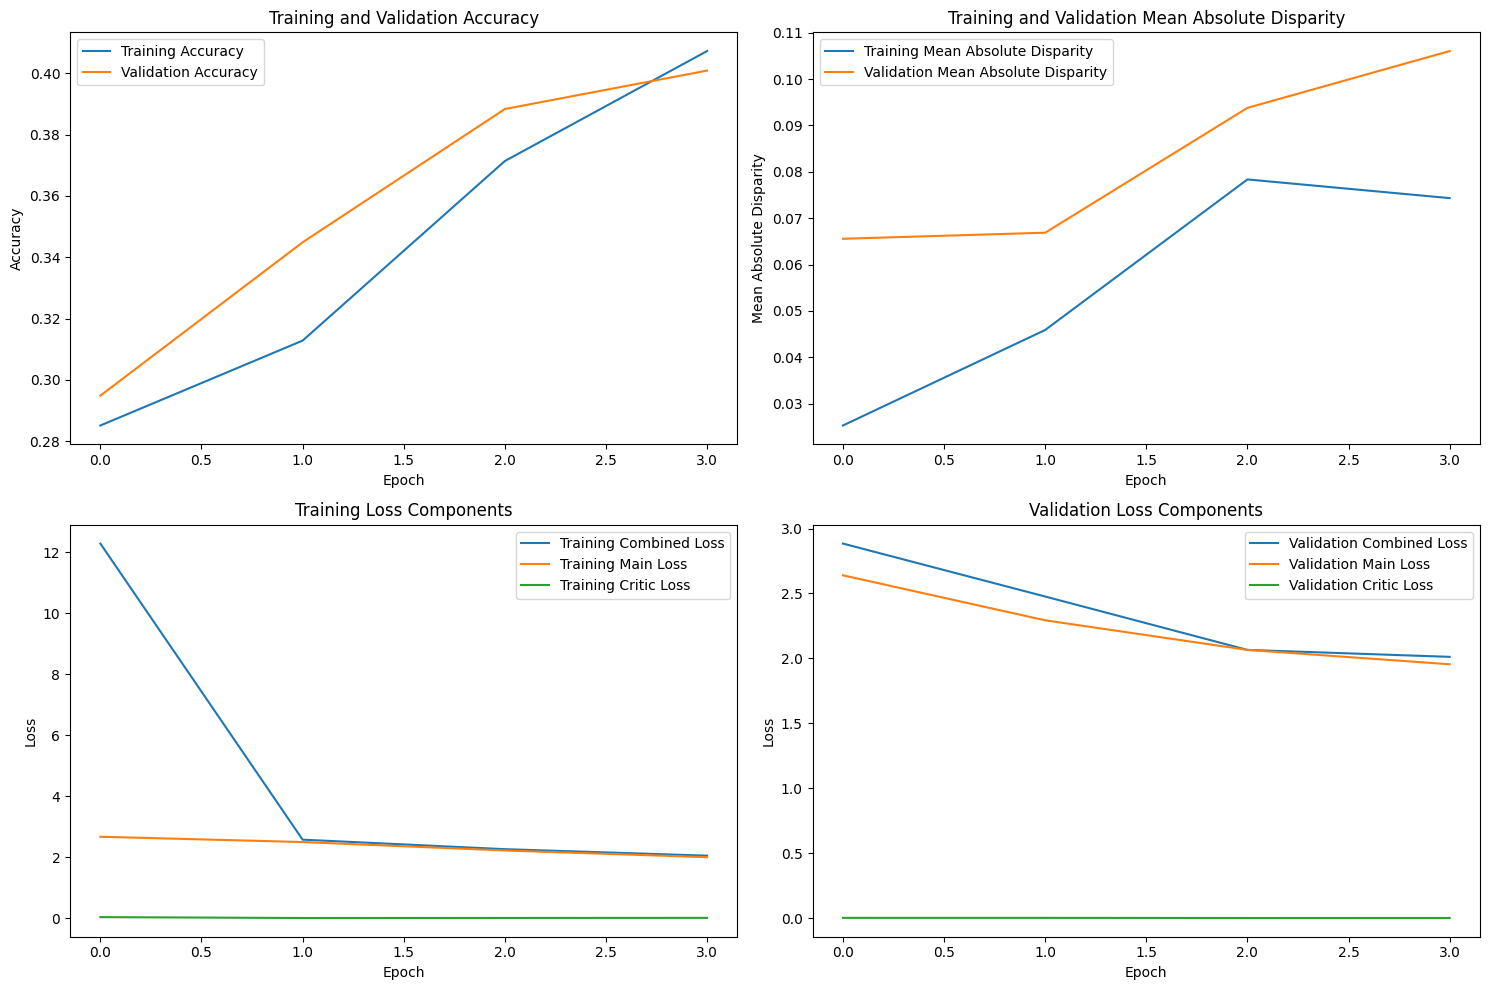

Epoch 5/200, Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.33it/s]



Lambda 50 - Epoch 5 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.420872, VALIDATION Accuracy: 0.4327
TRAINING Disparity: 0.074733, VALIDATION Disparity: 0.1194
TRAINING Combined Loss: 1.900828, VALIDATION Combined Loss: 1.8193
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.12156835863865378
Class Celebration: Val Disparity = 0.02643564356435646
Class Parade: Val Disparity = 0.030303030303030276
Class Waiter_Or_Waitress: Val Disparity = -0.08056510118365787
Class Individual_Sports: Val Disparity = -0.08711766541822719
Class Surgeons: Val Disparity = 0.08573540280857356
Class Spa: Val Disparity = 0.0
Class Law_Enforcement: Val Disparity = 0.20117370892018765
Class Business: Val Disparity = -0.12764824869583735
Class Dresses: Val Disparity = -0.6107784431137725
Class Water_Activities: Val Disparity = -0.004577389823291478
Class Picnic: Val Disparity = 0.0
Class Rescue: Val Disparity = -0.022727272727272724
Clas

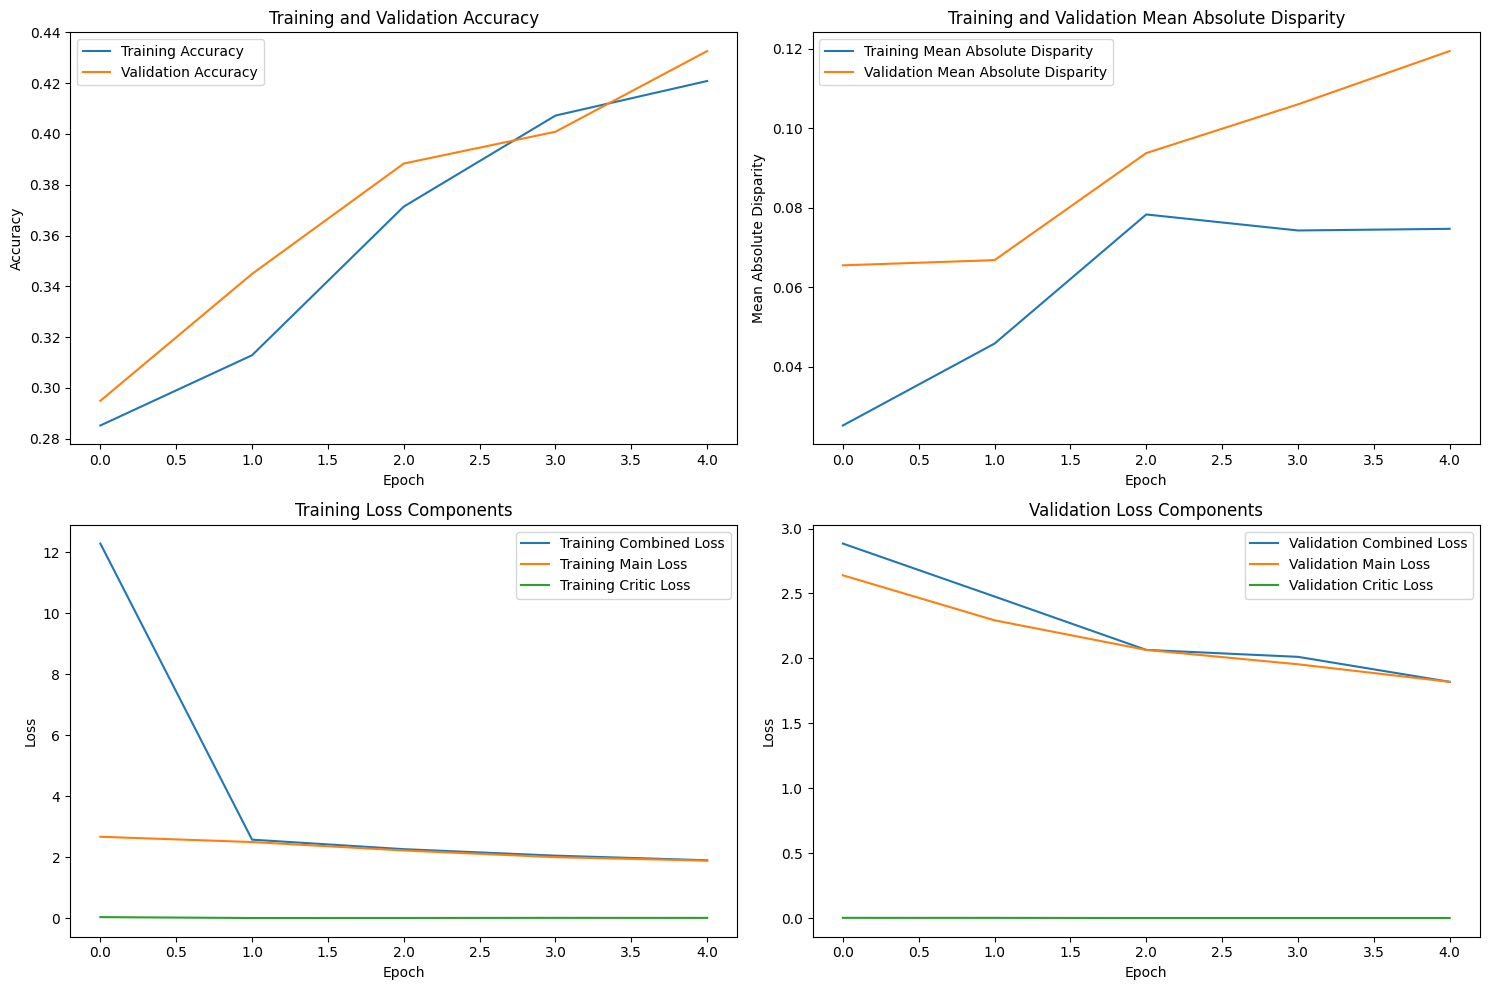

Epoch 6/200, Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.25it/s]



Lambda 50 - Epoch 6 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.478492, VALIDATION Accuracy: 0.4918
TRAINING Disparity: 0.096488, VALIDATION Disparity: 0.1174
TRAINING Combined Loss: 1.708328, VALIDATION Combined Loss: 1.6605
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.12141983982817517
Class Celebration: Val Disparity = 0.006237623762376243
Class Parade: Val Disparity = 0.06912878787878785
Class Waiter_Or_Waitress: Val Disparity = -0.3302787323405879
Class Individual_Sports: Val Disparity = -0.14388264669163542
Class Surgeons: Val Disparity = 0.02586844050258691
Class Spa: Val Disparity = -0.10416666666666667
Class Law_Enforcement: Val Disparity = 0.1889671361502348
Class Business: Val Disparity = -0.04056212072820192
Class Dresses: Val Disparity = -0.622754491017964
Class Water_Activities: Val Disparity = -0.04556099638066857
Class Picnic: Val Disparity = 0.013071895424836596
Class Rescue: Val Disparit

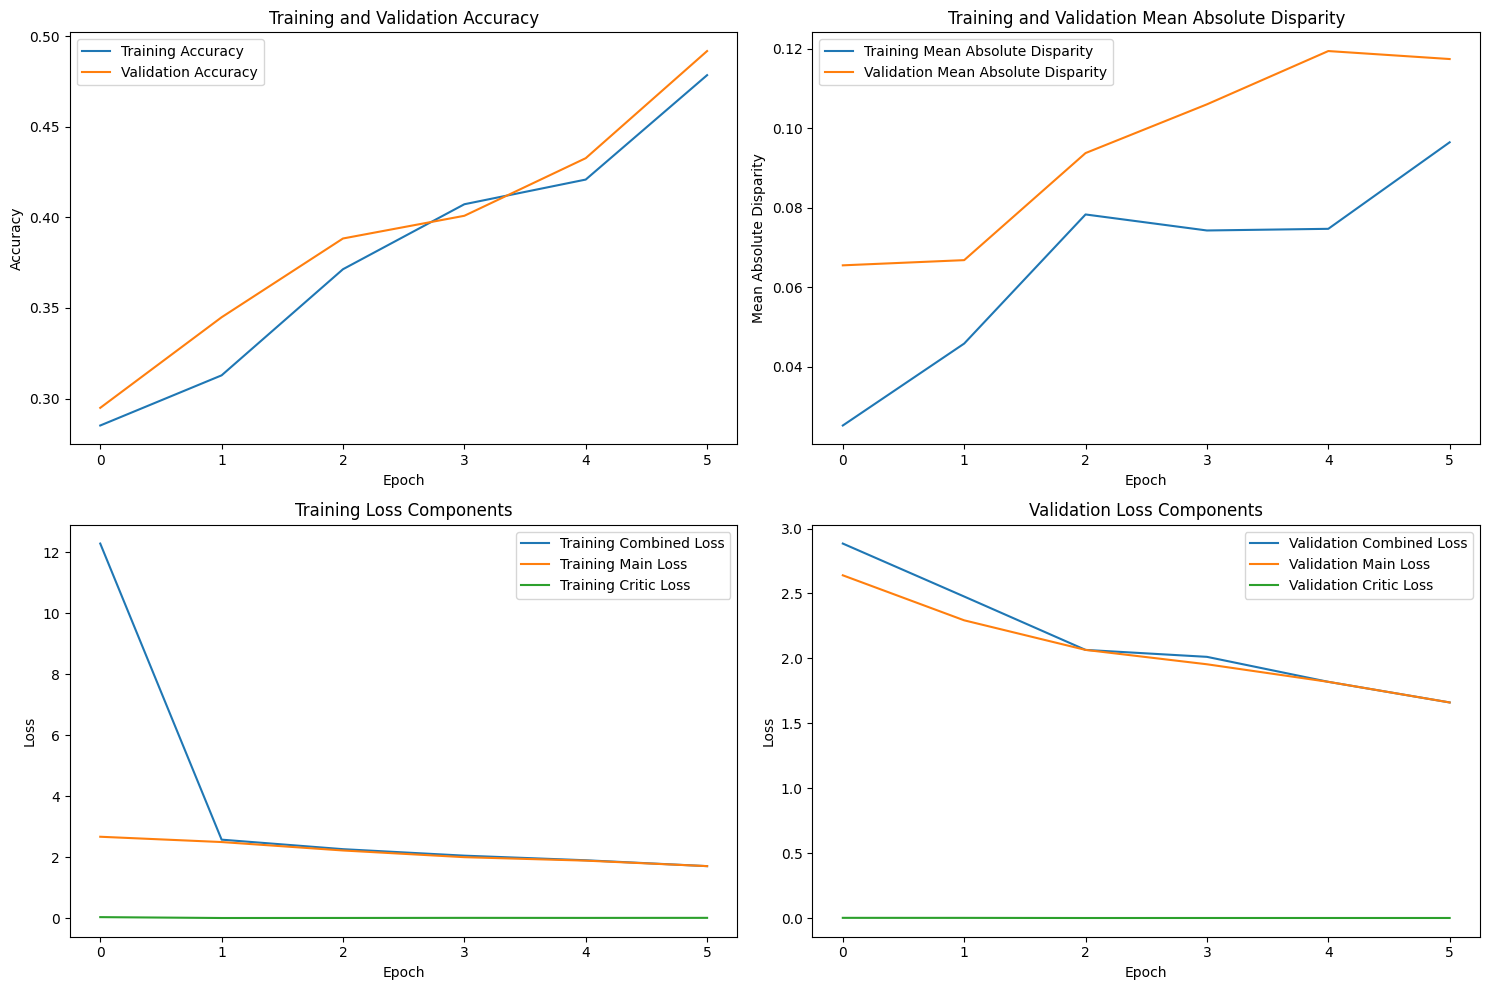

Epoch 7/200, Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.33it/s]



Lambda 50 - Epoch 7 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.522222, VALIDATION Accuracy: 0.5273
TRAINING Disparity: 0.110715, VALIDATION Disparity: 0.1779
TRAINING Combined Loss: 1.568997, VALIDATION Combined Loss: 1.5604
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.14281797306097277
Class Celebration: Val Disparity = 0.030841584158415813
Class Parade: Val Disparity = 0.11837121212121215
Class Waiter_Or_Waitress: Val Disparity = -0.3592974417716686
Class Individual_Sports: Val Disparity = -0.18882646691635463
Class Surgeons: Val Disparity = 0.08721359940872142
Class Spa: Val Disparity = -0.3333333333333333
Class Law_Enforcement: Val Disparity = 0.15563380281690137
Class Business: Val Disparity = 0.06664537421484079
Class Dresses: Val Disparity = -0.718562874251497
Class Water_Activities: Val Disparity = -0.004577389823291478
Class Picnic: Val Disparity = -0.24183006535947715
Class Rescue: Val Disparit

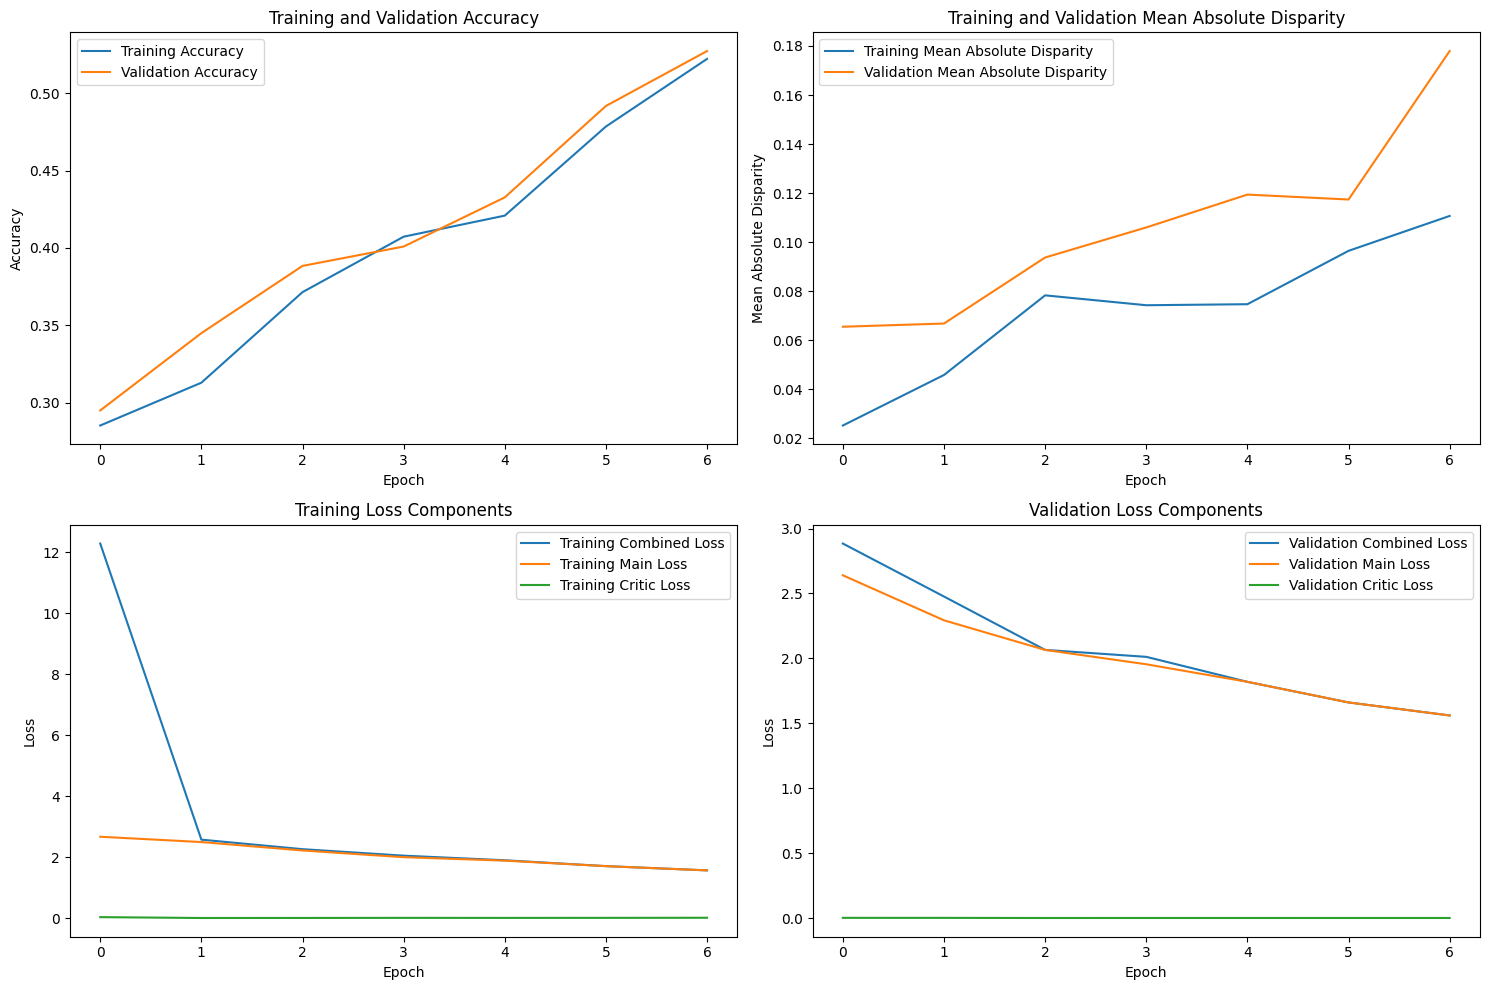

Epoch 8/200, Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.30it/s]



Lambda 50 - Epoch 8 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.557793, VALIDATION Accuracy: 0.5413
TRAINING Disparity: 0.104482, VALIDATION Disparity: 0.1584
TRAINING Combined Loss: 1.451317, VALIDATION Combined Loss: 1.4954
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.1364316642103941
Class Celebration: Val Disparity = -0.004158415841584162
Class Parade: Val Disparity = 0.058712121212121215
Class Waiter_Or_Waitress: Val Disparity = -0.36960672012218404
Class Individual_Sports: Val Disparity = -0.19229868913857684
Class Surgeons: Val Disparity = -0.015521064301552034
Class Spa: Val Disparity = -0.41666666666666663
Class Law_Enforcement: Val Disparity = 0.15305164319248832
Class Business: Val Disparity = 0.03183221547961246
Class Dresses: Val Disparity = -0.6227544910179641
Class Water_Activities: Val Disparity = 0.003619331488184052
Class Picnic: Val Disparity = -0.32026143790849676
Class Rescue: Val Dis

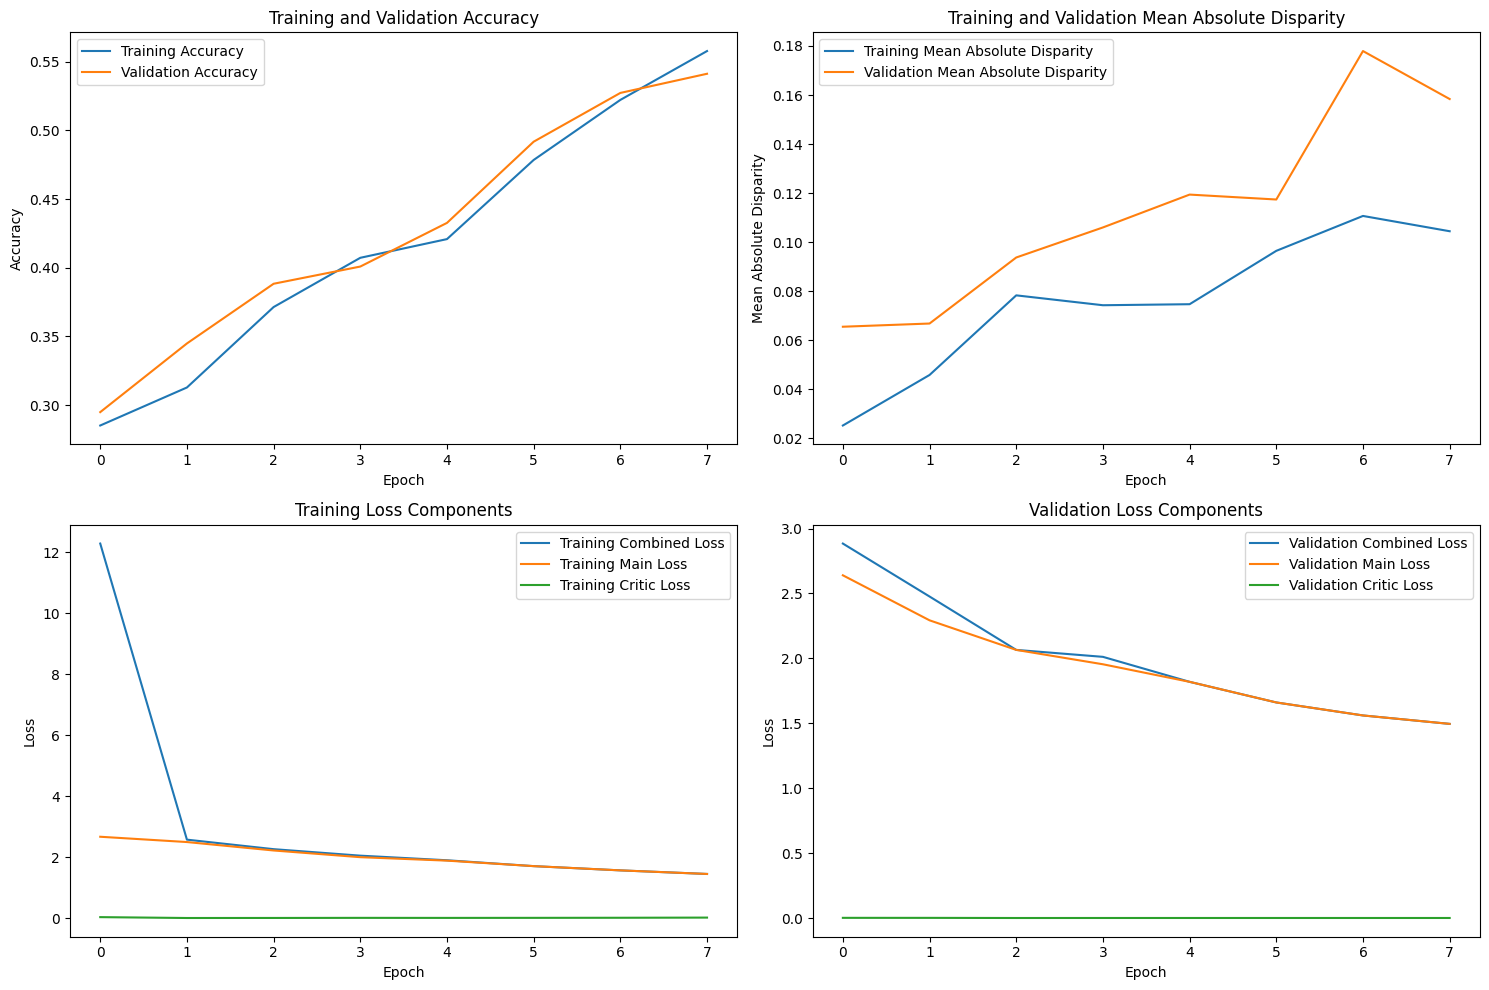

Epoch 9/200, Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.25it/s]



Lambda 50 - Epoch 9 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.584742, VALIDATION Accuracy: 0.5614
TRAINING Disparity: 0.099483, VALIDATION Disparity: 0.1679
TRAINING Combined Loss: 1.355932, VALIDATION Combined Loss: 1.4316
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.11817527504541259
Class Celebration: Val Disparity = 0.04594059405940587
Class Parade: Val Disparity = 0.06439393939393945
Class Waiter_Or_Waitress: Val Disparity = -0.3100420007636503
Class Individual_Sports: Val Disparity = -0.18207709113607995
Class Surgeons: Val Disparity = -0.02143385070214343
Class Spa: Val Disparity = -0.5625
Class Law_Enforcement: Val Disparity = 0.16267605633802823
Class Business: Val Disparity = 0.04993079953156604
Class Dresses: Val Disparity = -0.688622754491018
Class Water_Activities: Val Disparity = 0.005003193527783778
Class Picnic: Val Disparity = -0.19607843137254904
Class Rescue: Val Disparity = -0.062566

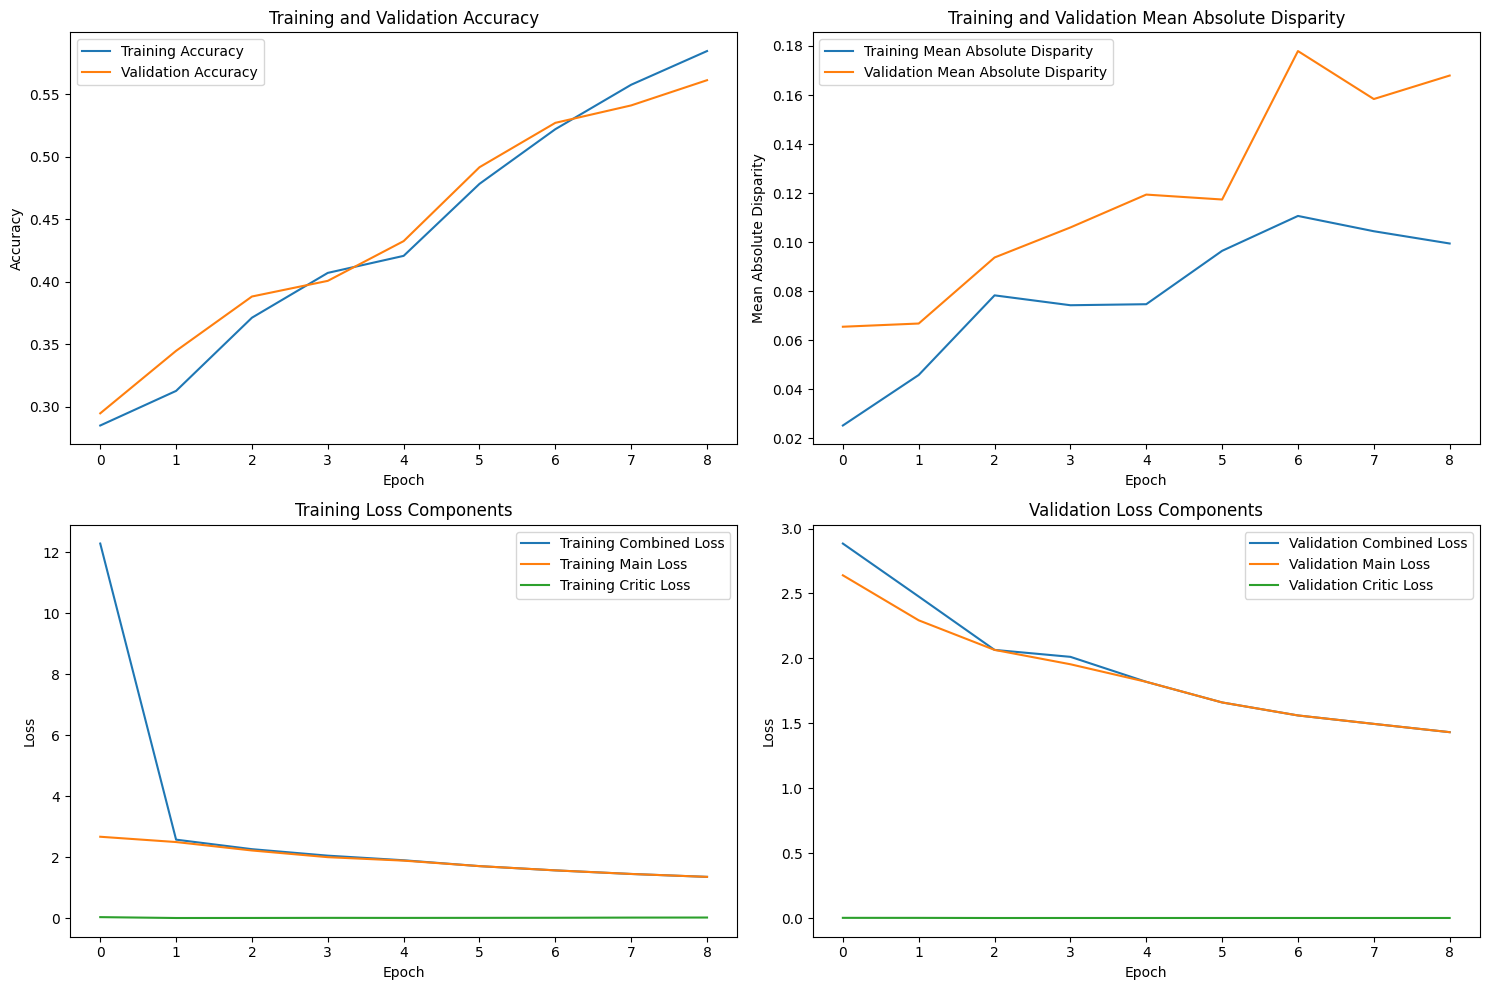

Epoch 10/200, Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.29it/s]



Lambda 50 - Epoch 10 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.612963, VALIDATION Accuracy: 0.5736
TRAINING Disparity: 0.125751, VALIDATION Disparity: 0.1703
TRAINING Combined Loss: 1.254121, VALIDATION Combined Loss: 1.3875
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.10535695924872335
Class Celebration: Val Disparity = 0.05024752475247518
Class Parade: Val Disparity = 0.08901515151515149
Class Waiter_Or_Waitress: Val Disparity = -0.3203512791141657
Class Individual_Sports: Val Disparity = -0.13284176029962558
Class Surgeons: Val Disparity = -0.027346637102734717
Class Spa: Val Disparity = -0.5625
Class Law_Enforcement: Val Disparity = 0.17676056338028162
Class Business: Val Disparity = 0.10028744809964862
Class Dresses: Val Disparity = -0.6467065868263473
Class Water_Activities: Val Disparity = -0.016180540770704743
Class Picnic: Val Disparity = -0.1633986928104575
Class Rescue: Val Disparity = -0.085

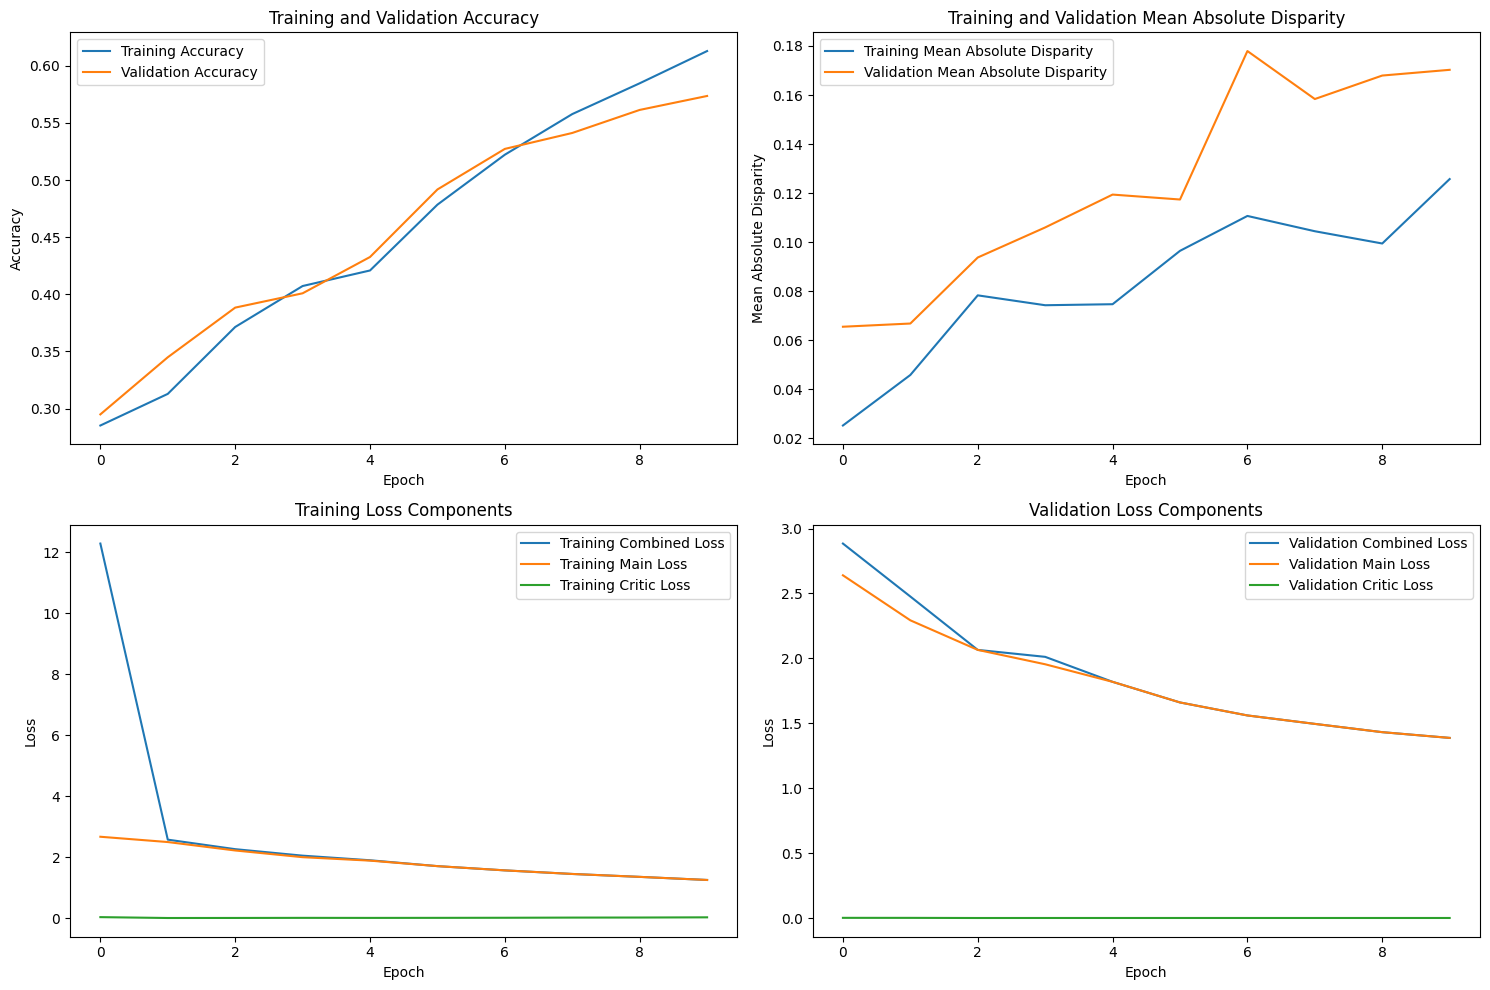

Epoch 11/200, Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.31it/s]



Lambda 50 - Epoch 11 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.645235, VALIDATION Accuracy: 0.5898
TRAINING Disparity: 0.118898, VALIDATION Disparity: 0.1777
TRAINING Combined Loss: 1.161724, VALIDATION Combined Loss: 1.3514
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.12785184677428563
Class Celebration: Val Disparity = 0.029851485148514767
Class Parade: Val Disparity = 0.07007575757575768
Class Waiter_Or_Waitress: Val Disparity = -0.1680030546009929
Class Individual_Sports: Val Disparity = -0.14489700374531844
Class Surgeons: Val Disparity = 0.02143385070214332
Class Spa: Val Disparity = -0.6666666666666666
Class Law_Enforcement: Val Disparity = 0.16267605633802823
Class Business: Val Disparity = 0.08953475992760579
Class Dresses: Val Disparity = -0.718562874251497
Class Water_Activities: Val Disparity = -0.00936768149882905
Class Picnic: Val Disparity = -0.29411764705882354
Class Rescue: Val Disparit

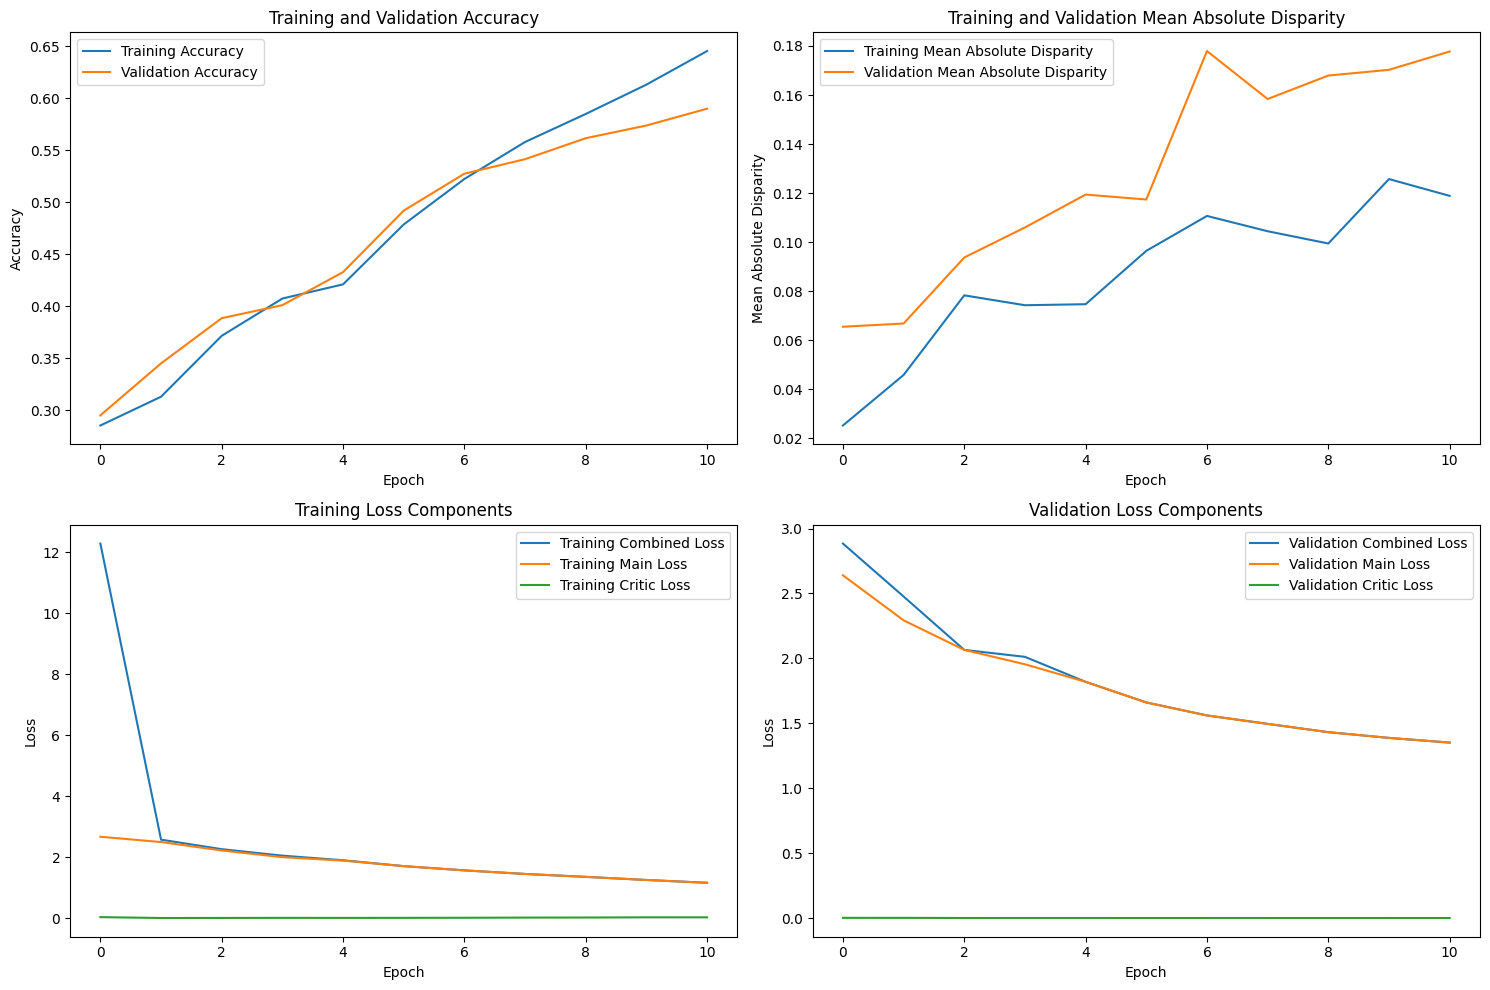

Epoch 12/200, Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.25it/s]



Lambda 50 - Epoch 12 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.669367, VALIDATION Accuracy: 0.5938
TRAINING Disparity: 0.130227, VALIDATION Disparity: 0.1860
TRAINING Combined Loss: 1.076685, VALIDATION Combined Loss: 1.3517
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.12785184677428563
Class Celebration: Val Disparity = 0.029851485148514767
Class Parade: Val Disparity = 0.07007575757575768
Class Waiter_Or_Waitress: Val Disparity = -0.1680030546009929
Class Individual_Sports: Val Disparity = -0.14489700374531844
Class Surgeons: Val Disparity = 0.02143385070214332
Class Spa: Val Disparity = -0.6666666666666666
Class Law_Enforcement: Val Disparity = 0.16267605633802823
Class Business: Val Disparity = 0.08953475992760579
Class Dresses: Val Disparity = -0.718562874251497
Class Water_Activities: Val Disparity = -0.00936768149882905
Class Picnic: Val Disparity = -0.29411764705882354
Class Rescue: Val Disparit

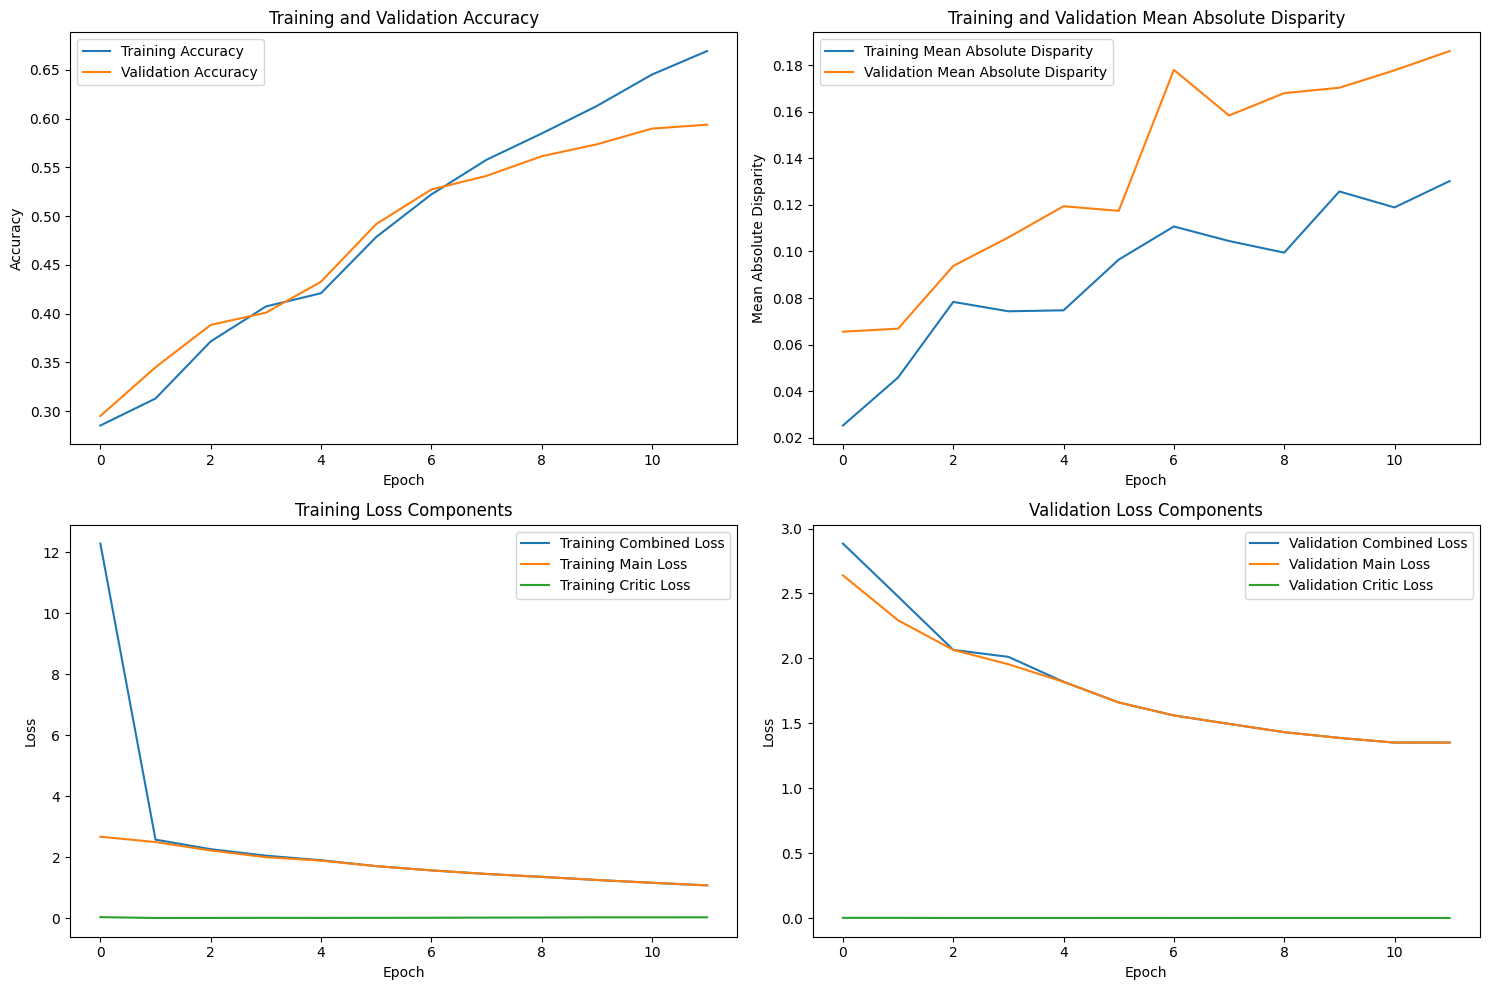

Epoch 13/200, Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.25it/s]



Lambda 50 - Epoch 13 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.698245, VALIDATION Accuracy: 0.6001
TRAINING Disparity: 0.124321, VALIDATION Disparity: 0.1447
TRAINING Combined Loss: 0.980123, VALIDATION Combined Loss: 1.3310
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.1262067153351385
Class Celebration: Val Disparity = 0.01965346534653467
Class Parade: Val Disparity = 0.09185606060606066
Class Waiter_Or_Waitress: Val Disparity = -0.2195494463535702
Class Individual_Sports: Val Disparity = -0.1432584269662921
Class Surgeons: Val Disparity = -0.02734663710273455
Class Spa: Val Disparity = -0.16666666666666663
Class Law_Enforcement: Val Disparity = 0.12159624413145542
Class Business: Val Disparity = 0.006068348770360887
Class Dresses: Val Disparity = -0.6946107784431138
Class Water_Activities: Val Disparity = 0.0002129018522460946
Class Picnic: Val Disparity = -0.3137254901960785
Class Rescue: Val Dispari

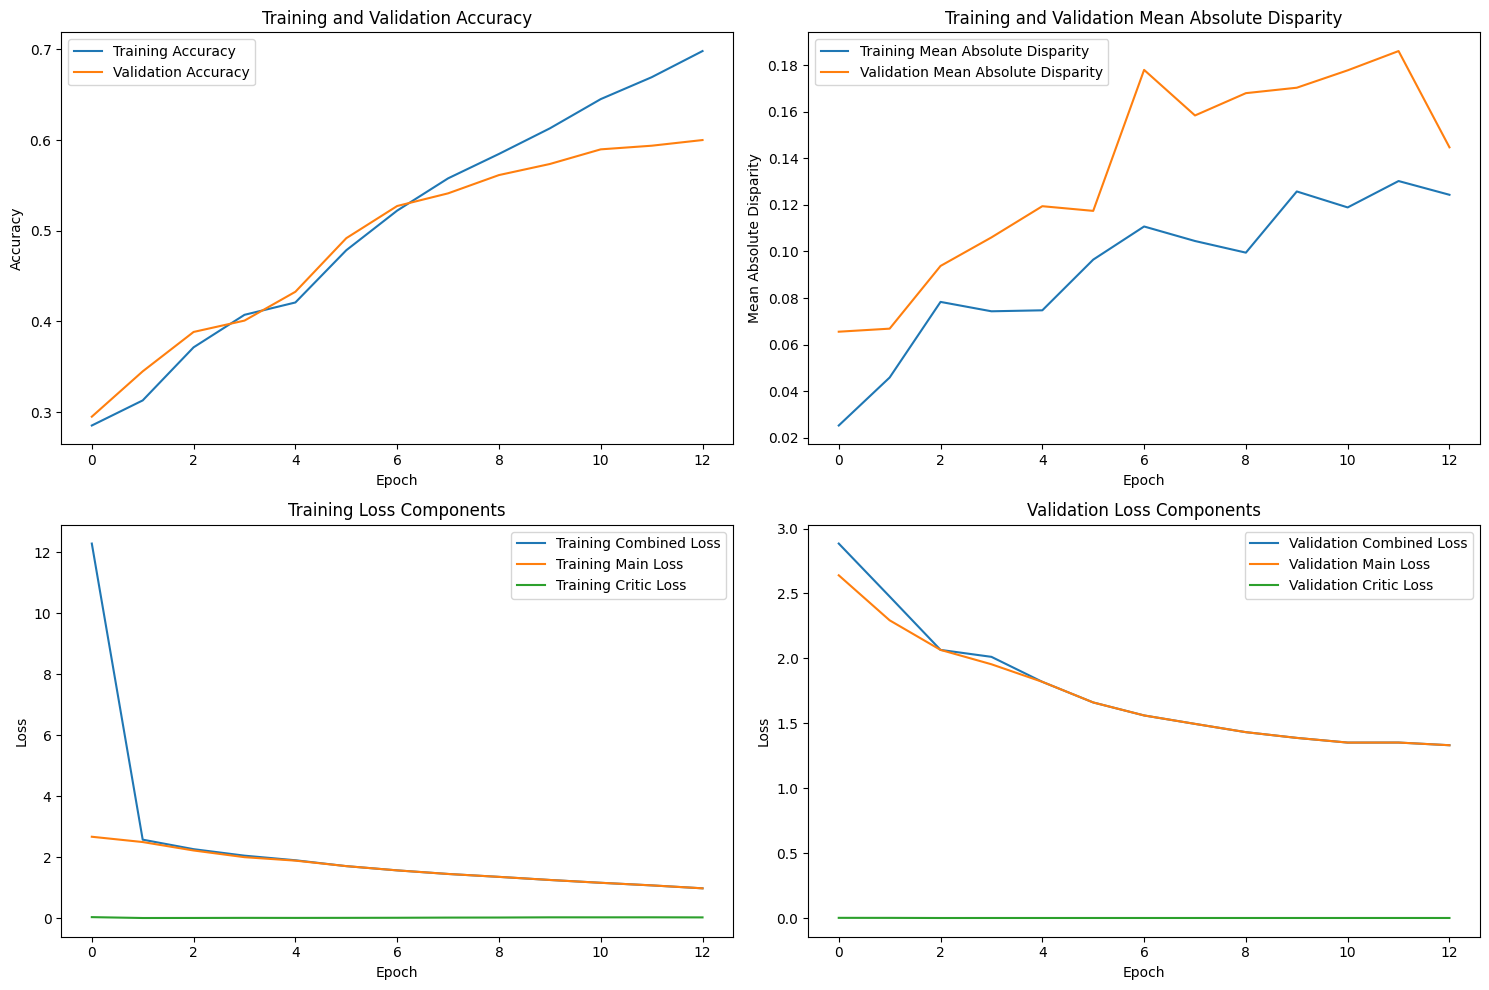

Epoch 14/200, Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.28it/s]



Lambda 50 - Epoch 14 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.726350, VALIDATION Accuracy: 0.6046
TRAINING Disparity: 0.104731, VALIDATION Disparity: 0.1465
TRAINING Combined Loss: 0.888057, VALIDATION Combined Loss: 1.3299
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.09732551895899733
Class Celebration: Val Disparity = 0.05995049504950489
Class Parade: Val Disparity = 0.08522727272727271
Class Waiter_Or_Waitress: Val Disparity = -0.18862161130202382
Class Individual_Sports: Val Disparity = -0.1007724719101124
Class Surgeons: Val Disparity = -0.027346637102734606
Class Spa: Val Disparity = -0.2499999999999999
Class Law_Enforcement: Val Disparity = 0.1427230046948358
Class Business: Val Disparity = 0.0043649526242947045
Class Dresses: Val Disparity = -0.7245508982035929
Class Water_Activities: Val Disparity = 0.007025761124121788
Class Picnic: Val Disparity = -0.35294117647058815
Class Rescue: Val Dispa

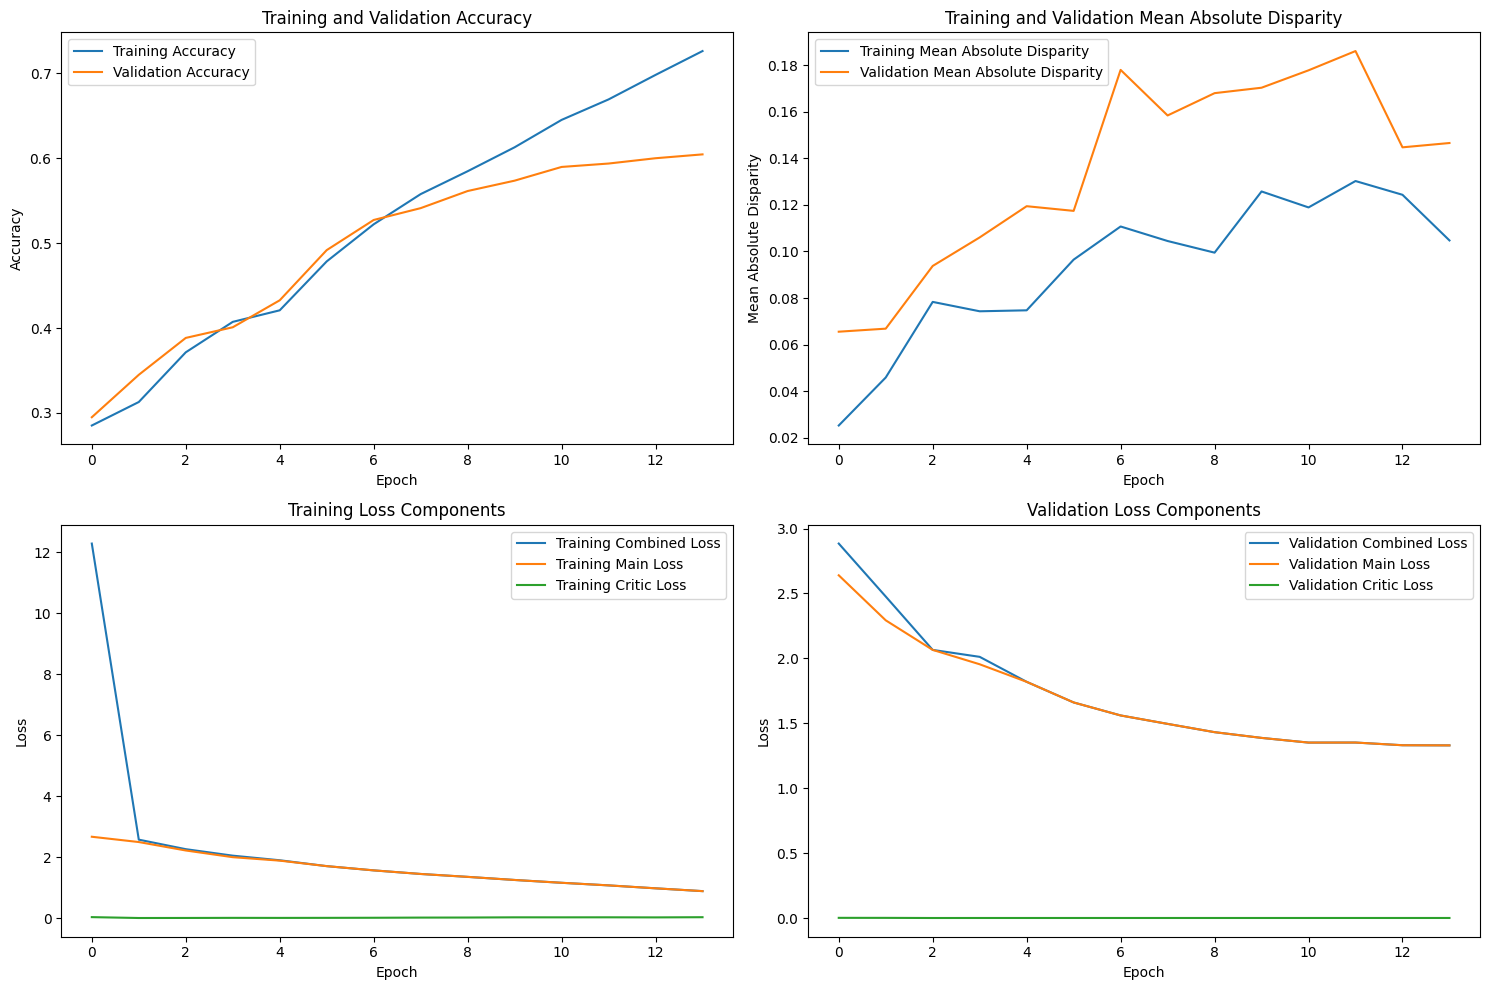

Epoch 15/200, Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.28it/s]



Lambda 50 - Epoch 15 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.764853, VALIDATION Accuracy: 0.6006
TRAINING Disparity: 0.130039, VALIDATION Disparity: 0.1442
TRAINING Combined Loss: 0.767665, VALIDATION Combined Loss: 1.3662
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.09732551895899733
Class Celebration: Val Disparity = 0.05995049504950489
Class Parade: Val Disparity = 0.08522727272727271
Class Waiter_Or_Waitress: Val Disparity = -0.18862161130202382
Class Individual_Sports: Val Disparity = -0.1007724719101124
Class Surgeons: Val Disparity = -0.027346637102734606
Class Spa: Val Disparity = -0.2499999999999999
Class Law_Enforcement: Val Disparity = 0.1427230046948358
Class Business: Val Disparity = 0.0043649526242947045
Class Dresses: Val Disparity = -0.7245508982035929
Class Water_Activities: Val Disparity = 0.007025761124121788
Class Picnic: Val Disparity = -0.35294117647058815
Class Rescue: Val Dispa

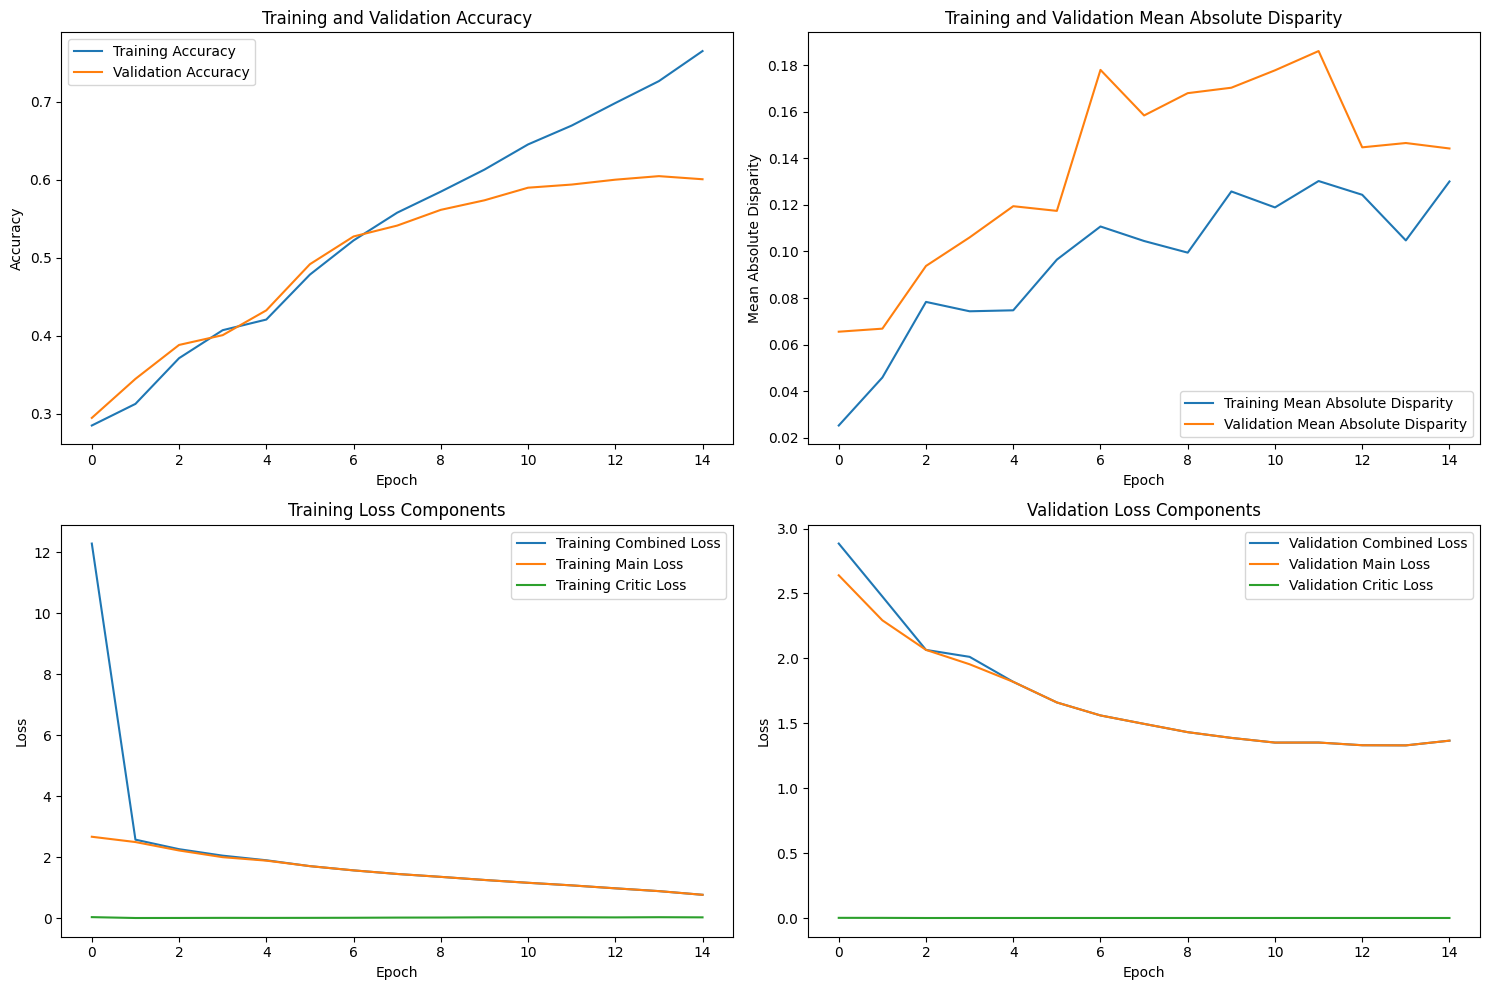

Epoch 16/200, Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.27it/s]



Lambda 50 - Epoch 16 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.797068, VALIDATION Accuracy: 0.6026
TRAINING Disparity: 0.100109, VALIDATION Disparity: 0.1283
TRAINING Combined Loss: 0.665309, VALIDATION Combined Loss: 1.3893
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.09732551895899733
Class Celebration: Val Disparity = 0.05995049504950489
Class Parade: Val Disparity = 0.08522727272727271
Class Waiter_Or_Waitress: Val Disparity = -0.18862161130202382
Class Individual_Sports: Val Disparity = -0.1007724719101124
Class Surgeons: Val Disparity = -0.027346637102734606
Class Spa: Val Disparity = -0.2499999999999999
Class Law_Enforcement: Val Disparity = 0.1427230046948358
Class Business: Val Disparity = 0.0043649526242947045
Class Dresses: Val Disparity = -0.7245508982035929
Class Water_Activities: Val Disparity = 0.007025761124121788
Class Picnic: Val Disparity = -0.35294117647058815
Class Rescue: Val Dispa

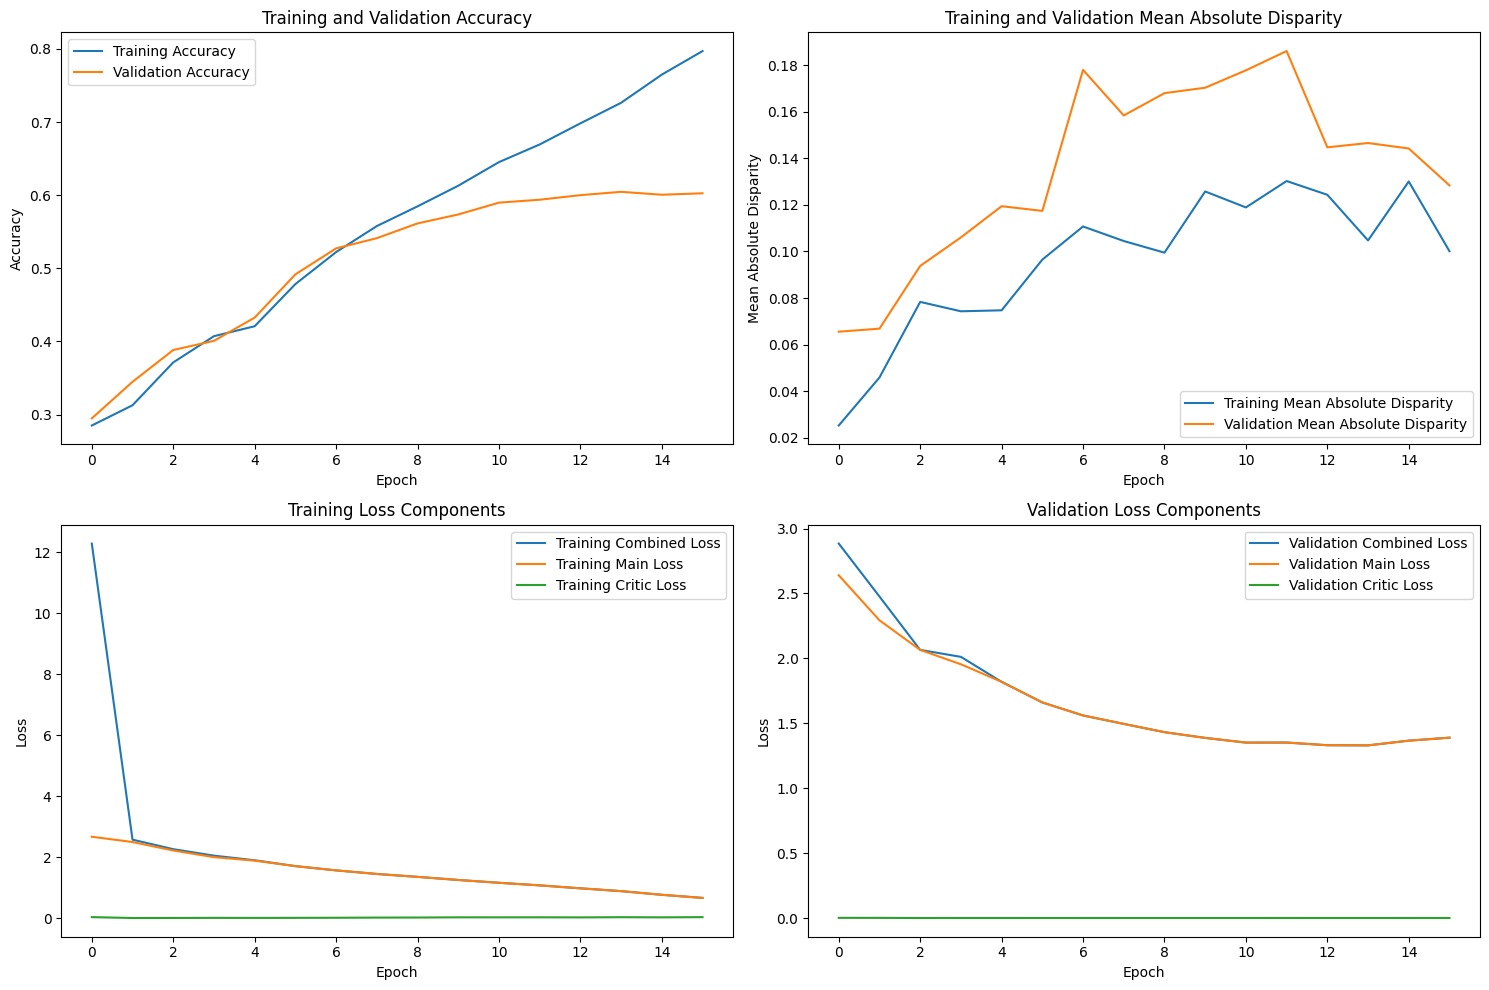

Epoch 17/200, Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.26it/s]



Lambda 50 - Epoch 17 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.830536, VALIDATION Accuracy: 0.5986
TRAINING Disparity: 0.077779, VALIDATION Disparity: 0.1340
TRAINING Combined Loss: 0.562356, VALIDATION Combined Loss: 1.4463
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.09732551895899733
Class Celebration: Val Disparity = 0.05995049504950489
Class Parade: Val Disparity = 0.08522727272727271
Class Waiter_Or_Waitress: Val Disparity = -0.18862161130202382
Class Individual_Sports: Val Disparity = -0.1007724719101124
Class Surgeons: Val Disparity = -0.027346637102734606
Class Spa: Val Disparity = -0.2499999999999999
Class Law_Enforcement: Val Disparity = 0.1427230046948358
Class Business: Val Disparity = 0.0043649526242947045
Class Dresses: Val Disparity = -0.7245508982035929
Class Water_Activities: Val Disparity = 0.007025761124121788
Class Picnic: Val Disparity = -0.35294117647058815
Class Rescue: Val Dispa

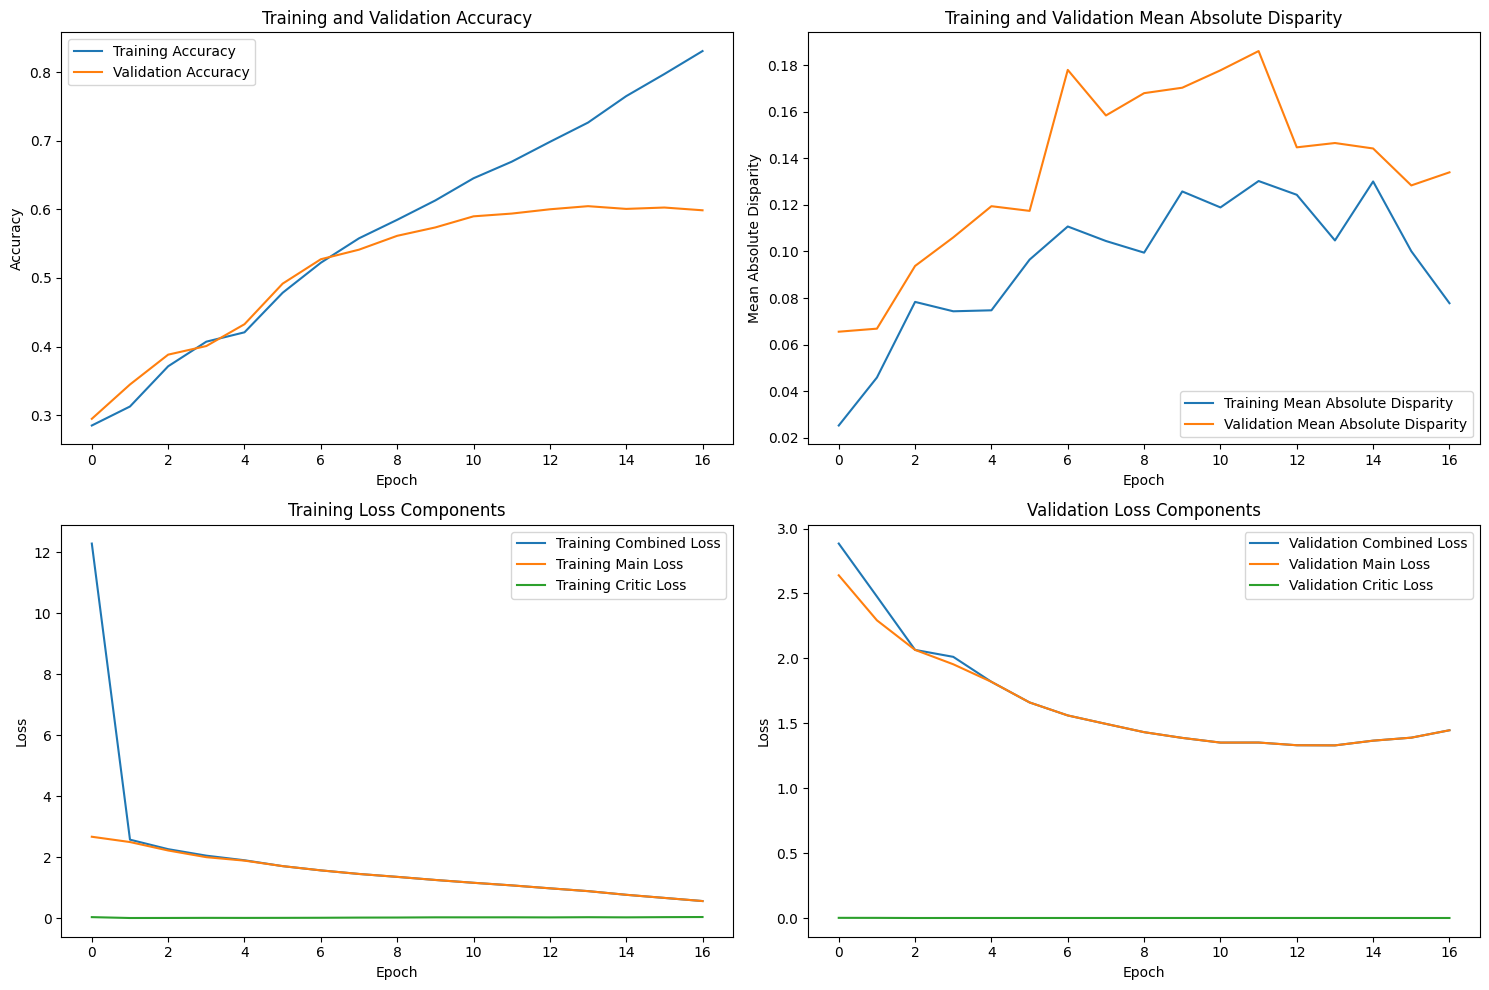

Epoch 18/200, Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.35it/s]



Lambda 50 - Epoch 18 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.867438, VALIDATION Accuracy: 0.6049
TRAINING Disparity: 0.075630, VALIDATION Disparity: 0.1738
TRAINING Combined Loss: 0.447591, VALIDATION Combined Loss: 1.5091
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.09732551895899733
Class Celebration: Val Disparity = 0.05995049504950489
Class Parade: Val Disparity = 0.08522727272727271
Class Waiter_Or_Waitress: Val Disparity = -0.18862161130202382
Class Individual_Sports: Val Disparity = -0.1007724719101124
Class Surgeons: Val Disparity = -0.027346637102734606
Class Spa: Val Disparity = -0.2499999999999999
Class Law_Enforcement: Val Disparity = 0.1427230046948358
Class Business: Val Disparity = 0.0043649526242947045
Class Dresses: Val Disparity = -0.7245508982035929
Class Water_Activities: Val Disparity = 0.007025761124121788
Class Picnic: Val Disparity = -0.35294117647058815
Class Rescue: Val Dispa

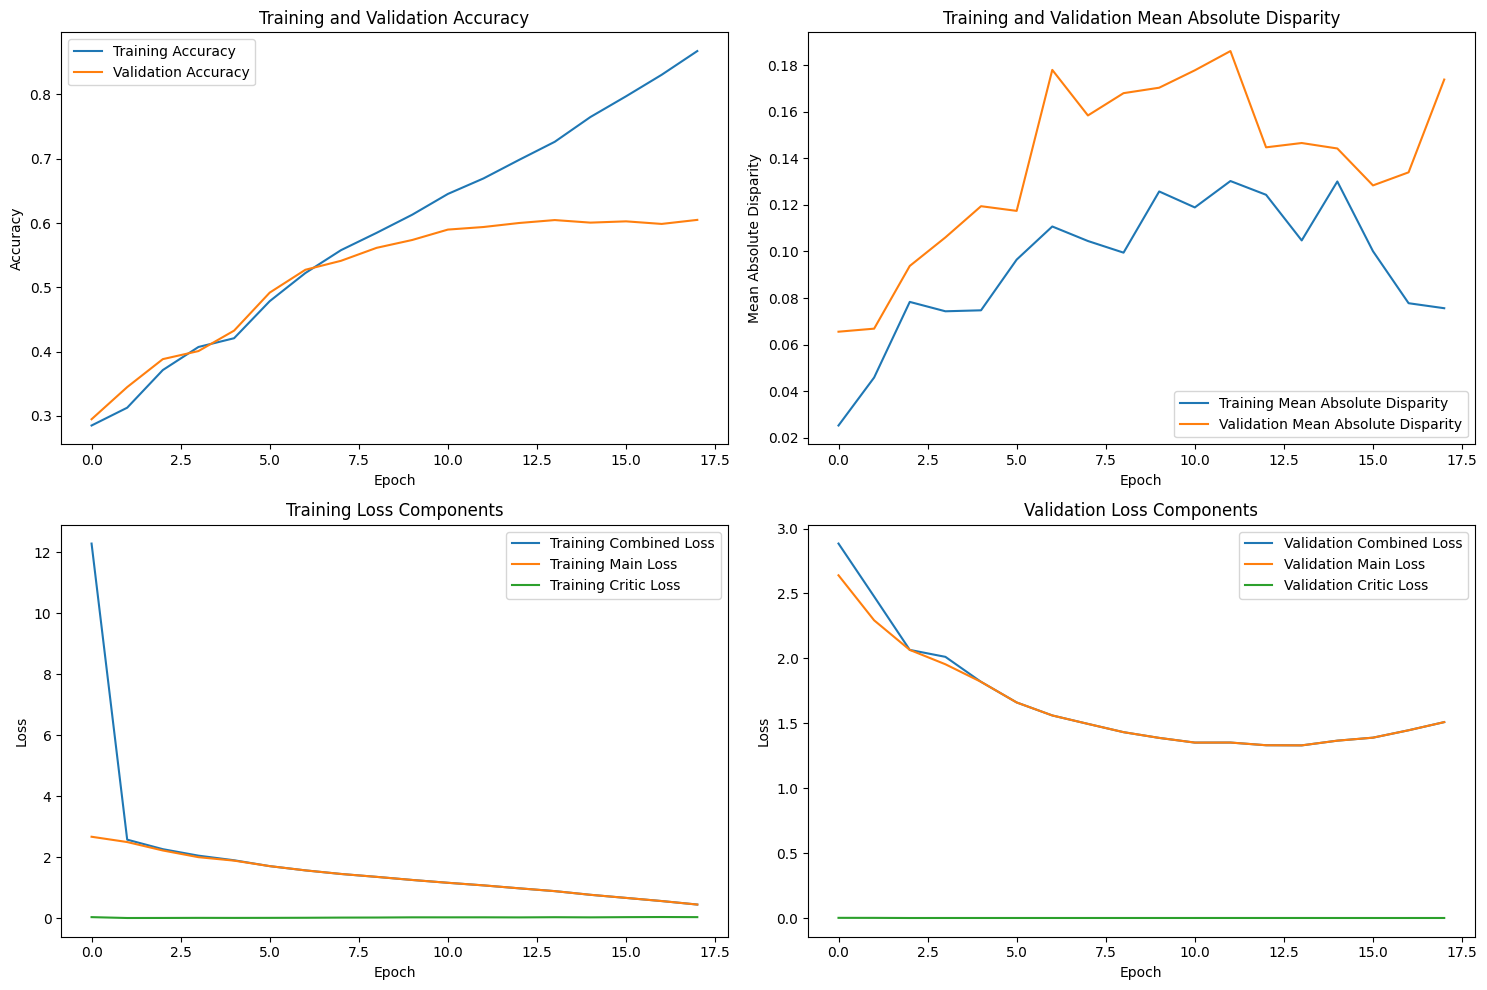

Epoch 19/200, Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.24it/s]



Lambda 50 - Epoch 19 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.897936, VALIDATION Accuracy: 0.6035
TRAINING Disparity: 0.073757, VALIDATION Disparity: 0.1575
TRAINING Combined Loss: 0.350196, VALIDATION Combined Loss: 1.5836
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.09732551895899733
Class Celebration: Val Disparity = 0.05995049504950489
Class Parade: Val Disparity = 0.08522727272727271
Class Waiter_Or_Waitress: Val Disparity = -0.18862161130202382
Class Individual_Sports: Val Disparity = -0.1007724719101124
Class Surgeons: Val Disparity = -0.027346637102734606
Class Spa: Val Disparity = -0.2499999999999999
Class Law_Enforcement: Val Disparity = 0.1427230046948358
Class Business: Val Disparity = 0.0043649526242947045
Class Dresses: Val Disparity = -0.7245508982035929
Class Water_Activities: Val Disparity = 0.007025761124121788
Class Picnic: Val Disparity = -0.35294117647058815
Class Rescue: Val Dispa

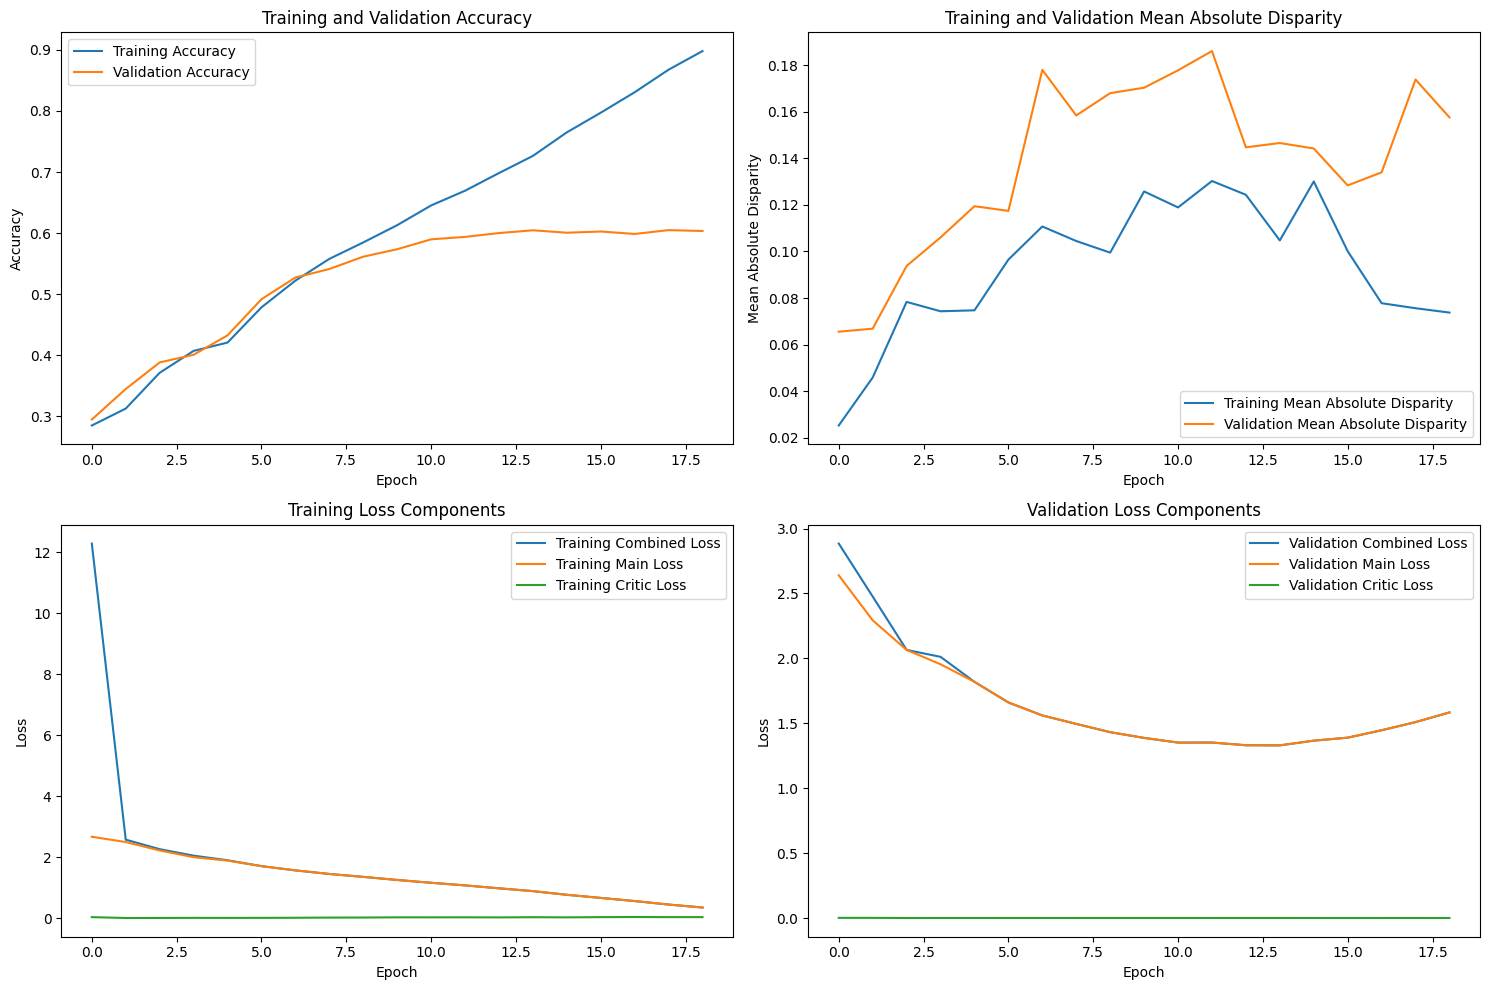

Epoch 20/200, Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:17<00:00,  3.22it/s]


Early stopping triggered at epoch 20
Finished Training with lambda value of 50. Best (stopping) epoch number: 14


Epoch 1/200, Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.25it/s]



Lambda 150 - Epoch 1 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.243422, VALIDATION Accuracy: 0.2500
TRAINING Disparity: 0.033369, VALIDATION Disparity: 0.0826
TRAINING Combined Loss: 32.565510, VALIDATION Combined Loss: 2.6122
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.17873667614902145
Class Celebration: Val Disparity = 0.0099009900990099
Class Parade: Val Disparity = 0.08143939393939398
Class Waiter_Or_Waitress: Val Disparity = 0.0
Class Individual_Sports: Val Disparity = 0.019311797752809
Class Surgeons: Val Disparity = 0.0
Class Spa: Val Disparity = 0.0
Class Law_Enforcement: Val Disparity = 0.12018779342723004
Class Business: Val Disparity = -0.1590546151389332
Class Dresses: Val Disparity = 0.0
Class Water_Activities: Val Disparity = 0.06951245475835643
Class Picnic: Val Disparity = 0.0
Class Rescue: Val Disparity = -0.022727272727272724
Class Cheering: Val Disparity = 0.0
Class Performance_And_E

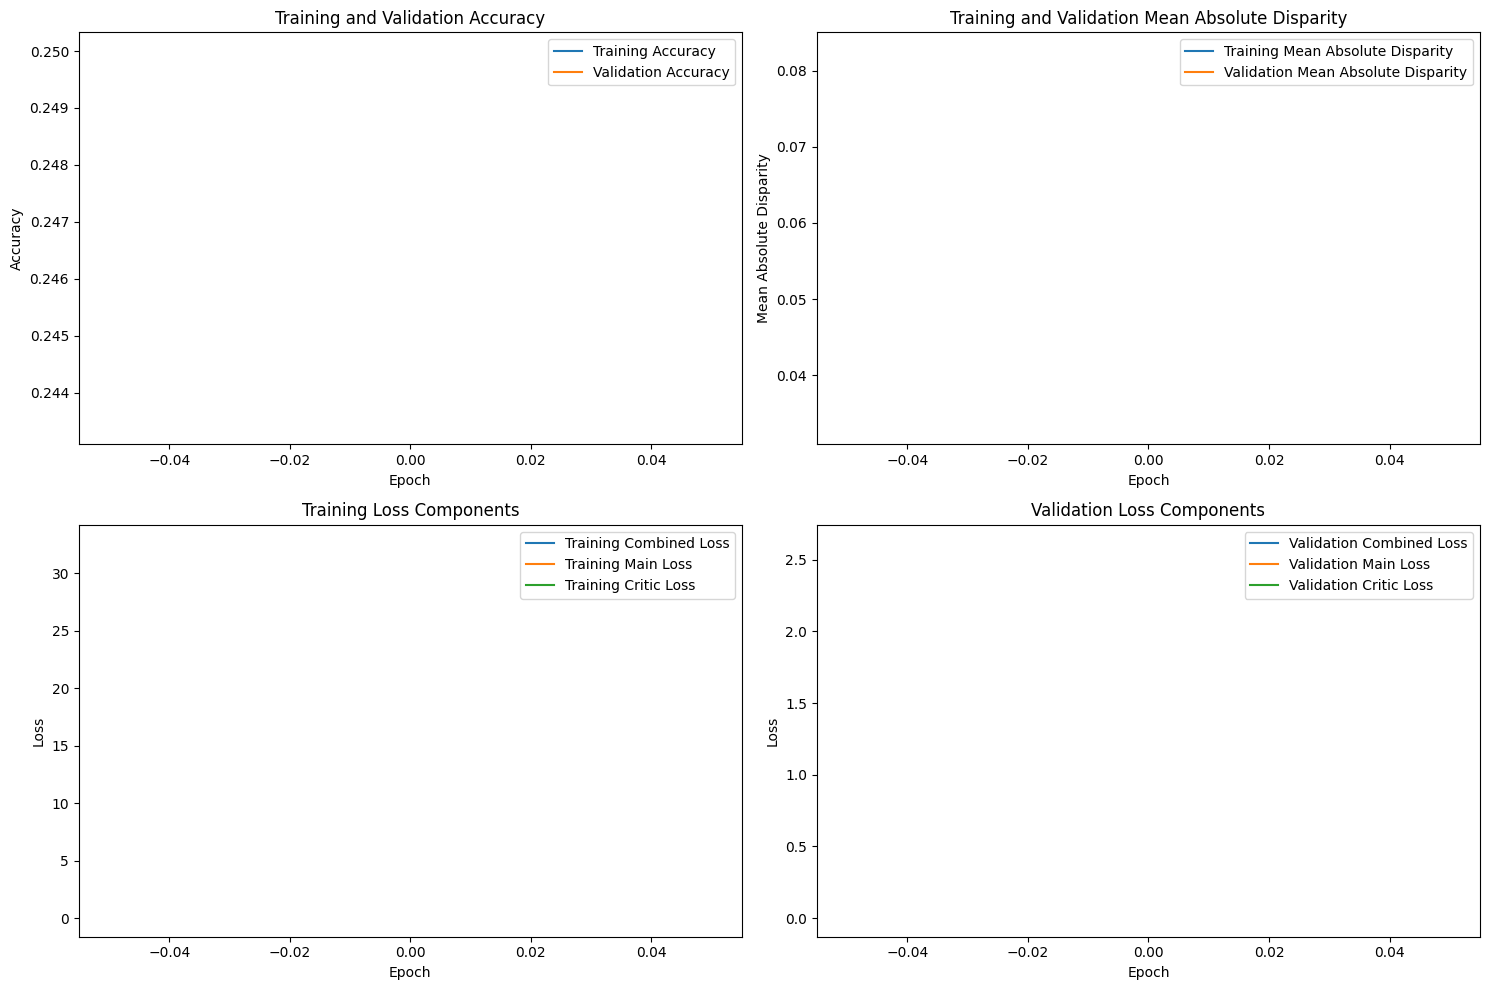

Epoch 2/200, Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.30it/s]



Lambda 150 - Epoch 2 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.244425, VALIDATION Accuracy: 0.2710
TRAINING Disparity: 0.041199, VALIDATION Disparity: 0.0515
TRAINING Combined Loss: 3.670304, VALIDATION Combined Loss: 2.4395
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.05054209365824669
Class Celebration: Val Disparity = -0.005396039603960401
Class Parade: Val Disparity = 0.04166666666666674
Class Waiter_Or_Waitress: Val Disparity = 0.0
Class Individual_Sports: Val Disparity = -0.04588014981273403
Class Surgeons: Val Disparity = -0.030303030303030304
Class Spa: Val Disparity = 0.0
Class Law_Enforcement: Val Disparity = 0.22769953051643183
Class Business: Val Disparity = -0.06313211966357923
Class Dresses: Val Disparity = 0.0
Class Water_Activities: Val Disparity = 0.005854800936768323
Class Picnic: Val Disparity = 0.0
Class Rescue: Val Disparity = -0.010962566844919787
Class Cheering: Val Disparity = 0.

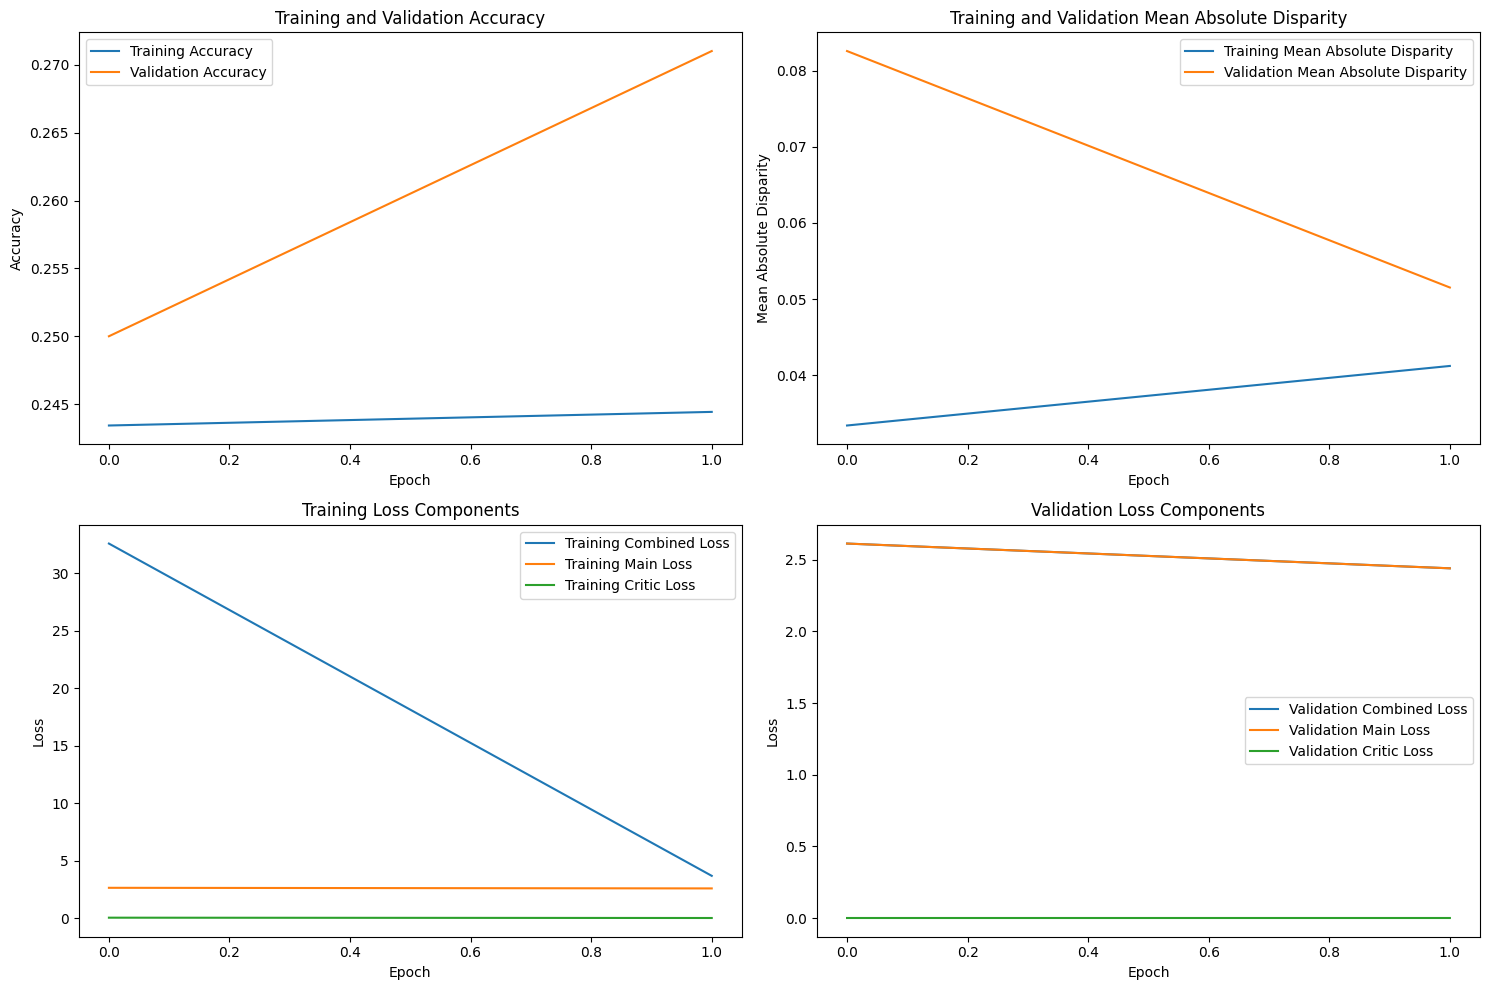

Epoch 3/200, Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:17<00:00,  3.23it/s]



Lambda 150 - Epoch 3 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.266782, VALIDATION Accuracy: 0.2929
TRAINING Disparity: 0.040874, VALIDATION Disparity: 0.0611
TRAINING Combined Loss: 3.024960, VALIDATION Combined Loss: 2.6121
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.05054209365824669
Class Celebration: Val Disparity = -0.005396039603960401
Class Parade: Val Disparity = 0.04166666666666674
Class Waiter_Or_Waitress: Val Disparity = 0.0
Class Individual_Sports: Val Disparity = -0.04588014981273403
Class Surgeons: Val Disparity = -0.030303030303030304
Class Spa: Val Disparity = 0.0
Class Law_Enforcement: Val Disparity = 0.22769953051643183
Class Business: Val Disparity = -0.06313211966357923
Class Dresses: Val Disparity = 0.0
Class Water_Activities: Val Disparity = 0.005854800936768323
Class Picnic: Val Disparity = 0.0
Class Rescue: Val Disparity = -0.010962566844919787
Class Cheering: Val Disparity = 0.

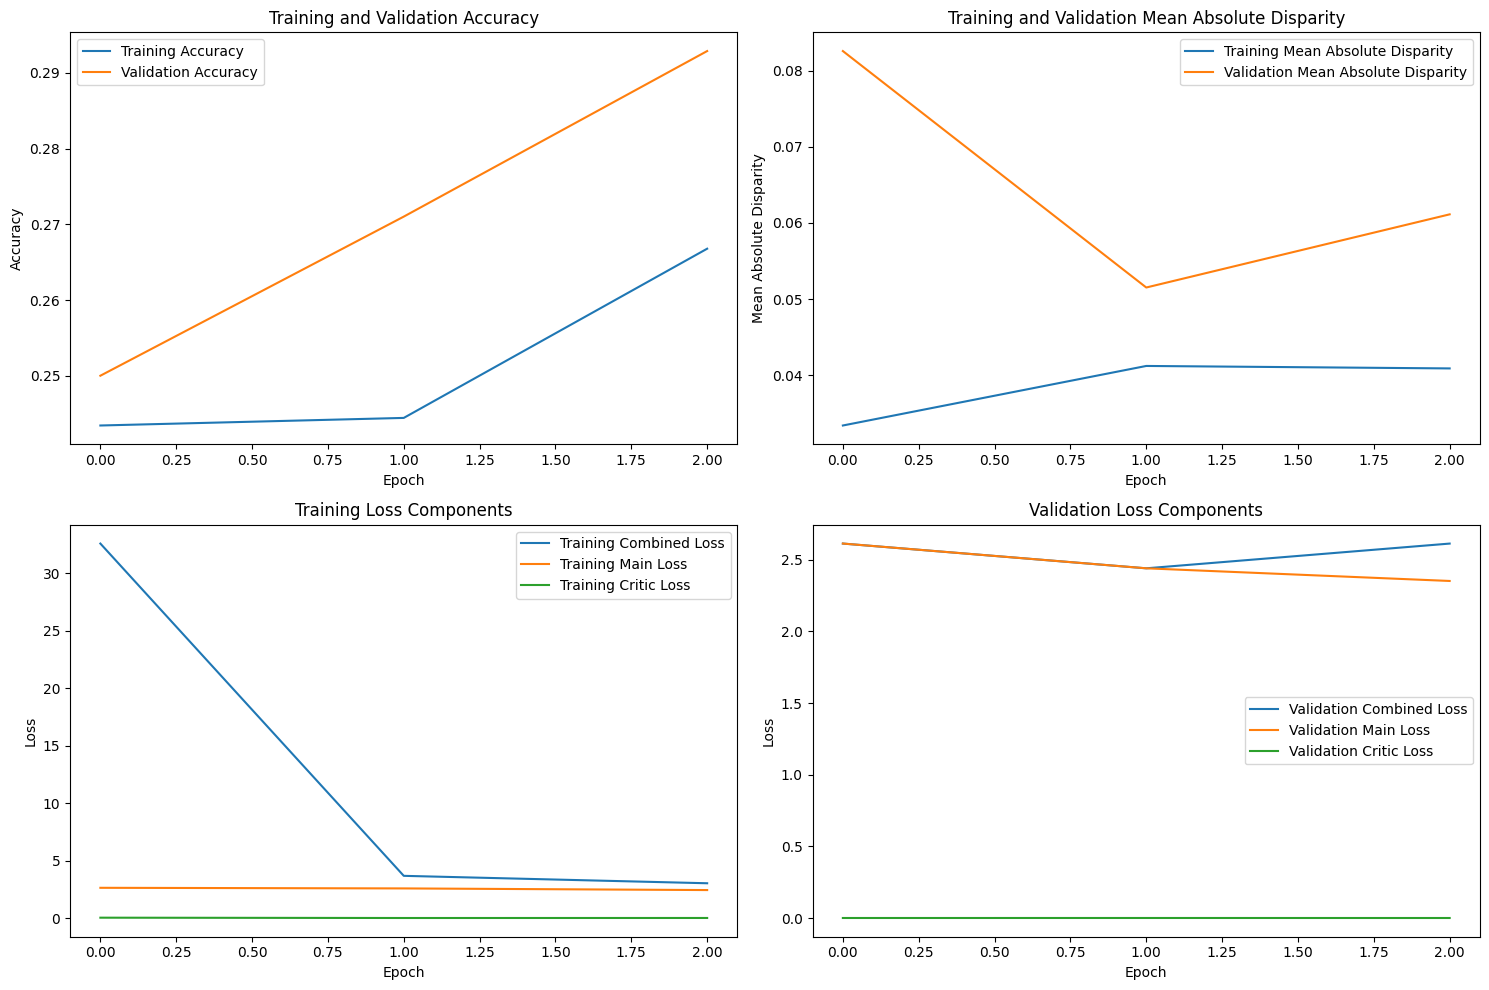

Epoch 4/200, Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.29it/s]



Lambda 150 - Epoch 4 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.284896, VALIDATION Accuracy: 0.3134
TRAINING Disparity: 0.035508, VALIDATION Disparity: 0.0531
TRAINING Combined Loss: 2.395294, VALIDATION Combined Loss: 2.3474
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.05298694176920182
Class Celebration: Val Disparity = -0.037376237623762354
Class Parade: Val Disparity = 0.05776515151515138
Class Waiter_Or_Waitress: Val Disparity = -0.06185567010309278
Class Individual_Sports: Val Disparity = -0.0007412609238451884
Class Surgeons: Val Disparity = 0.024390243902439025
Class Spa: Val Disparity = 0.0
Class Law_Enforcement: Val Disparity = 0.2622065727699532
Class Business: Val Disparity = -0.04620462046204621
Class Dresses: Val Disparity = -0.005988023952095809
Class Water_Activities: Val Disparity = 0.07685756866084736
Class Picnic: Val Disparity = 0.0
Class Rescue: Val Disparity = -0.022727272727272728


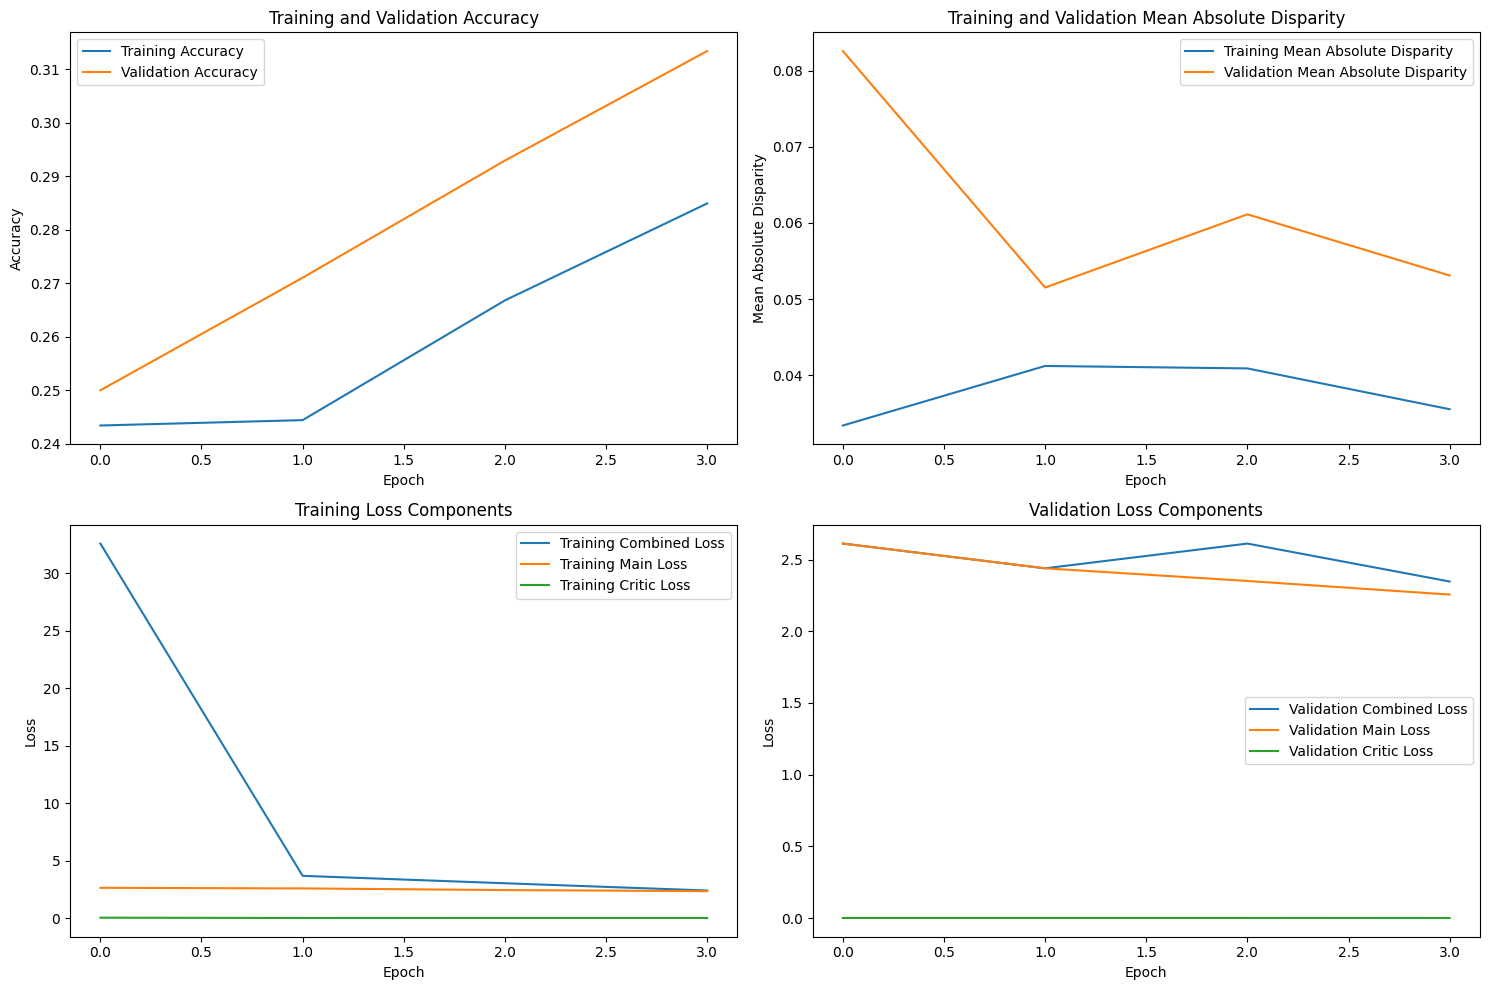

Epoch 5/200, Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.31it/s]



Lambda 150 - Epoch 5 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.318654, VALIDATION Accuracy: 0.3540
TRAINING Disparity: 0.042550, VALIDATION Disparity: 0.0769
TRAINING Combined Loss: 2.203541, VALIDATION Combined Loss: 2.1457
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.024505603728964598
Class Celebration: Val Disparity = -0.01826732673267334
Class Parade: Val Disparity = 0.039772727272727404
Class Waiter_Or_Waitress: Val Disparity = -0.19396716303932798
Class Individual_Sports: Val Disparity = -0.041588639200998756
Class Surgeons: Val Disparity = 0.024390243902439025
Class Spa: Val Disparity = 0.0
Class Law_Enforcement: Val Disparity = 0.3467136150234742
Class Business: Val Disparity = -0.056957308634089265
Class Dresses: Val Disparity = -0.029940119760479045
Class Water_Activities: Val Disparity = 0.06450926123057277
Class Picnic: Val Disparity = 0.0
Class Rescue: Val Disparity = 0.0
Class Cheering: V

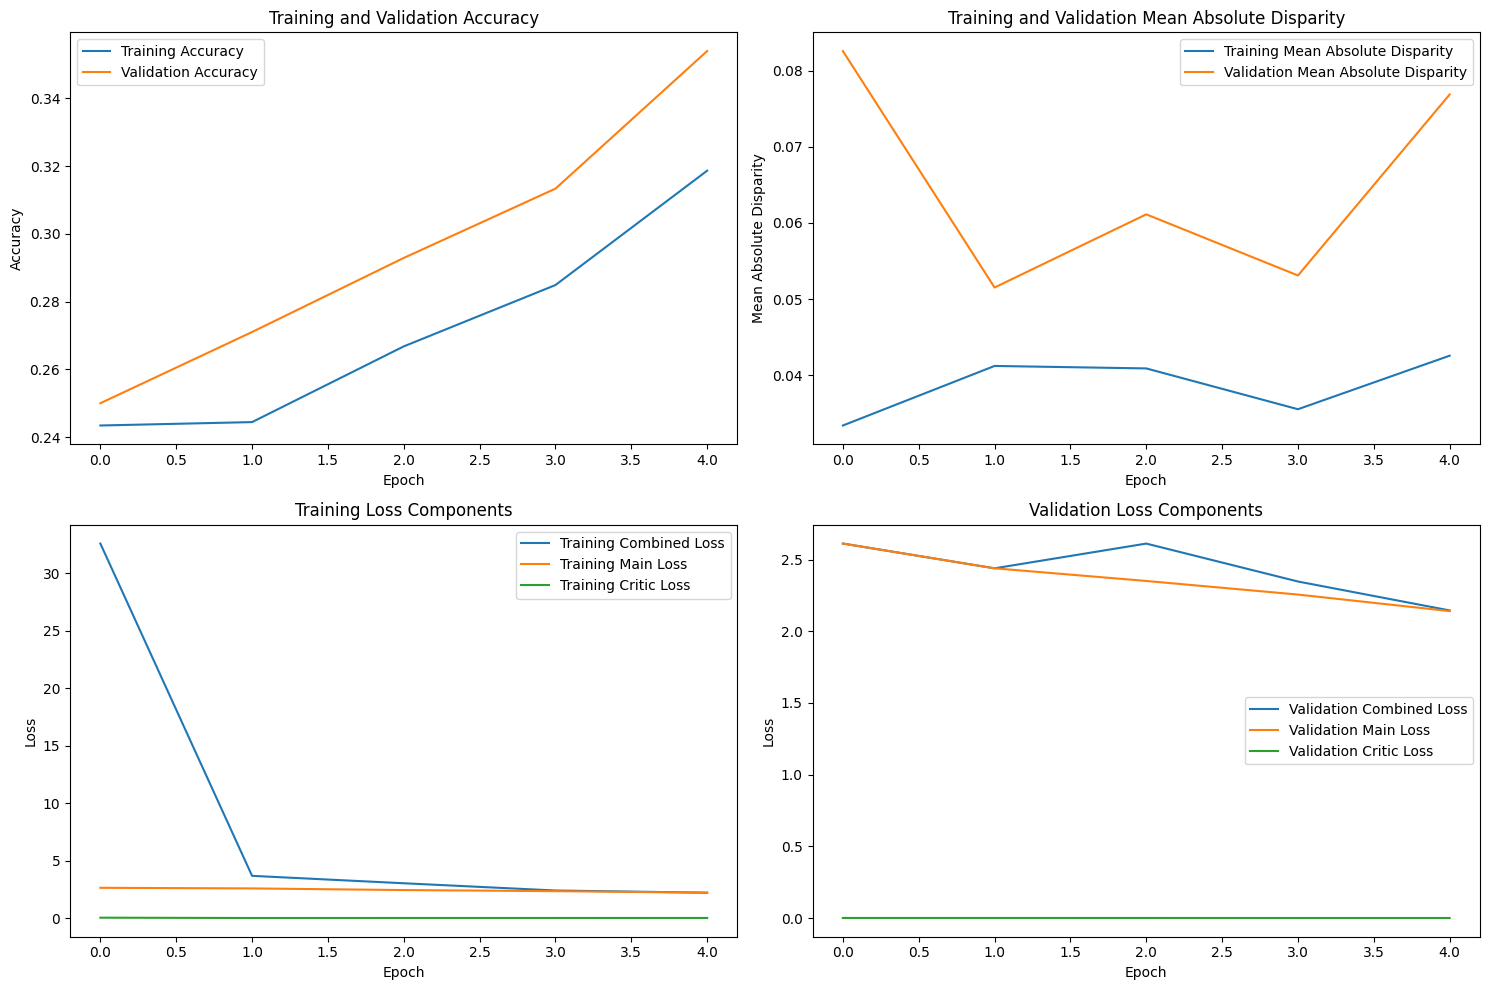

Epoch 6/200, Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.32it/s]



Lambda 150 - Epoch 6 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.351948, VALIDATION Accuracy: 0.3653
TRAINING Disparity: 0.056055, VALIDATION Disparity: 0.0529
TRAINING Combined Loss: 2.107081, VALIDATION Combined Loss: 2.0773
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.02859558327906697
Class Celebration: Val Disparity = -0.003366336633663425
Class Parade: Val Disparity = 0.02651515151515138
Class Waiter_Or_Waitress: Val Disparity = -0.17754868270332186
Class Individual_Sports: Val Disparity = 0.04197877652933829
Class Surgeons: Val Disparity = 0.024390243902439022
Class Spa: Val Disparity = 0.0
Class Law_Enforcement: Val Disparity = 0.27112676056338025
Class Business: Val Disparity = 0.0058554242521026145
Class Dresses: Val Disparity = -0.005988023952095809
Class Water_Activities: Val Disparity = -0.0502448371300831
Class Picnic: Val Disparity = 0.0
Class Rescue: Val Disparity = -0.022727272727272724
C

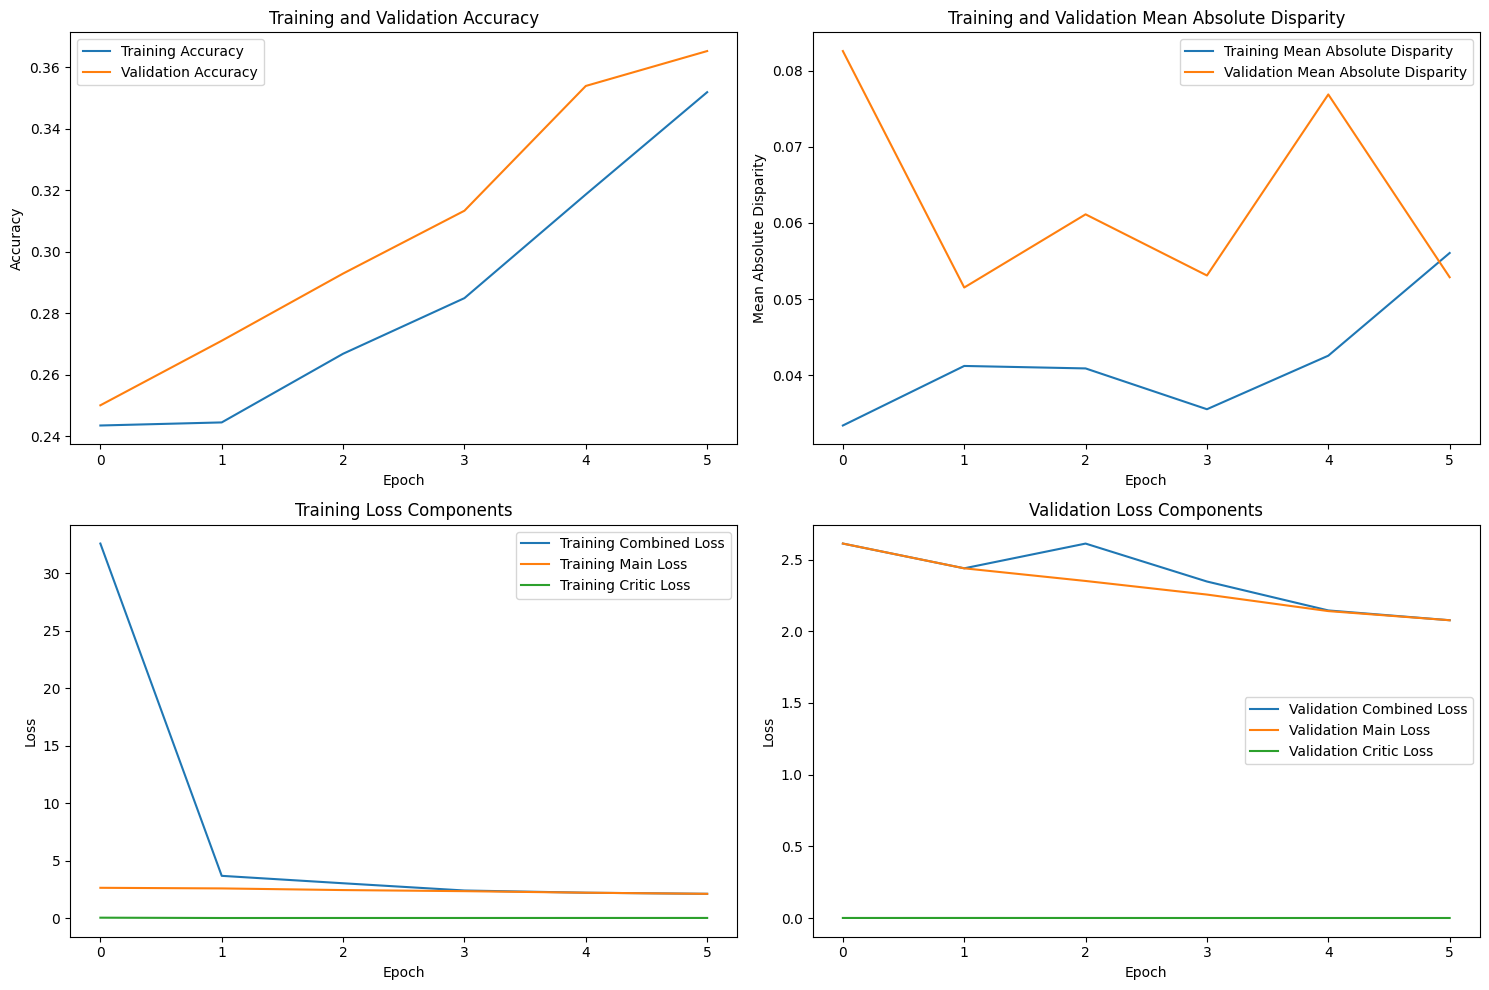

Epoch 7/200, Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.28it/s]



Lambda 150 - Epoch 7 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.370949, VALIDATION Accuracy: 0.3892
TRAINING Disparity: 0.055225, VALIDATION Disparity: 0.0683
TRAINING Combined Loss: 2.044195, VALIDATION Combined Loss: 2.0000
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.042362134558042386
Class Celebration: Val Disparity = -0.0032673267326733257
Class Parade: Val Disparity = 0.03409090909090917
Class Waiter_Or_Waitress: Val Disparity = -0.2600229095074456
Class Individual_Sports: Val Disparity = 0.010923845193508142
Class Surgeons: Val Disparity = 0.04878048780487805
Class Spa: Val Disparity = 0.0
Class Law_Enforcement: Val Disparity = 0.2626760563380281
Class Business: Val Disparity = 0.022250612157989957
Class Dresses: Val Disparity = -0.11976047904191618
Class Water_Activities: Val Disparity = -0.03661911858633171
Class Picnic: Val Disparity = 0.0
Class Rescue: Val Disparity = -0.022727272727272724
Cl

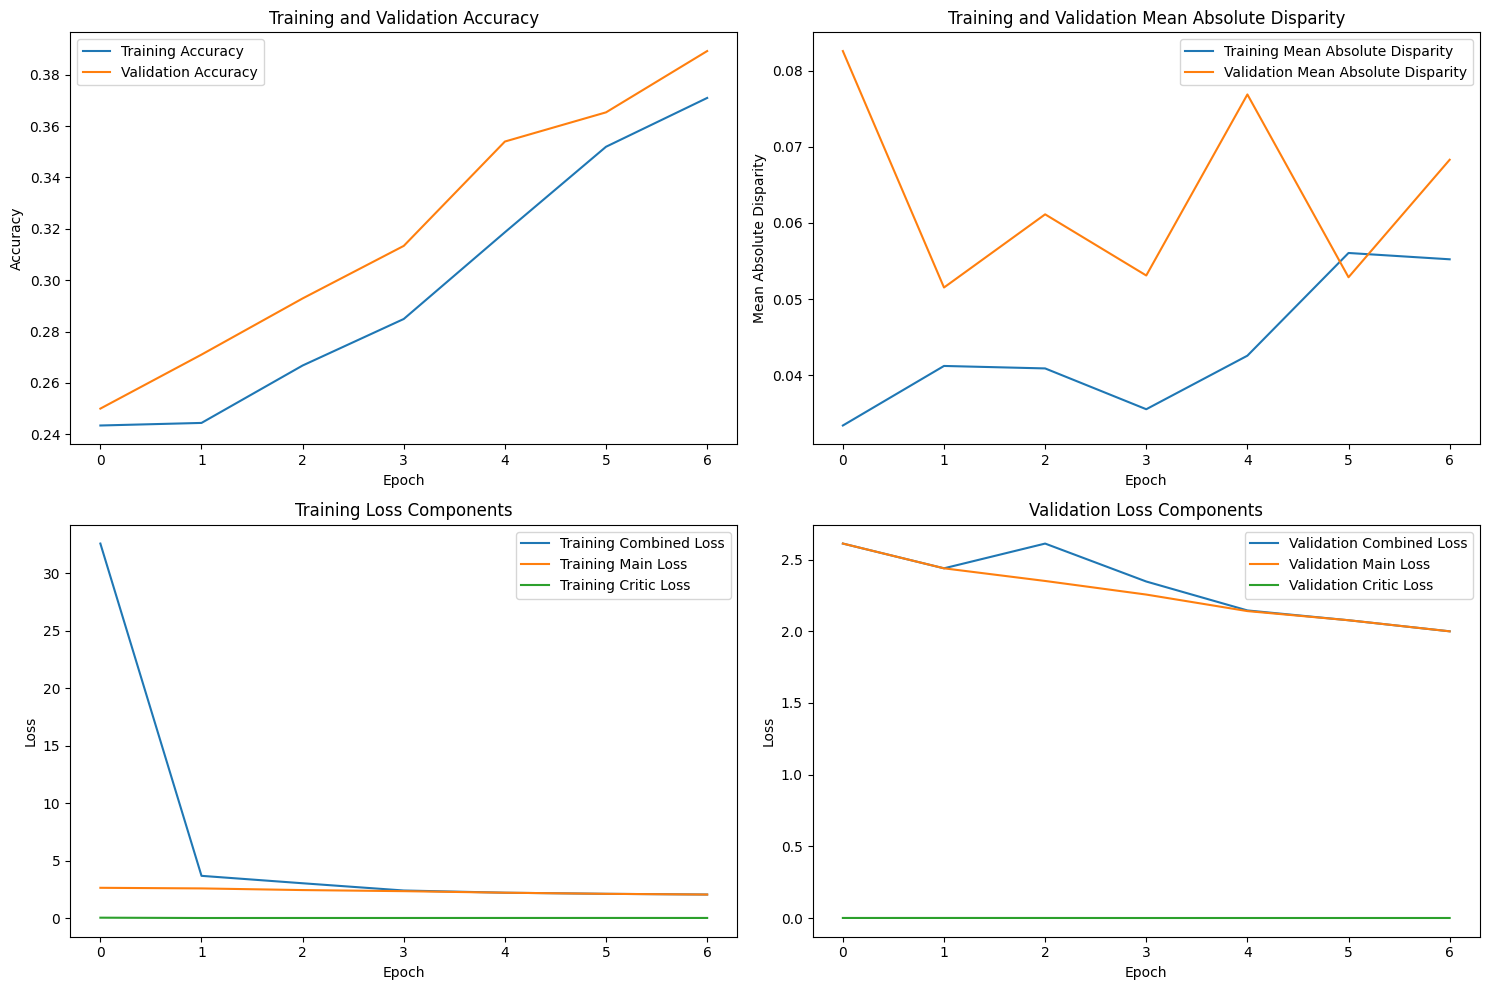

Epoch 8/200, Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.26it/s]



Lambda 150 - Epoch 8 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.392361, VALIDATION Accuracy: 0.4125
TRAINING Disparity: 0.057145, VALIDATION Disparity: 0.0970
TRAINING Combined Loss: 1.968832, VALIDATION Combined Loss: 1.9406
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.05463207320834906
Class Celebration: Val Disparity = 0.011633663366336533
Class Parade: Val Disparity = 0.06060606060606055
Class Waiter_Or_Waitress: Val Disparity = -0.28484154257350136
Class Individual_Sports: Val Disparity = -0.02972846441947563
Class Surgeons: Val Disparity = 0.048780487804878044
Class Spa: Val Disparity = 0.0
Class Law_Enforcement: Val Disparity = 0.28380281690140846
Class Business: Val Disparity = 0.051101884381986595
Class Dresses: Val Disparity = -0.34131736526946105
Class Water_Activities: Val Disparity = 0.0029806259314456574
Class Picnic: Val Disparity = 0.0
Class Rescue: Val Disparity = -0.022727272727272724
C

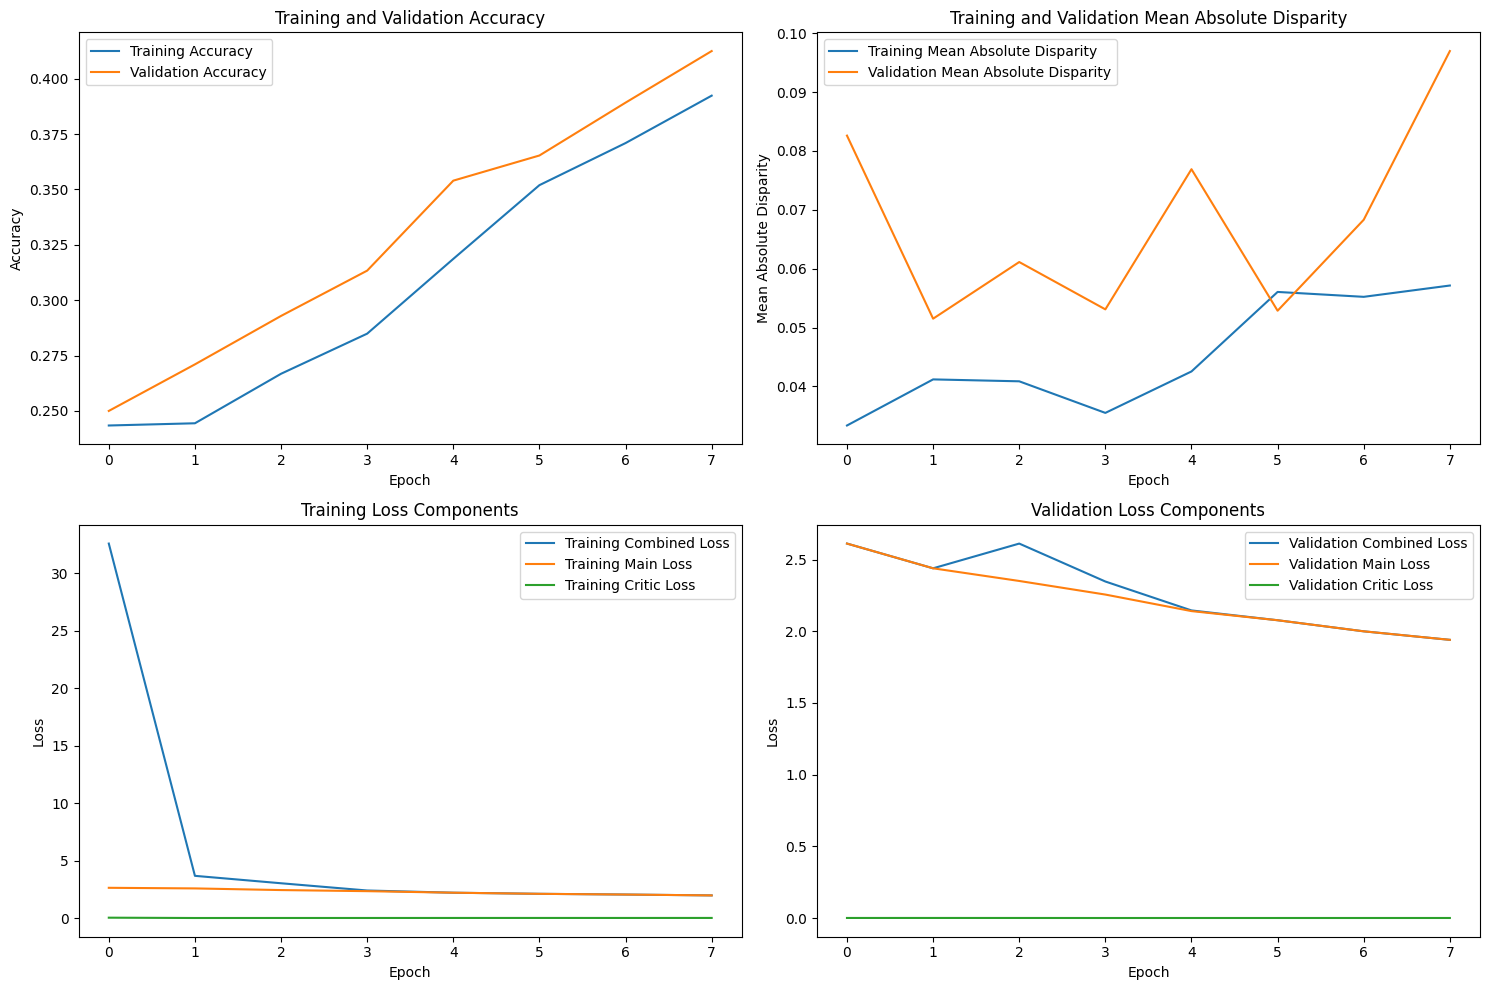

Epoch 9/200, Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.25it/s]



Lambda 150 - Epoch 9 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.413870, VALIDATION Accuracy: 0.4295
TRAINING Disparity: 0.059710, VALIDATION Disparity: 0.0887
TRAINING Combined Loss: 1.897323, VALIDATION Combined Loss: 1.8763
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.058722052758451215
Class Celebration: Val Disparity = 0.036237623762376214
Class Parade: Val Disparity = 0.0757575757575758
Class Waiter_Or_Waitress: Val Disparity = -0.27873234058801066
Class Individual_Sports: Val Disparity = -0.06015917602996246
Class Surgeons: Val Disparity = 0.048780487804878044
Class Spa: Val Disparity = 0.0
Class Law_Enforcement: Val Disparity = 0.23826291079812206
Class Business: Val Disparity = 0.0287448099648675
Class Dresses: Val Disparity = -0.26447105788423153
Class Water_Activities: Val Disparity = 0.0029806259314456574
Class Picnic: Val Disparity = -0.0196078431372549
Class Rescue: Val Disparity = 0.0
Class

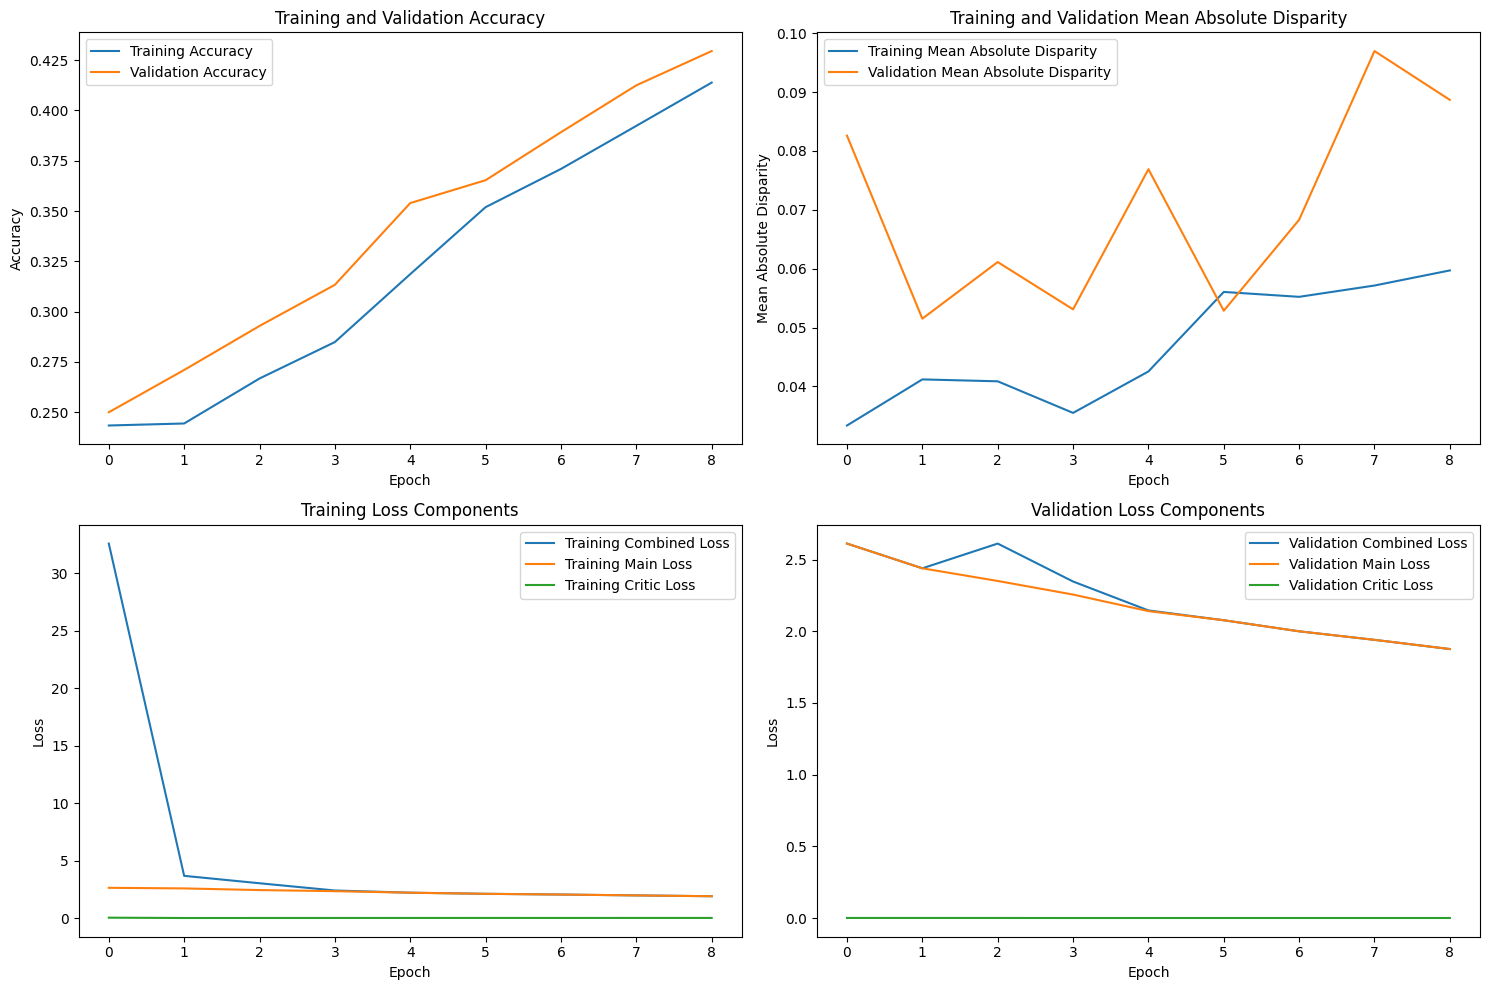

Epoch 10/200, Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.24it/s]



Lambda 150 - Epoch 10 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.436748, VALIDATION Accuracy: 0.4432
TRAINING Disparity: 0.069871, VALIDATION Disparity: 0.1017
TRAINING Combined Loss: 1.824687, VALIDATION Combined Loss: 1.8211
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.044555643143571966
Class Celebration: Val Disparity = -0.00836633663366343
Class Parade: Val Disparity = 0.09280303030303028
Class Waiter_Or_Waitress: Val Disparity = -0.27262313860252
Class Individual_Sports: Val Disparity = -0.061173533083645426
Class Surgeons: Val Disparity = 0.09756097560975609
Class Spa: Val Disparity = 0.0
Class Law_Enforcement: Val Disparity = 0.2312206572769952
Class Business: Val Disparity = 0.027041413818801208
Class Dresses: Val Disparity = -0.3063872255489022
Class Water_Activities: Val Disparity = 0.040557802852884794
Class Picnic: Val Disparity = -0.0196078431372549
Class Rescue: Val Disparity = 0.0
Class C

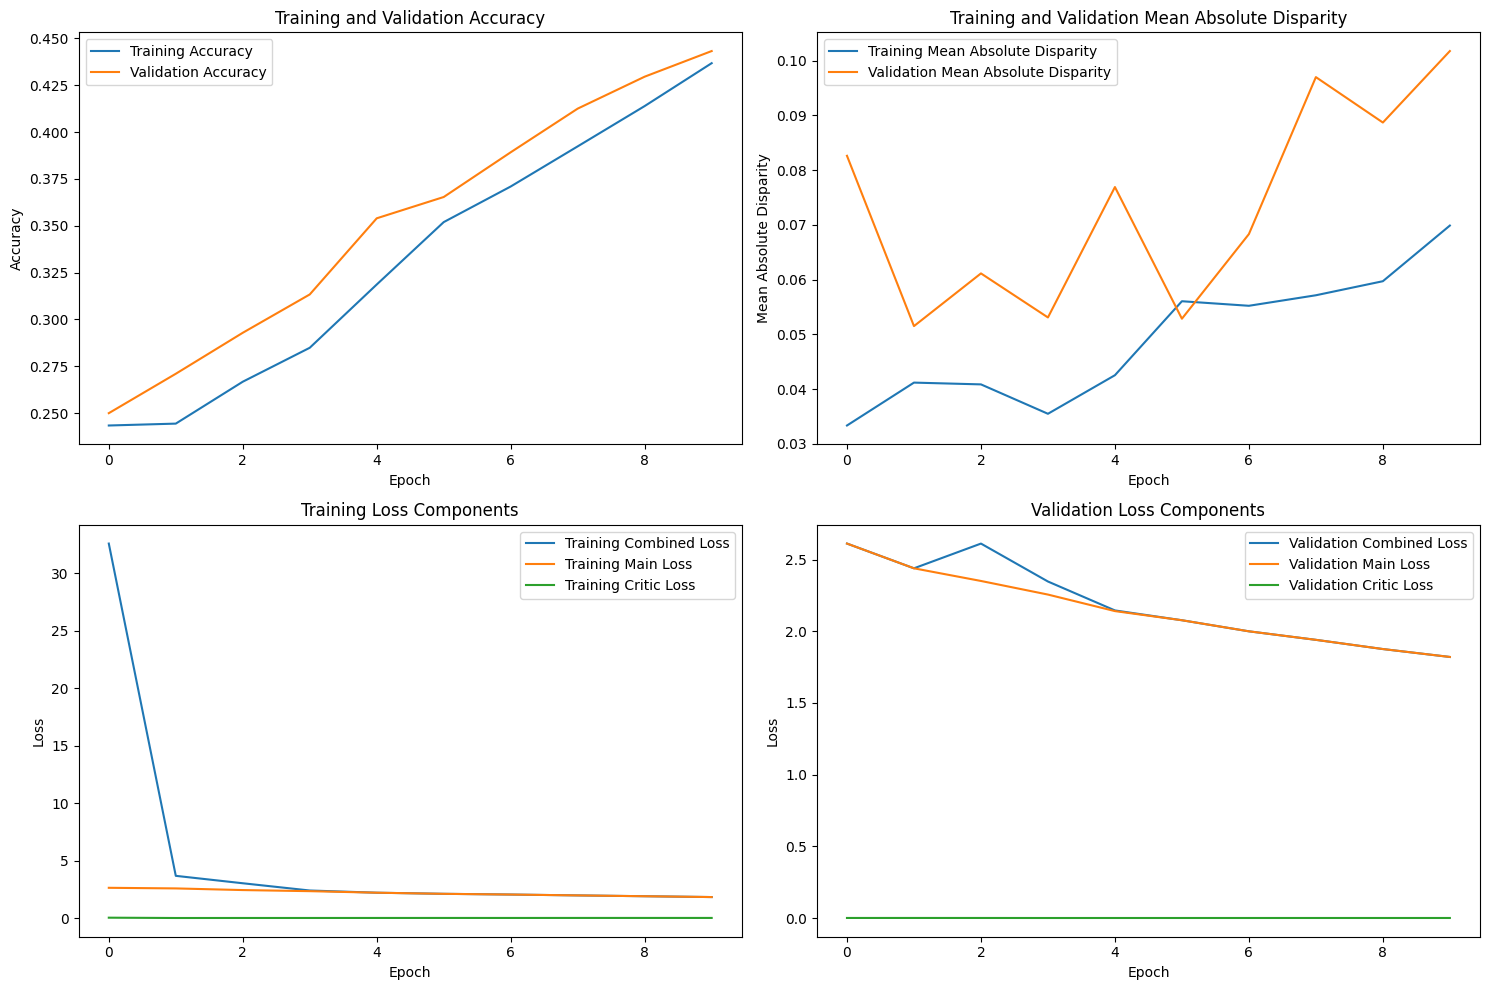

Epoch 11/200, Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.25it/s]



Lambda 150 - Epoch 11 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.453530, VALIDATION Accuracy: 0.4634
TRAINING Disparity: 0.080778, VALIDATION Disparity: 0.1099
TRAINING Combined Loss: 1.771554, VALIDATION Combined Loss: 1.7601
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.035975825707463716
Class Celebration: Val Disparity = 0.016138613861386153
Class Parade: Val Disparity = 0.08333333333333326
Class Waiter_Or_Waitress: Val Disparity = -0.3138602520045819
Class Individual_Sports: Val Disparity = -0.0421738451935082
Class Surgeons: Val Disparity = 0.0672579453067258
Class Spa: Val Disparity = 0.0
Class Law_Enforcement: Val Disparity = 0.2715962441314553
Class Business: Val Disparity = 0.04599169594378788
Class Dresses: Val Disparity = -0.4261477045908184
Class Water_Activities: Val Disparity = 0.032361081541409376
Class Picnic: Val Disparity = -0.058823529411764705
Class Rescue: Val Disparity = 0.012566844

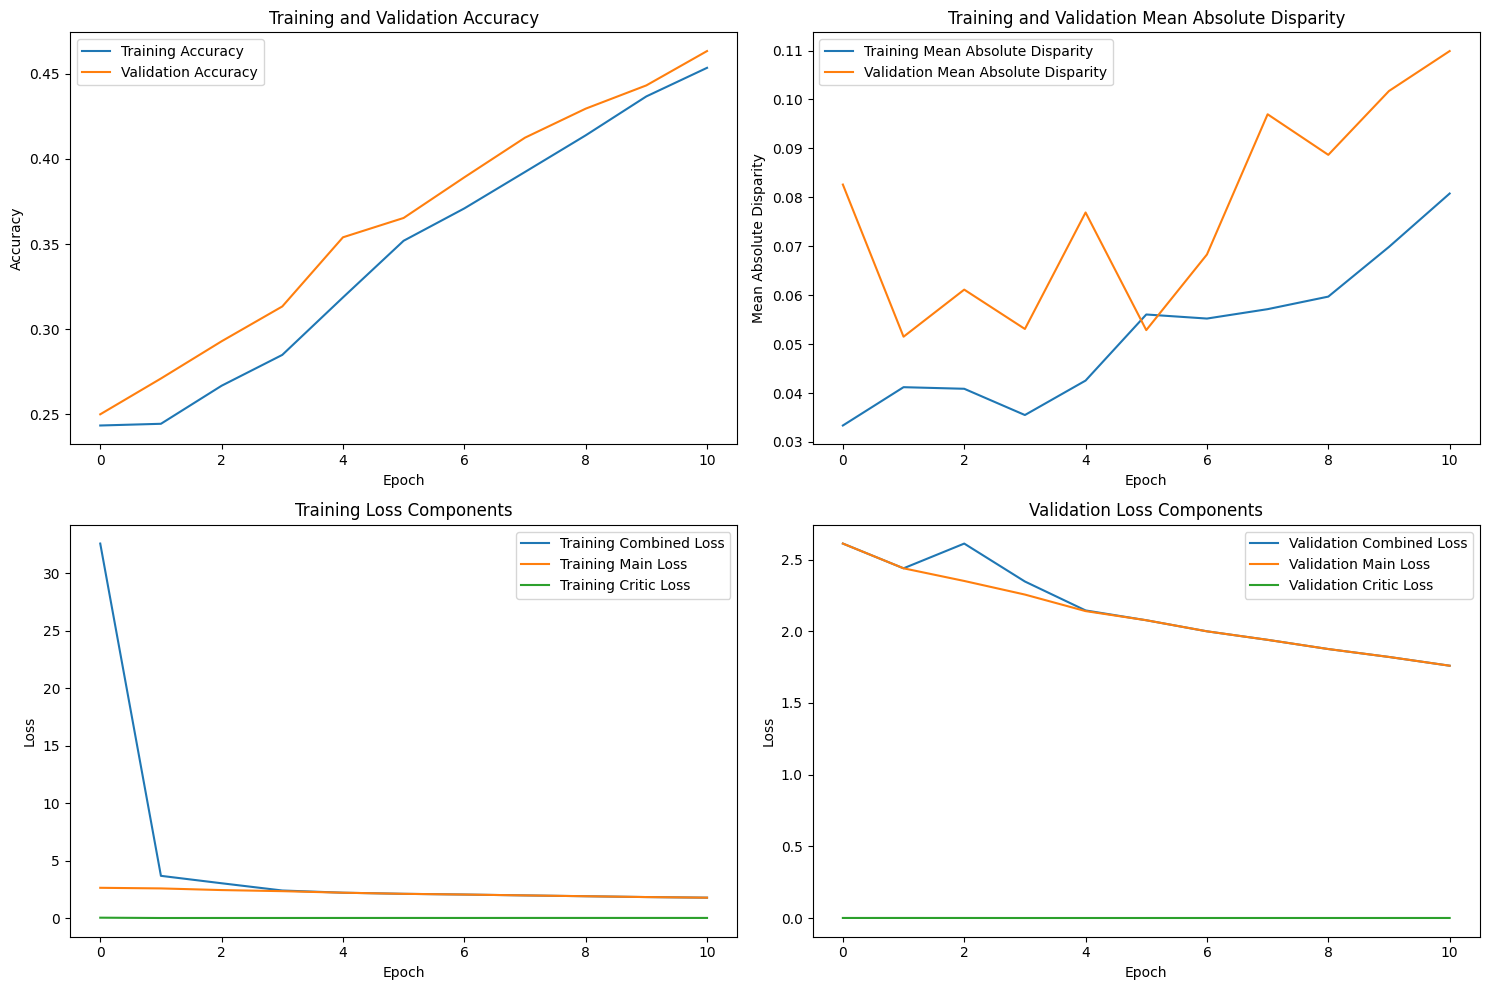

Epoch 12/200, Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.28it/s]



Lambda 150 - Epoch 12 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.474267, VALIDATION Accuracy: 0.4756
TRAINING Disparity: 0.091410, VALIDATION Disparity: 0.1029
TRAINING Combined Loss: 1.699428, VALIDATION Combined Loss: 1.7073
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.039517428111183306
Class Celebration: Val Disparity = -0.008564356435643572
Class Parade: Val Disparity = 0.07954545454545447
Class Waiter_Or_Waitress: Val Disparity = -0.23978617793050777
Class Individual_Sports: Val Disparity = -0.06729868913857673
Class Surgeons: Val Disparity = 0.04951958610495194
Class Spa: Val Disparity = -0.020833333333333332
Class Law_Enforcement: Val Disparity = 0.21901408450704224
Class Business: Val Disparity = 0.03268391355264555
Class Dresses: Val Disparity = -0.4261477045908184
Class Water_Activities: Val Disparity = 0.04673195656802198
Class Picnic: Val Disparity = -0.1568627450980392
Class Rescue: Val Dis

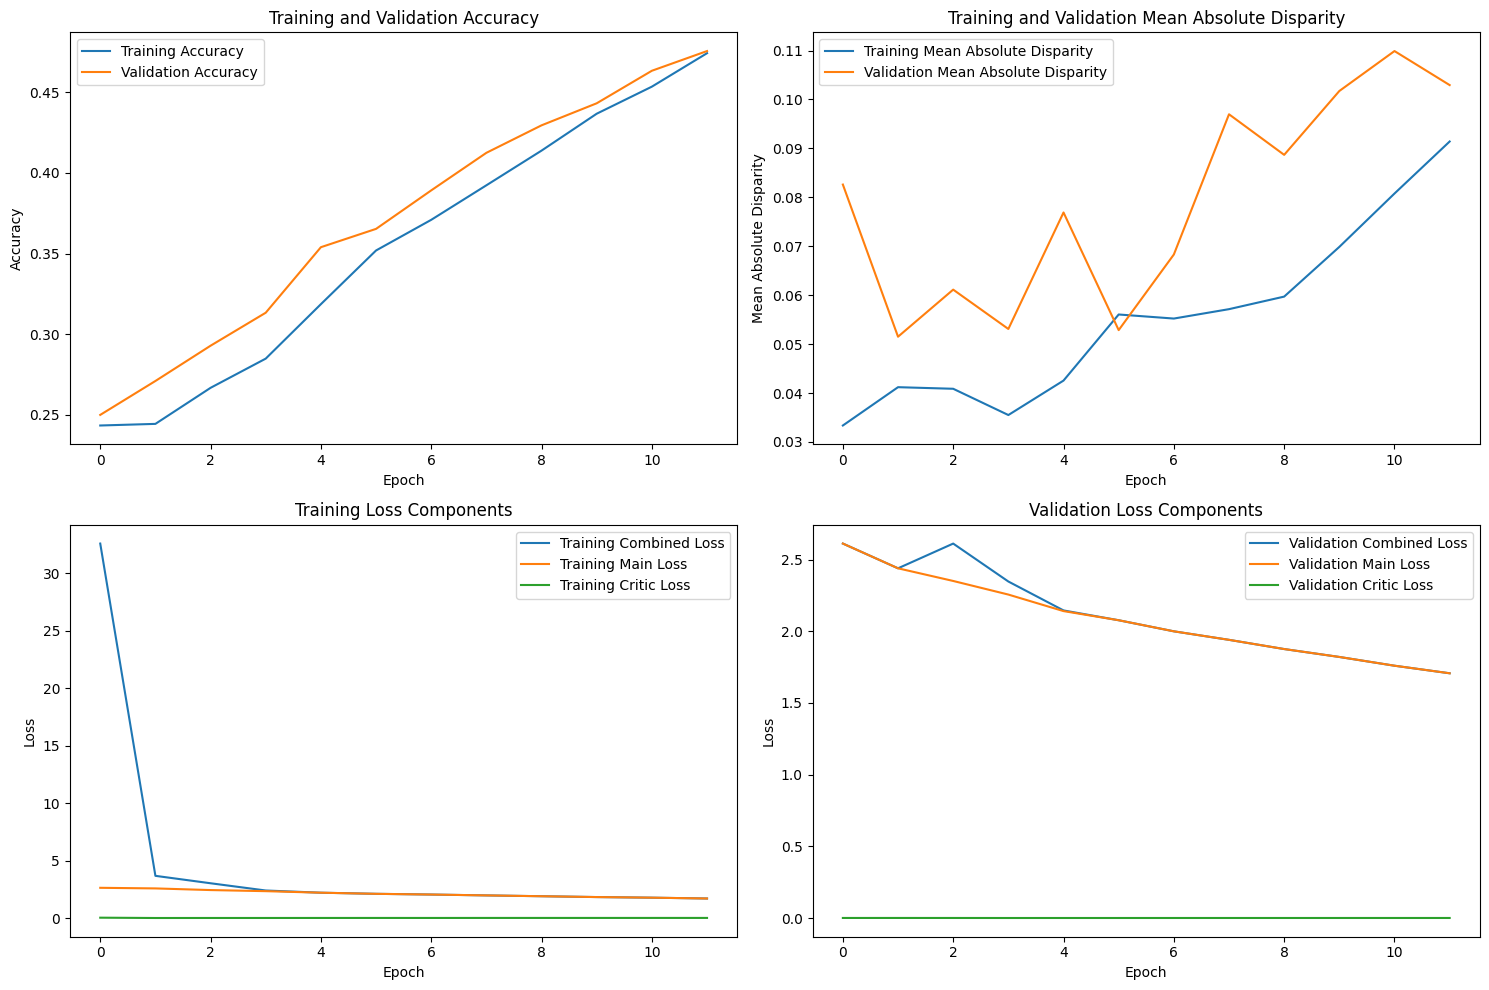

Epoch 13/200, Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:17<00:00,  3.22it/s]



Lambda 150 - Epoch 13 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.492110, VALIDATION Accuracy: 0.4895
TRAINING Disparity: 0.090211, VALIDATION Disparity: 0.1120
TRAINING Combined Loss: 1.641305, VALIDATION Combined Loss: 1.6562
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.04251065336852089
Class Celebration: Val Disparity = 0.011237623762376248
Class Parade: Val Disparity = 0.06818181818181834
Class Waiter_Or_Waitress: Val Disparity = -0.2646048109965635
Class Individual_Sports: Val Disparity = -0.09772940074906378
Class Surgeons: Val Disparity = 0.09238728750923872
Class Spa: Val Disparity = -0.06249999999999999
Class Law_Enforcement: Val Disparity = 0.26901408450704223
Class Business: Val Disparity = 0.012030235281592638
Class Dresses: Val Disparity = -0.3073852295409181
Class Water_Activities: Val Disparity = 0.027570789865871914
Class Picnic: Val Disparity = -0.2549019607843137
Class Rescue: Val Dispa

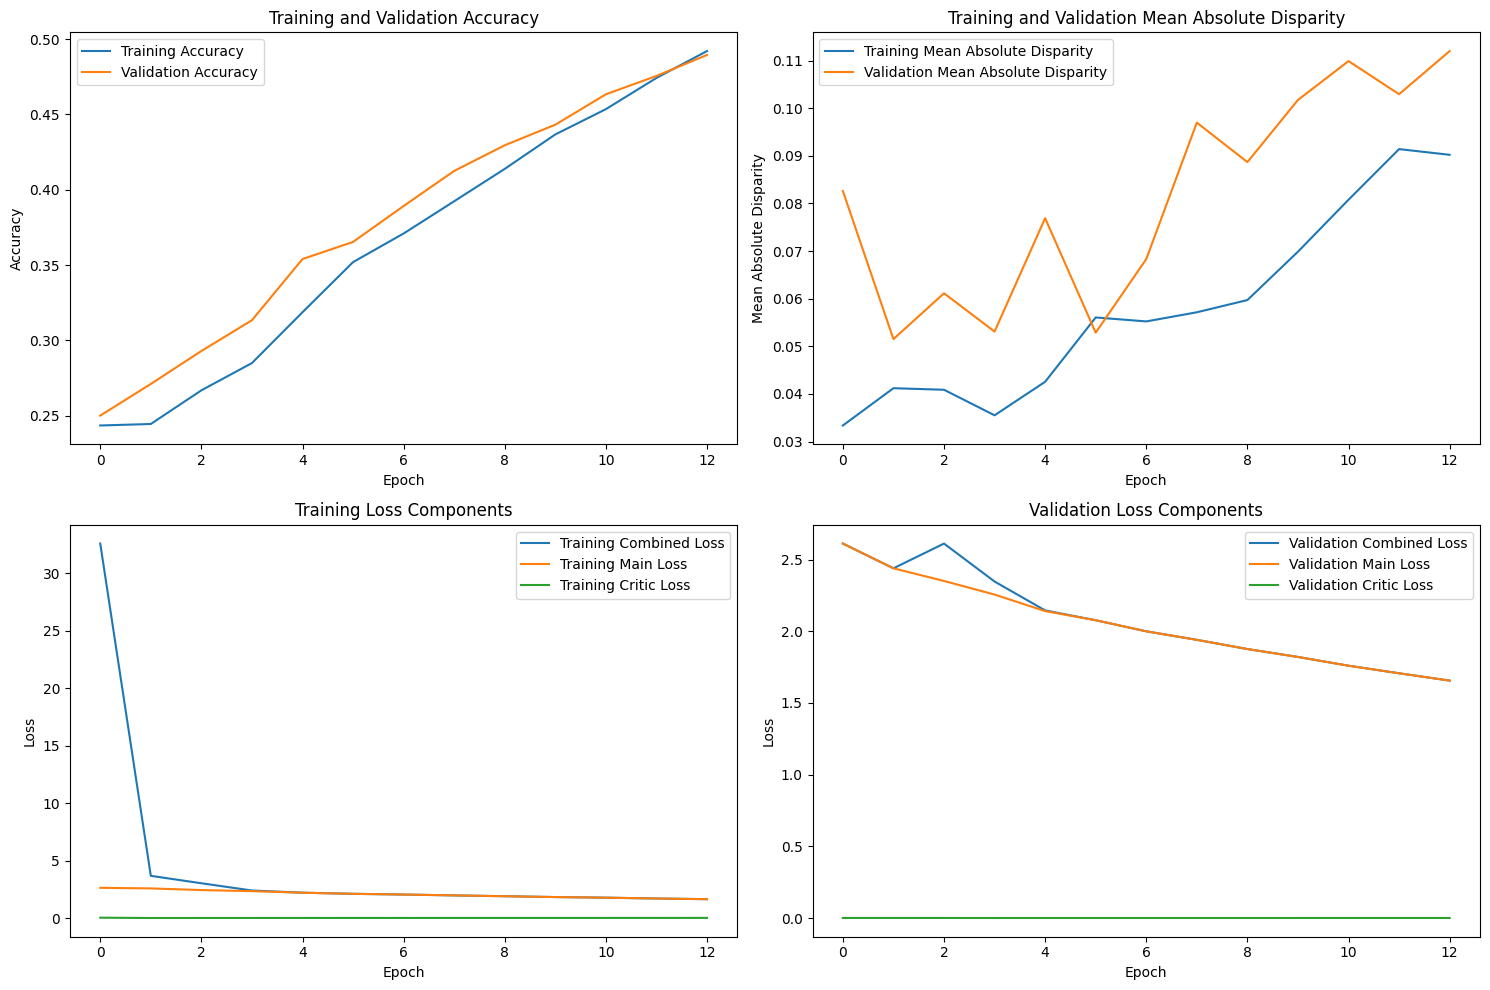

Epoch 14/200, Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.30it/s]



Lambda 150 - Epoch 14 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.511728, VALIDATION Accuracy: 0.5051
TRAINING Disparity: 0.094903, VALIDATION Disparity: 0.1088
TRAINING Combined Loss: 1.578063, VALIDATION Combined Loss: 1.6104
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.057373958940261205
Class Celebration: Val Disparity = -0.03336633663366334
Class Parade: Val Disparity = 0.0890151515151516
Class Waiter_Or_Waitress: Val Disparity = -0.24818633066055745
Class Individual_Sports: Val Disparity = -0.08996566791510618
Class Surgeons: Val Disparity = 0.03178122690317814
Class Spa: Val Disparity = -0.14583333333333331
Class Law_Enforcement: Val Disparity = 0.21455399061032865
Class Business: Val Disparity = -0.01288193335462573
Class Dresses: Val Disparity = -0.3253493013972057
Class Water_Activities: Val Disparity = 0.03576751117734722
Class Picnic: Val Disparity = -0.20261437908496732
Class Rescue: Val Disp

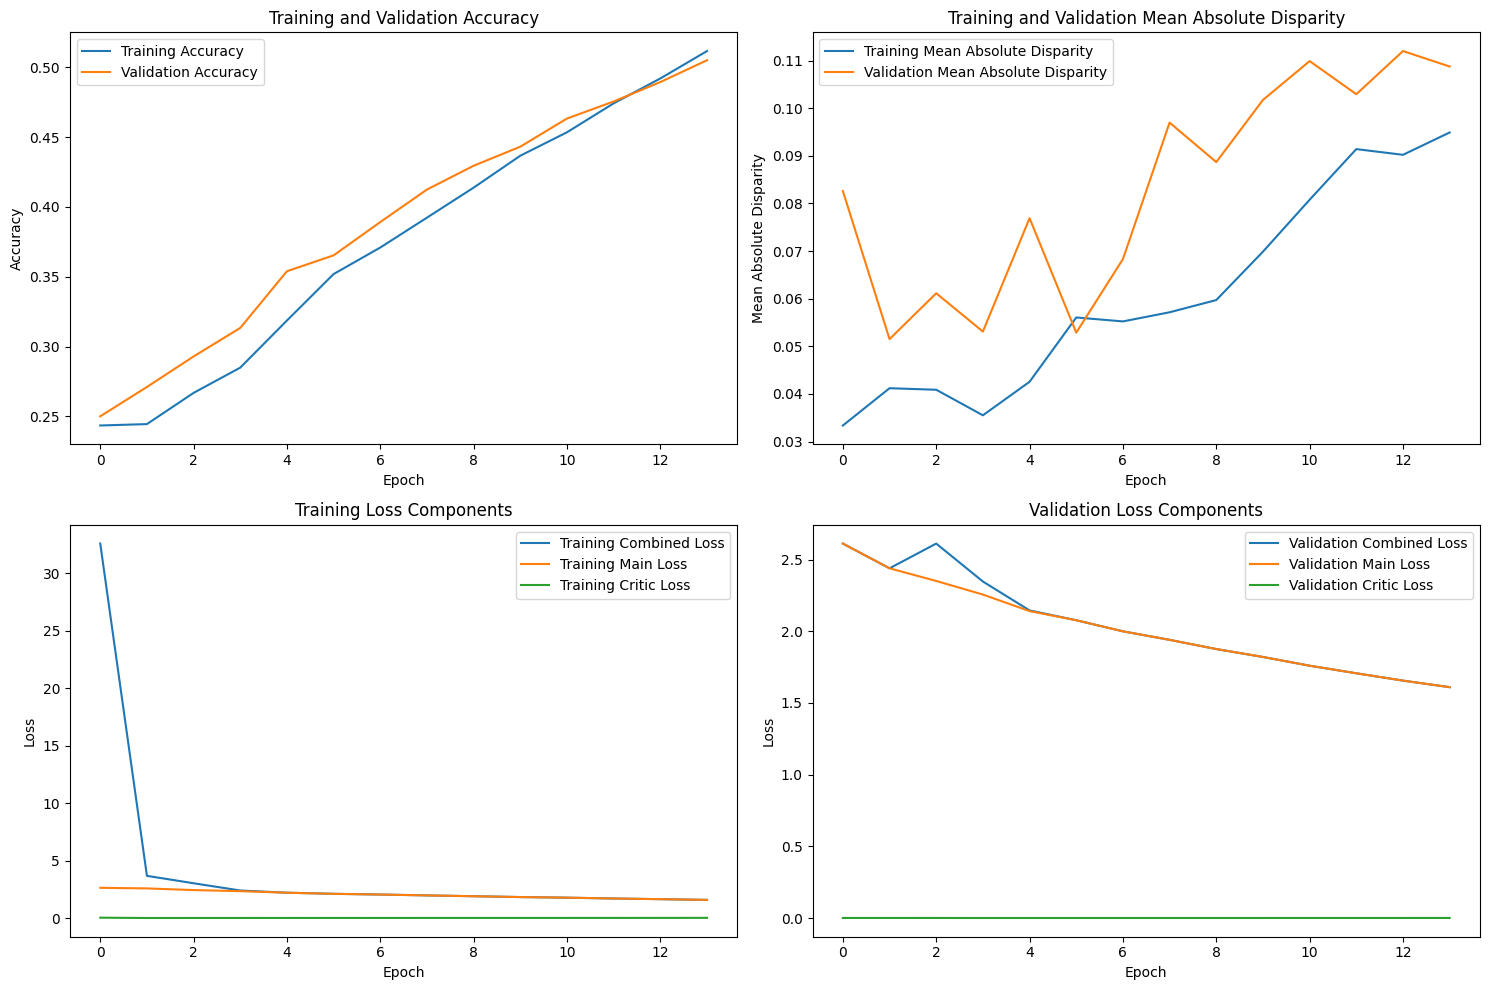

Epoch 15/200, Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.30it/s]



Lambda 150 - Epoch 15 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.526447, VALIDATION Accuracy: 0.5159
TRAINING Disparity: 0.107412, VALIDATION Disparity: 0.1150
TRAINING Combined Loss: 1.522461, VALIDATION Combined Loss: 1.5722
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.05368383772606289
Class Celebration: Val Disparity = 0.04094059405940598
Class Parade: Val Disparity = 0.07670454545454541
Class Waiter_Or_Waitress: Val Disparity = -0.19053073692248945
Class Individual_Sports: Val Disparity = -0.1081460674157304
Class Surgeons: Val Disparity = 0.03178122690317814
Class Spa: Val Disparity = -0.18749999999999997
Class Law_Enforcement: Val Disparity = 0.25680751173708927
Class Business: Val Disparity = 0.030980517406579366
Class Dresses: Val Disparity = -0.37924151696606806
Class Water_Activities: Val Disparity = 0.00979348520332124
Class Picnic: Val Disparity = -0.16993464052287582
Class Rescue: Val Dispa

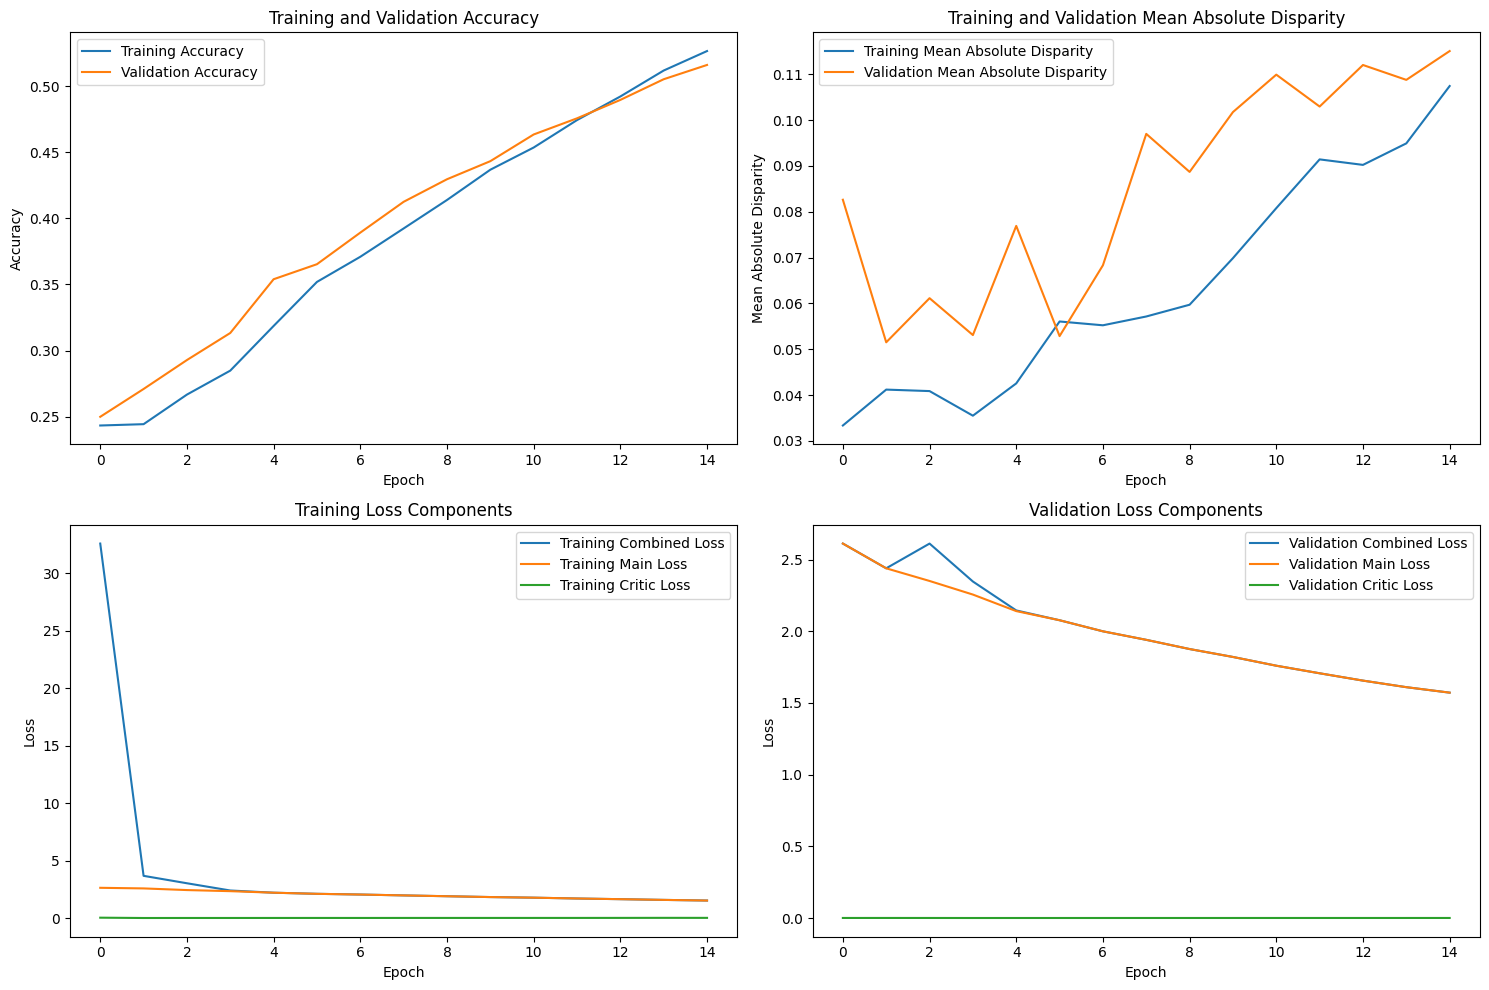

Epoch 16/200, Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.24it/s]



Lambda 150 - Epoch 16 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.548071, VALIDATION Accuracy: 0.5270
TRAINING Disparity: 0.110573, VALIDATION Disparity: 0.1158
TRAINING Combined Loss: 1.462279, VALIDATION Combined Loss: 1.5274
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.04171093669671322
Class Celebration: Val Disparity = -0.013861386138613818
Class Parade: Val Disparity = 0.09943181818181834
Class Waiter_Or_Waitress: Val Disparity = -0.274914089347079
Class Individual_Sports: Val Disparity = -0.13327091136079894
Class Surgeons: Val Disparity = 0.050258684405025844
Class Spa: Val Disparity = -0.20833333333333331
Class Law_Enforcement: Val Disparity = 0.1856807511737089
Class Business: Val Disparity = 0.008623442989460273
Class Dresses: Val Disparity = -0.3612774451097805
Class Water_Activities: Val Disparity = 0.07813497977432404
Class Picnic: Val Disparity = -0.13725490196078433
Class Rescue: Val Dispa

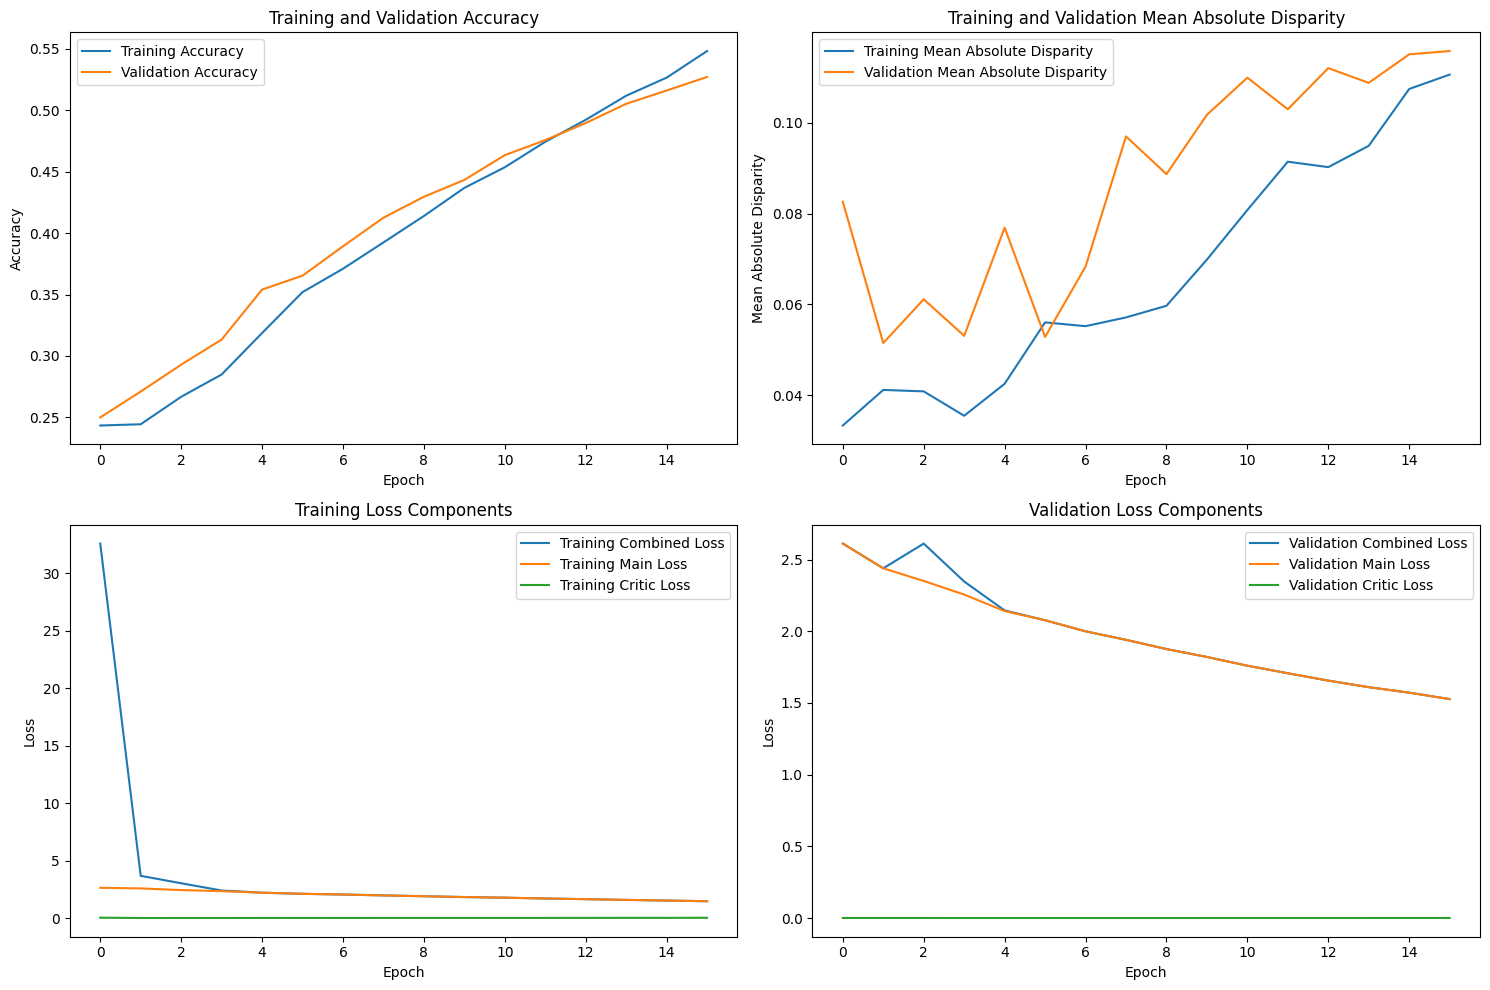

Epoch 17/200, Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.25it/s]



Lambda 150 - Epoch 17 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.569946, VALIDATION Accuracy: 0.5372
TRAINING Disparity: 0.116855, VALIDATION Disparity: 0.1187
TRAINING Combined Loss: 1.395330, VALIDATION Combined Loss: 1.4968
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.06146393849036347
Class Celebration: Val Disparity = -0.043762376237623746
Class Parade: Val Disparity = 0.0662878787878789
Class Waiter_Or_Waitress: Val Disparity = -0.17411225658648338
Class Individual_Sports: Val Disparity = -0.1246878901373284
Class Surgeons: Val Disparity = 0.019955654101995624
Class Spa: Val Disparity = -0.3333333333333333
Class Law_Enforcement: Val Disparity = 0.2075117370892019
Class Business: Val Disparity = -0.00298094325561582
Class Dresses: Val Disparity = -0.3972055888223553
Class Water_Activities: Val Disparity = 0.03438364913774761
Class Picnic: Val Disparity = -0.1764705882352942
Class Rescue: Val Dispari

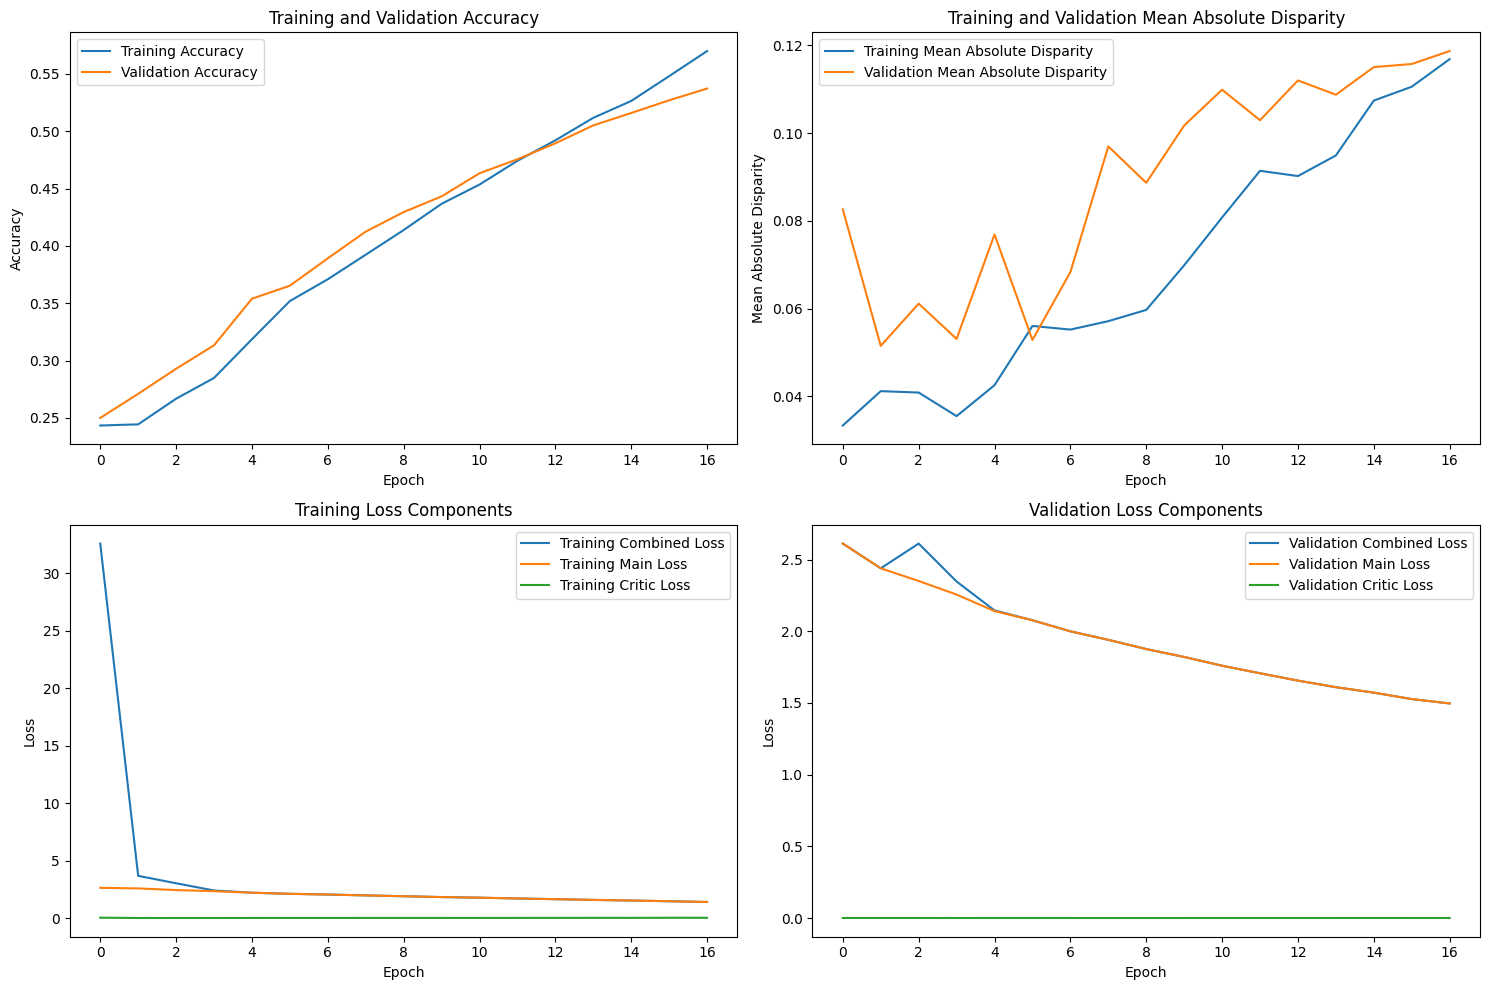

Epoch 18/200, Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.28it/s]



Lambda 150 - Epoch 18 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.586053, VALIDATION Accuracy: 0.5497
TRAINING Disparity: 0.111424, VALIDATION Disparity: 0.1215
TRAINING Combined Loss: 1.342049, VALIDATION Combined Loss: 1.4636
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.05752247775073971
Class Celebration: Val Disparity = 0.020445544554455464
Class Parade: Val Disparity = 0.11931818181818188
Class Waiter_Or_Waitress: Val Disparity = -0.1412752959144712
Class Individual_Sports: Val Disparity = -0.11774344569288397
Class Surgeons: Val Disparity = 0.014042867701404282
Class Spa: Val Disparity = -0.3333333333333333
Class Law_Enforcement: Val Disparity = 0.19976525821596242
Class Business: Val Disparity = 0.030980517406579422
Class Dresses: Val Disparity = -0.4331337325349302
Class Water_Activities: Val Disparity = 0.07334468809878658
Class Picnic: Val Disparity = -0.19607843137254916
Class Rescue: Val Dispa

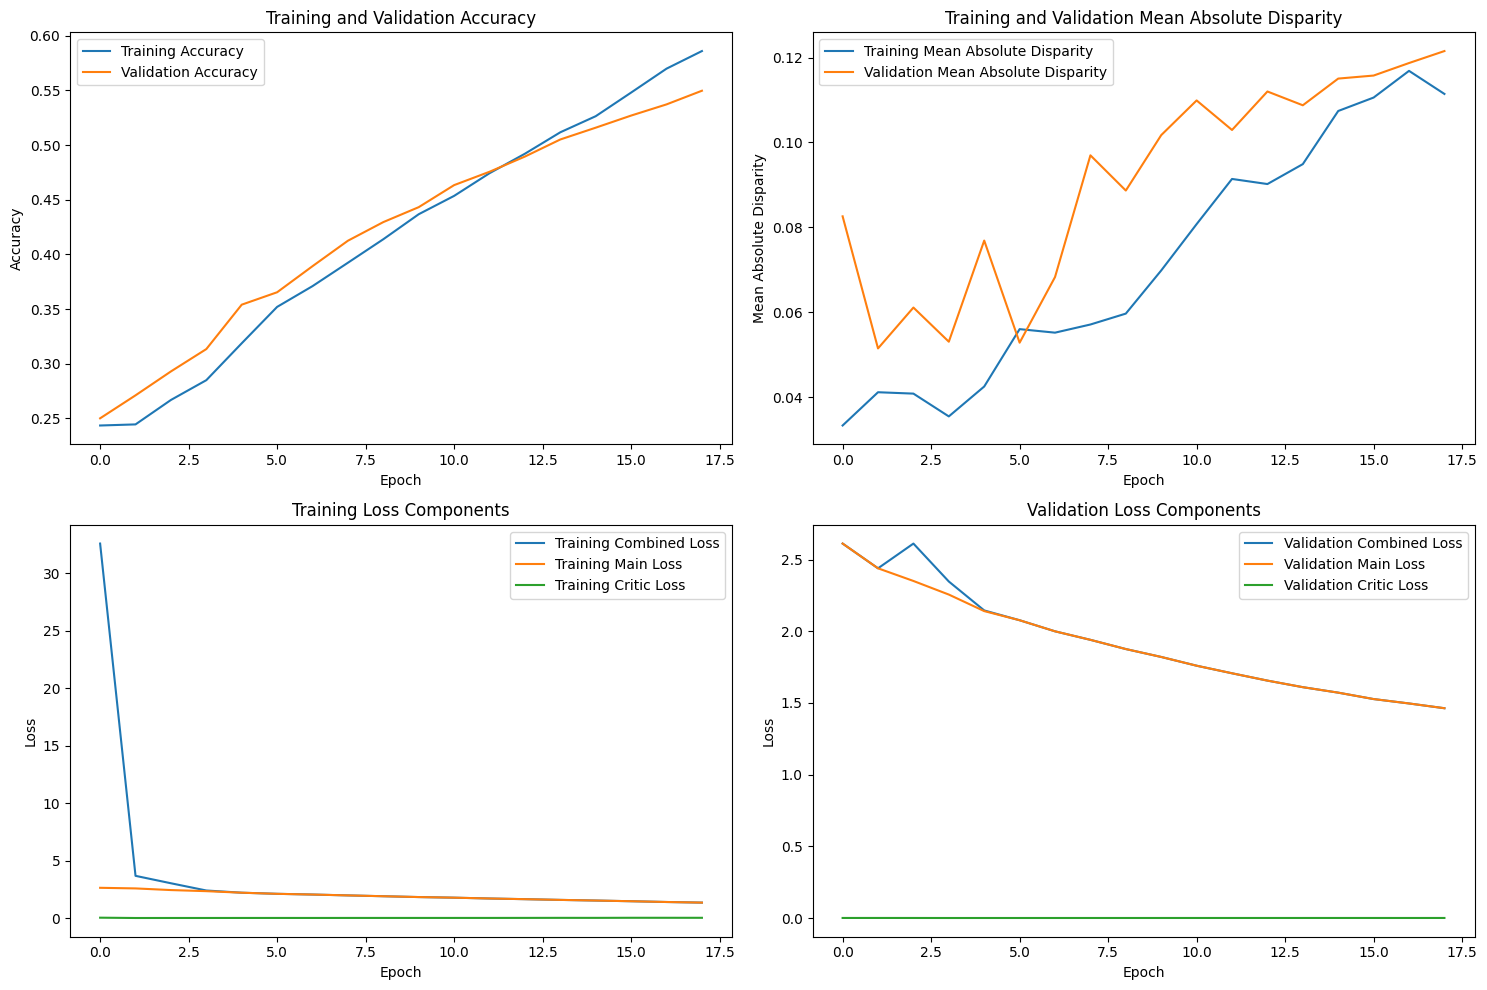

Epoch 19/200, Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.31it/s]



Lambda 150 - Epoch 19 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.603954, VALIDATION Accuracy: 0.5614
TRAINING Disparity: 0.124760, VALIDATION Disparity: 0.1475
TRAINING Combined Loss: 1.275496, VALIDATION Combined Loss: 1.4311
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.06186379682626719
Class Celebration: Val Disparity = 0.04074257425742572
Class Parade: Val Disparity = 0.04640151515151514
Class Waiter_Or_Waitress: Val Disparity = -0.21534936998854526
Class Individual_Sports: Val Disparity = -0.18024344569288397
Class Surgeons: Val Disparity = -0.046563192904656325
Class Spa: Val Disparity = -0.4583333333333333
Class Law_Enforcement: Val Disparity = 0.19201877934272293
Class Business: Val Disparity = -0.011178537208559547
Class Dresses: Val Disparity = -0.5578842315369262
Class Water_Activities: Val Disparity = 0.08835426868213758
Class Picnic: Val Disparity = -0.23529411764705882
Class Rescue: Val Dis

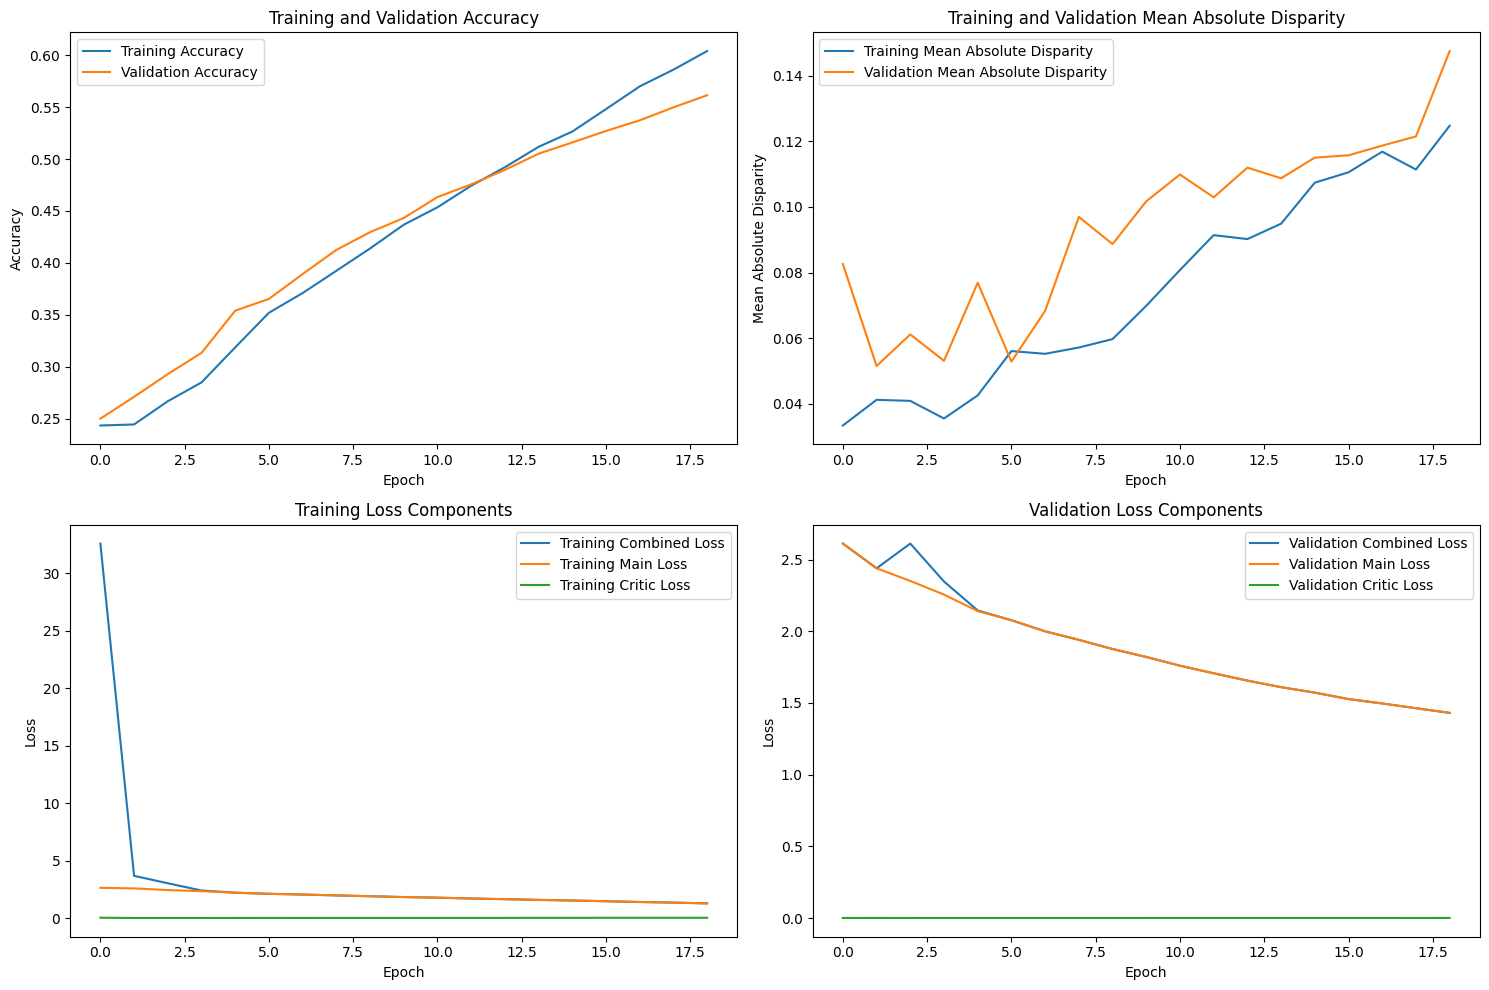

Epoch 20/200, Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.25it/s]



Lambda 150 - Epoch 20 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.622743, VALIDATION Accuracy: 0.5693
TRAINING Disparity: 0.136141, VALIDATION Disparity: 0.1455
TRAINING Combined Loss: 1.215305, VALIDATION Combined Loss: 1.4127
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.08600381579097693
Class Celebration: Val Disparity = 0.025247524752475214
Class Parade: Val Disparity = 0.08712121212121204
Class Waiter_Or_Waitress: Val Disparity = -0.12485681557846506
Class Individual_Sports: Val Disparity = -0.1334659800249688
Class Surgeons: Val Disparity = -0.11899482631189956
Class Spa: Val Disparity = -0.4583333333333333
Class Law_Enforcement: Val Disparity = 0.23755868544600933
Class Business: Val Disparity = -0.0038326413286490224
Class Dresses: Val Disparity = -0.5758483033932135
Class Water_Activities: Val Disparity = 0.05418352139663607
Class Picnic: Val Disparity = -0.1764705882352942
Class Rescue: Val Disp

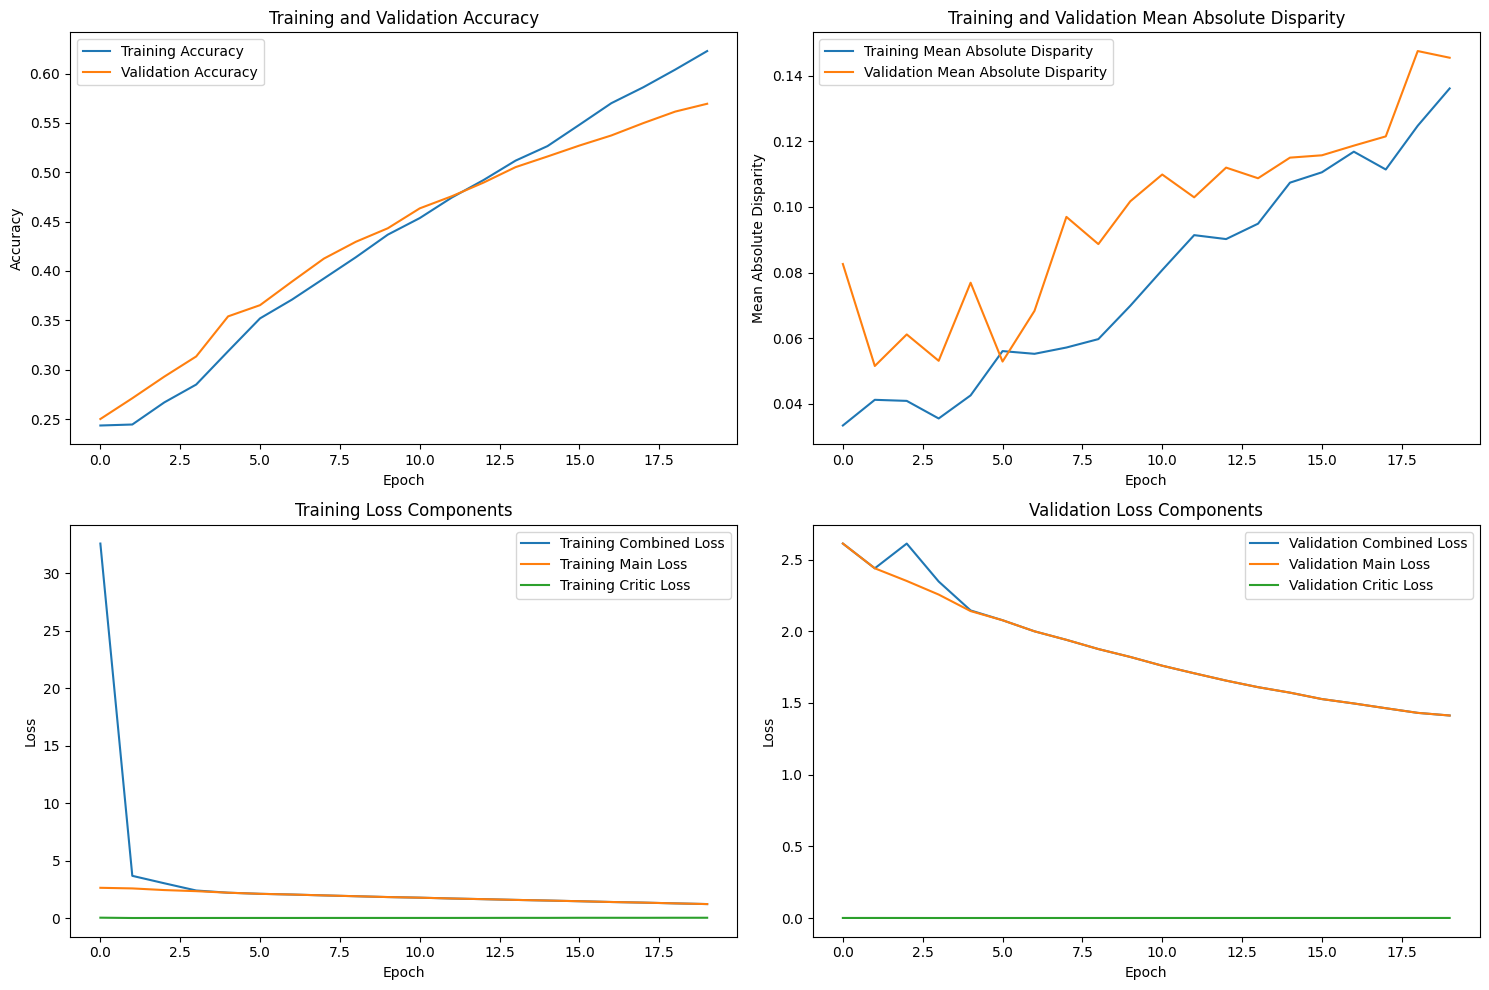

Epoch 21/200, Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.29it/s]



Lambda 150 - Epoch 21 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.644637, VALIDATION Accuracy: 0.5784
TRAINING Disparity: 0.115758, VALIDATION Disparity: 0.1516
TRAINING Combined Loss: 1.159084, VALIDATION Combined Loss: 1.3922
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.06924403925466394
Class Celebration: Val Disparity = 0.03524752475247528
Class Parade: Val Disparity = 0.08996212121212122
Class Waiter_Or_Waitress: Val Disparity = -0.06109201985490653
Class Individual_Sports: Val Disparity = -0.15082709113607995
Class Surgeons: Val Disparity = -0.015521064301552145
Class Spa: Val Disparity = -0.5833333333333333
Class Law_Enforcement: Val Disparity = 0.20938967136150233
Class Business: Val Disparity = -0.005536037474715205
Class Dresses: Val Disparity = -0.563872255489022
Class Water_Activities: Val Disparity = 0.021396636150734616
Class Picnic: Val Disparity = -0.30718954248366015
Class Rescue: Val Dis

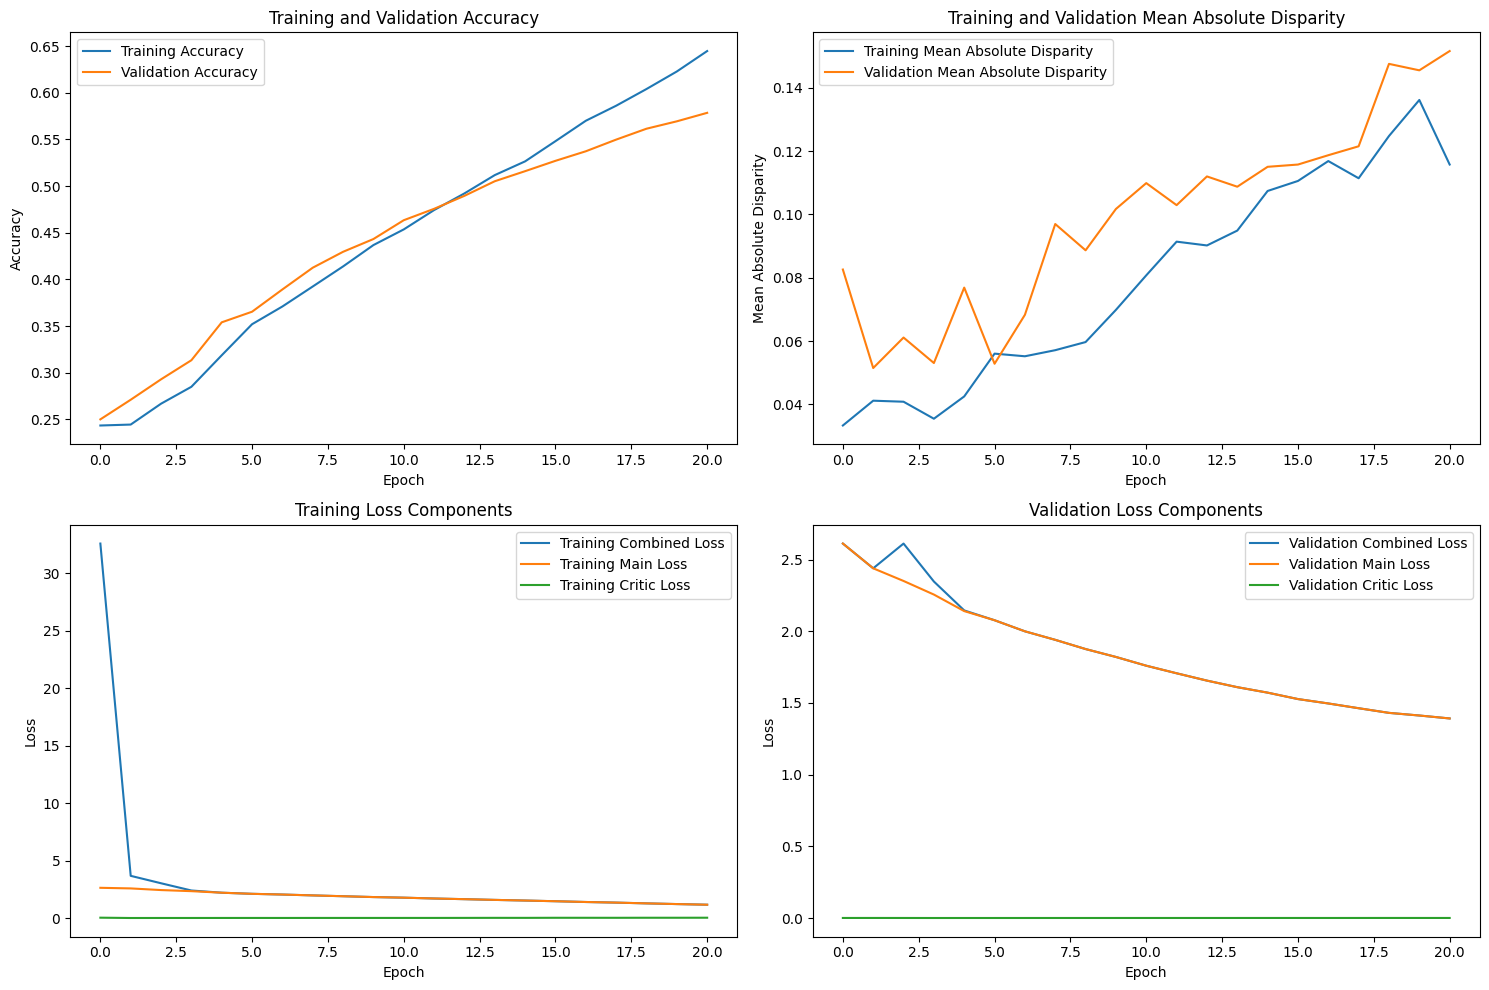

Epoch 22/200, Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.24it/s]



Lambda 150 - Epoch 22 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.668268, VALIDATION Accuracy: 0.5867
TRAINING Disparity: 0.110086, VALIDATION Disparity: 0.1488
TRAINING Combined Loss: 1.089119, VALIDATION Combined Loss: 1.3705
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.08286207172316096
Class Celebration: Val Disparity = 0.04534653465346533
Class Parade: Val Disparity = 0.05303030303030298
Class Waiter_Or_Waitress: Val Disparity = -0.07140129820542196
Class Individual_Sports: Val Disparity = -0.1232443820224719
Class Surgeons: Val Disparity = 0.014781966001478297
Class Spa: Val Disparity = -0.6874999999999999
Class Law_Enforcement: Val Disparity = 0.1586854460093896
Class Business: Val Disparity = 0.020227829234536365
Class Dresses: Val Disparity = -0.563872255489022
Class Water_Activities: Val Disparity = 0.02001277411113478
Class Picnic: Val Disparity = -0.23529411764705882
Class Rescue: Val Disparit

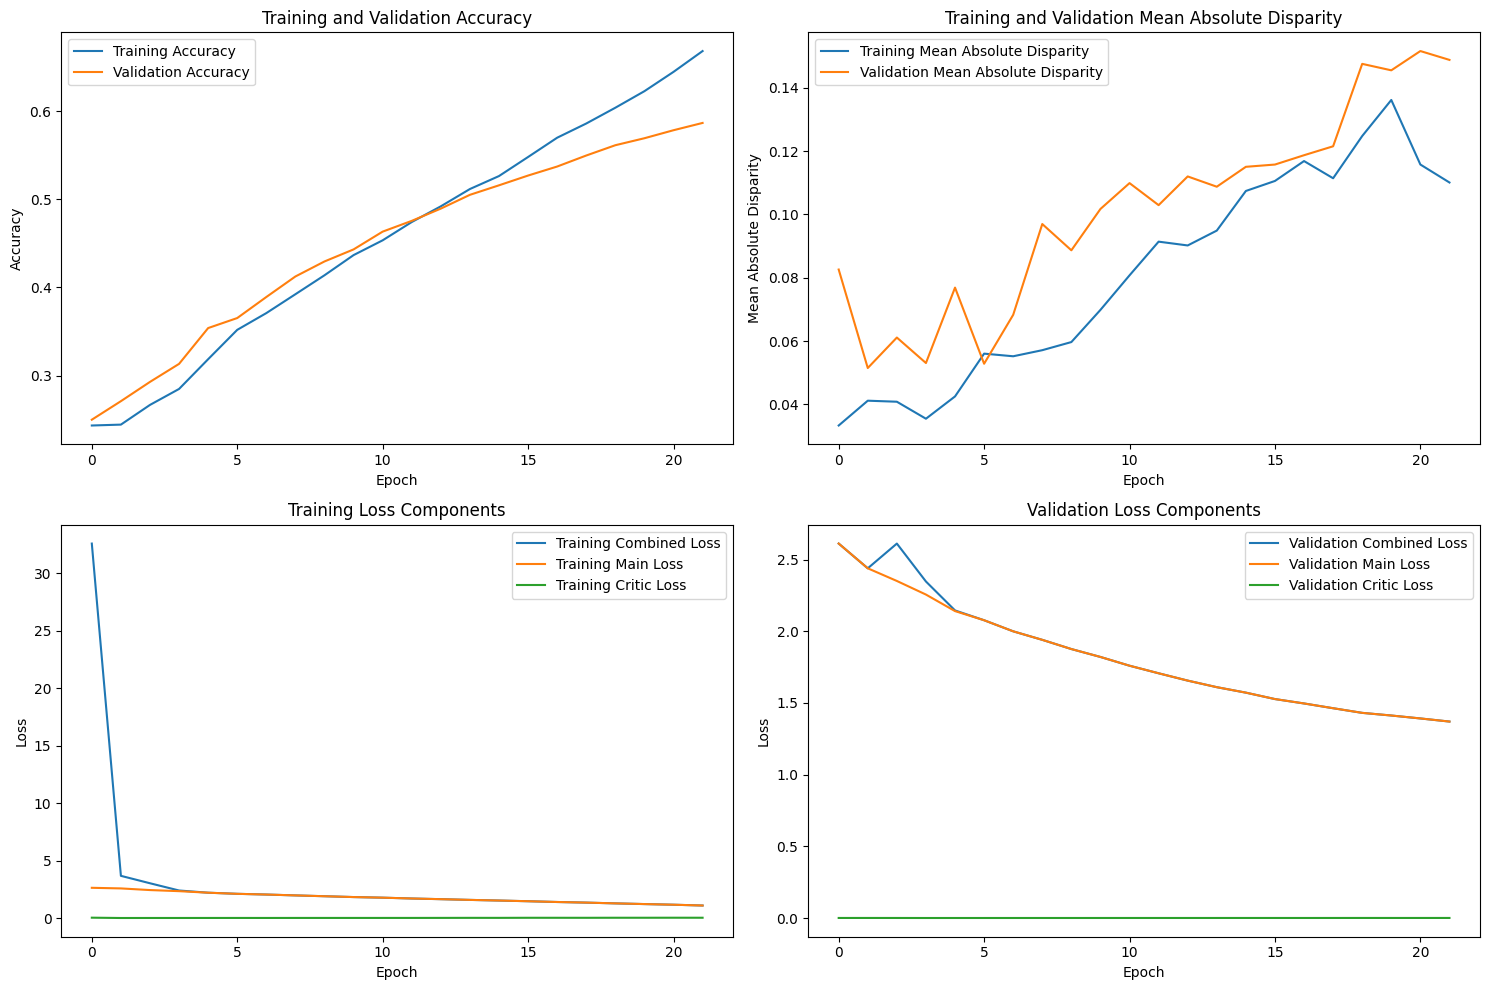

Epoch 23/200, Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:17<00:00,  3.06it/s]



Lambda 150 - Epoch 23 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.683931, VALIDATION Accuracy: 0.5898
TRAINING Disparity: 0.117078, VALIDATION Disparity: 0.1423
TRAINING Combined Loss: 1.027720, VALIDATION Combined Loss: 1.3696
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.07128902902971523
Class Celebration: Val Disparity = 0.025346534653465258
Class Parade: Val Disparity = 0.07859848484848486
Class Waiter_Or_Waitress: Val Disparity = -0.04467353951890052
Class Individual_Sports: Val Disparity = -0.09300873907615481
Class Surgeons: Val Disparity = 0.03917220990391734
Class Spa: Val Disparity = -0.625
Class Law_Enforcement: Val Disparity = 0.17981220657277008
Class Business: Val Disparity = 0.0366230171404236
Class Dresses: Val Disparity = -0.5459081836327346
Class Water_Activities: Val Disparity = 0.0411965084096233
Class Picnic: Val Disparity = -0.23529411764705882
Class Rescue: Val Disparity = 0.0096256

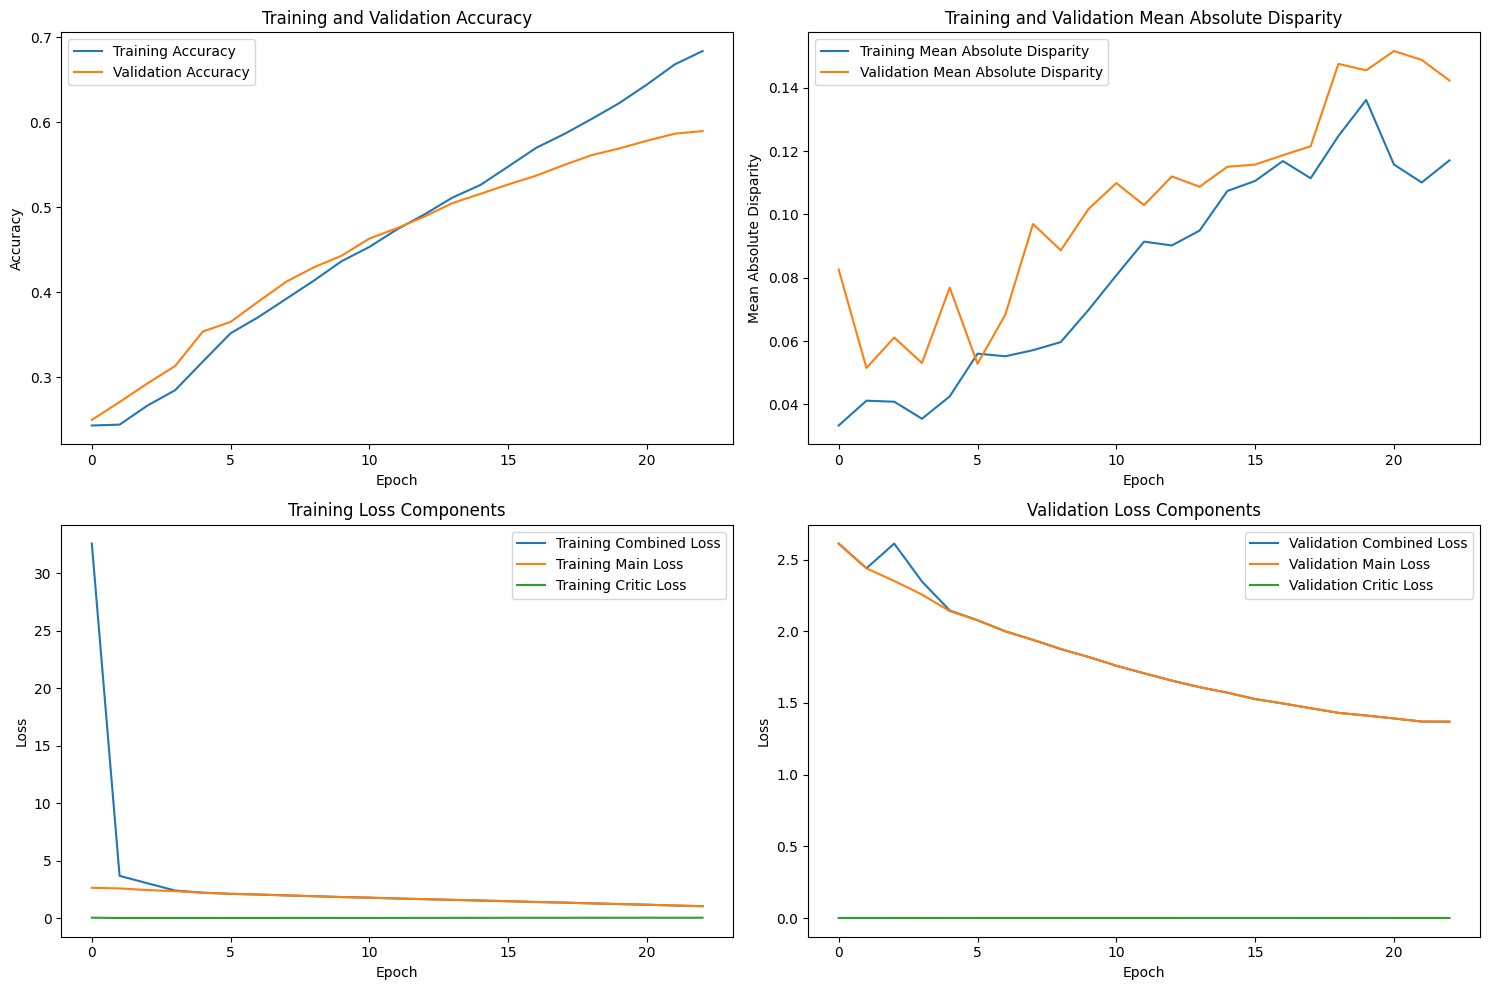

Epoch 24/200, Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.30it/s]



Lambda 150 - Epoch 24 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.707967, VALIDATION Accuracy: 0.5941
TRAINING Disparity: 0.115867, VALIDATION Disparity: 0.1413
TRAINING Combined Loss: 0.947877, VALIDATION Combined Loss: 1.3556
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.07074065188333267
Class Celebration: Val Disparity = -0.004455445544554459
Class Parade: Val Disparity = 0.09280303030303017
Class Waiter_Or_Waitress: Val Disparity = -0.06529209621993148
Class Individual_Sports: Val Disparity = -0.1120084269662921
Class Surgeons: Val Disparity = 0.04508499630450841
Class Spa: Val Disparity = -0.6249999999999999
Class Law_Enforcement: Val Disparity = 0.11643192488262932
Class Business: Val Disparity = 0.025018630895347505
Class Dresses: Val Disparity = -0.5698602794411178
Class Water_Activities: Val Disparity = 0.04321907600596131
Class Picnic: Val Disparity = -0.25490196078431376
Class Rescue: Val Dispa

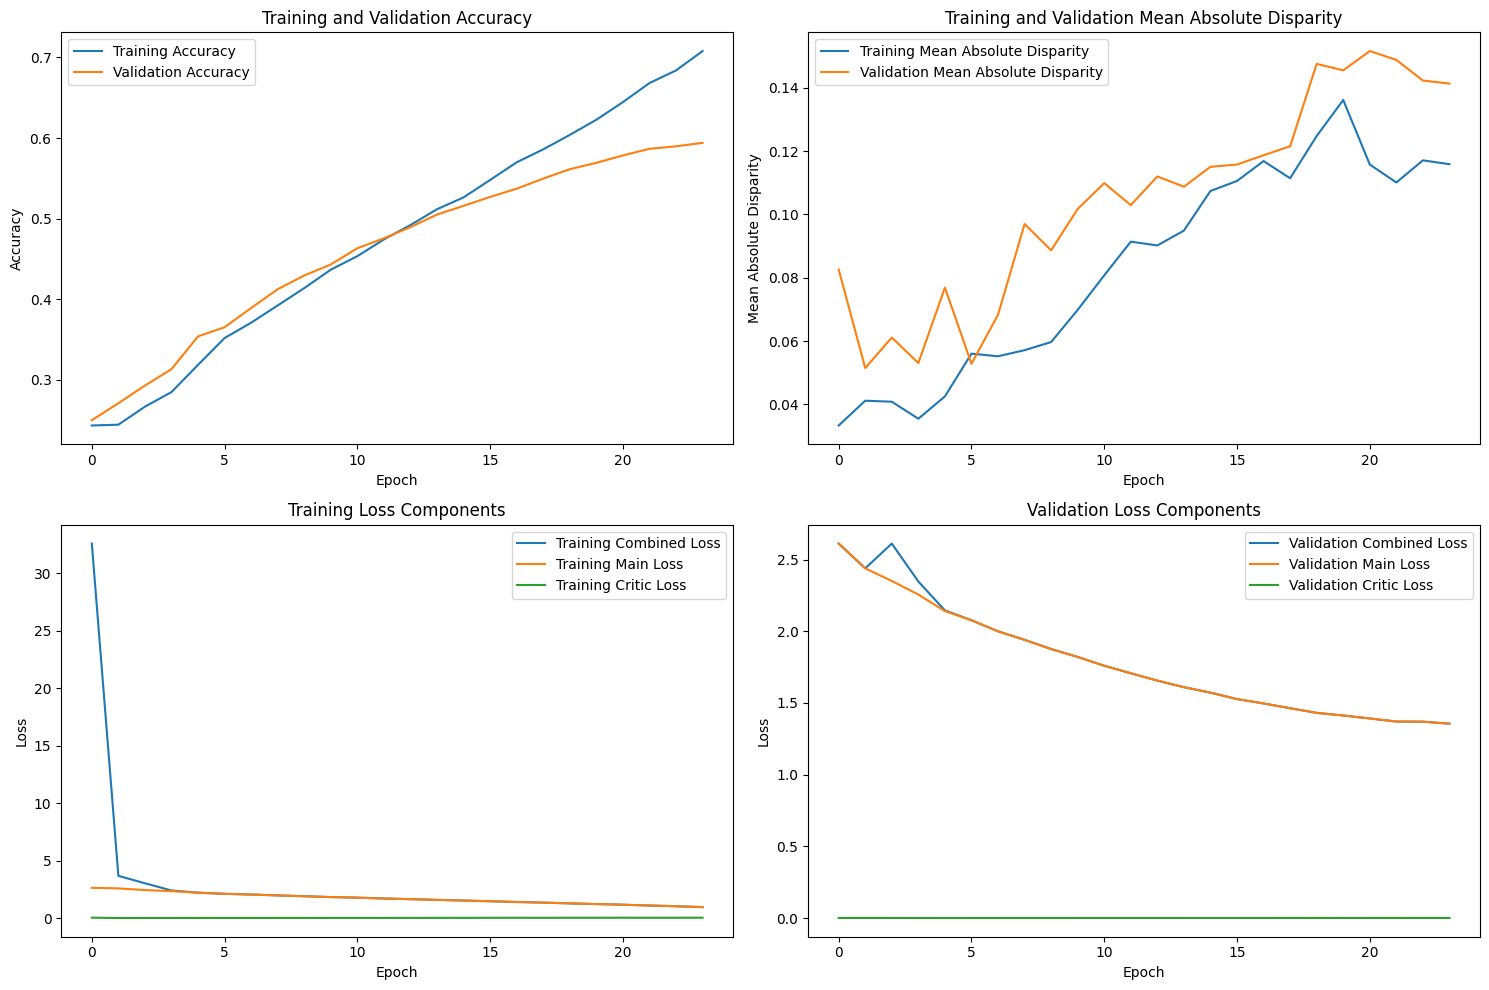

Epoch 25/200, Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.24it/s]



Lambda 150 - Epoch 25 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.729012, VALIDATION Accuracy: 0.6012
TRAINING Disparity: 0.104699, VALIDATION Disparity: 0.1449
TRAINING Combined Loss: 0.874573, VALIDATION Combined Loss: 1.3634
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.07074065188333267
Class Celebration: Val Disparity = -0.004455445544554459
Class Parade: Val Disparity = 0.09280303030303017
Class Waiter_Or_Waitress: Val Disparity = -0.06529209621993148
Class Individual_Sports: Val Disparity = -0.1120084269662921
Class Surgeons: Val Disparity = 0.04508499630450841
Class Spa: Val Disparity = -0.6249999999999999
Class Law_Enforcement: Val Disparity = 0.11643192488262932
Class Business: Val Disparity = 0.025018630895347505
Class Dresses: Val Disparity = -0.5698602794411178
Class Water_Activities: Val Disparity = 0.04321907600596131
Class Picnic: Val Disparity = -0.25490196078431376
Class Rescue: Val Dispa

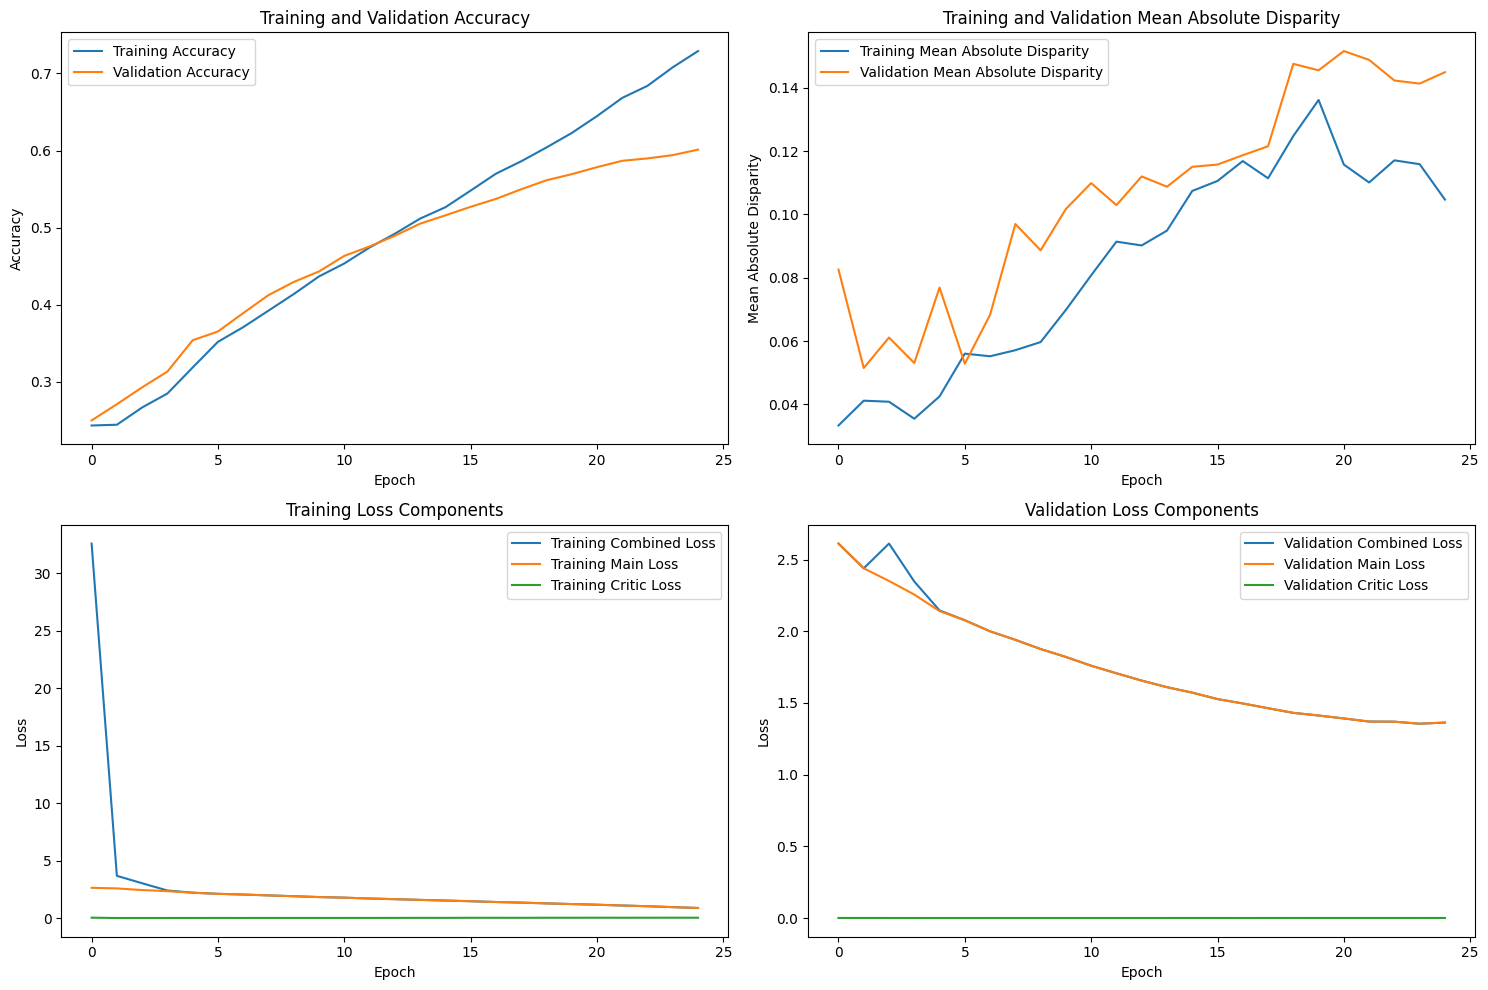

Epoch 26/200, Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.26it/s]



Lambda 150 - Epoch 26 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.759819, VALIDATION Accuracy: 0.5989
TRAINING Disparity: 0.128908, VALIDATION Disparity: 0.1686
TRAINING Combined Loss: 0.792553, VALIDATION Combined Loss: 1.3674
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.07074065188333267
Class Celebration: Val Disparity = -0.004455445544554459
Class Parade: Val Disparity = 0.09280303030303017
Class Waiter_Or_Waitress: Val Disparity = -0.06529209621993148
Class Individual_Sports: Val Disparity = -0.1120084269662921
Class Surgeons: Val Disparity = 0.04508499630450841
Class Spa: Val Disparity = -0.6249999999999999
Class Law_Enforcement: Val Disparity = 0.11643192488262932
Class Business: Val Disparity = 0.025018630895347505
Class Dresses: Val Disparity = -0.5698602794411178
Class Water_Activities: Val Disparity = 0.04321907600596131
Class Picnic: Val Disparity = -0.25490196078431376
Class Rescue: Val Dispa

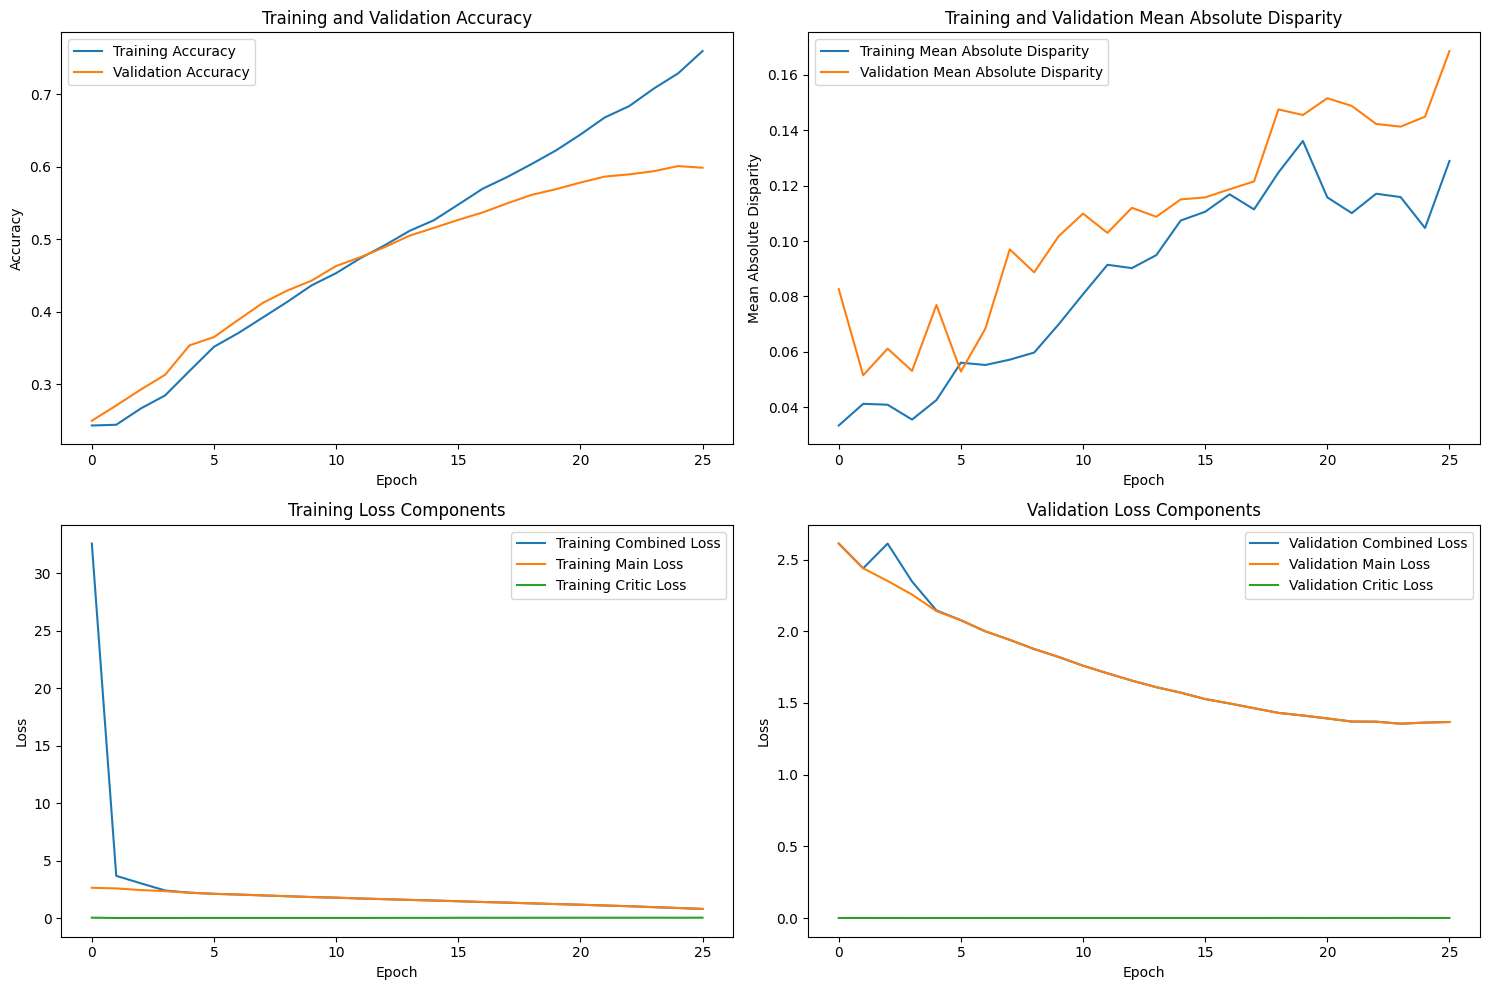

Epoch 27/200, Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.31it/s]



Lambda 150 - Epoch 27 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.778819, VALIDATION Accuracy: 0.5924
TRAINING Disparity: 0.105642, VALIDATION Disparity: 0.1637
TRAINING Combined Loss: 0.712996, VALIDATION Combined Loss: 1.4245
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.07074065188333267
Class Celebration: Val Disparity = -0.004455445544554459
Class Parade: Val Disparity = 0.09280303030303017
Class Waiter_Or_Waitress: Val Disparity = -0.06529209621993148
Class Individual_Sports: Val Disparity = -0.1120084269662921
Class Surgeons: Val Disparity = 0.04508499630450841
Class Spa: Val Disparity = -0.6249999999999999
Class Law_Enforcement: Val Disparity = 0.11643192488262932
Class Business: Val Disparity = 0.025018630895347505
Class Dresses: Val Disparity = -0.5698602794411178
Class Water_Activities: Val Disparity = 0.04321907600596131
Class Picnic: Val Disparity = -0.25490196078431376
Class Rescue: Val Dispa

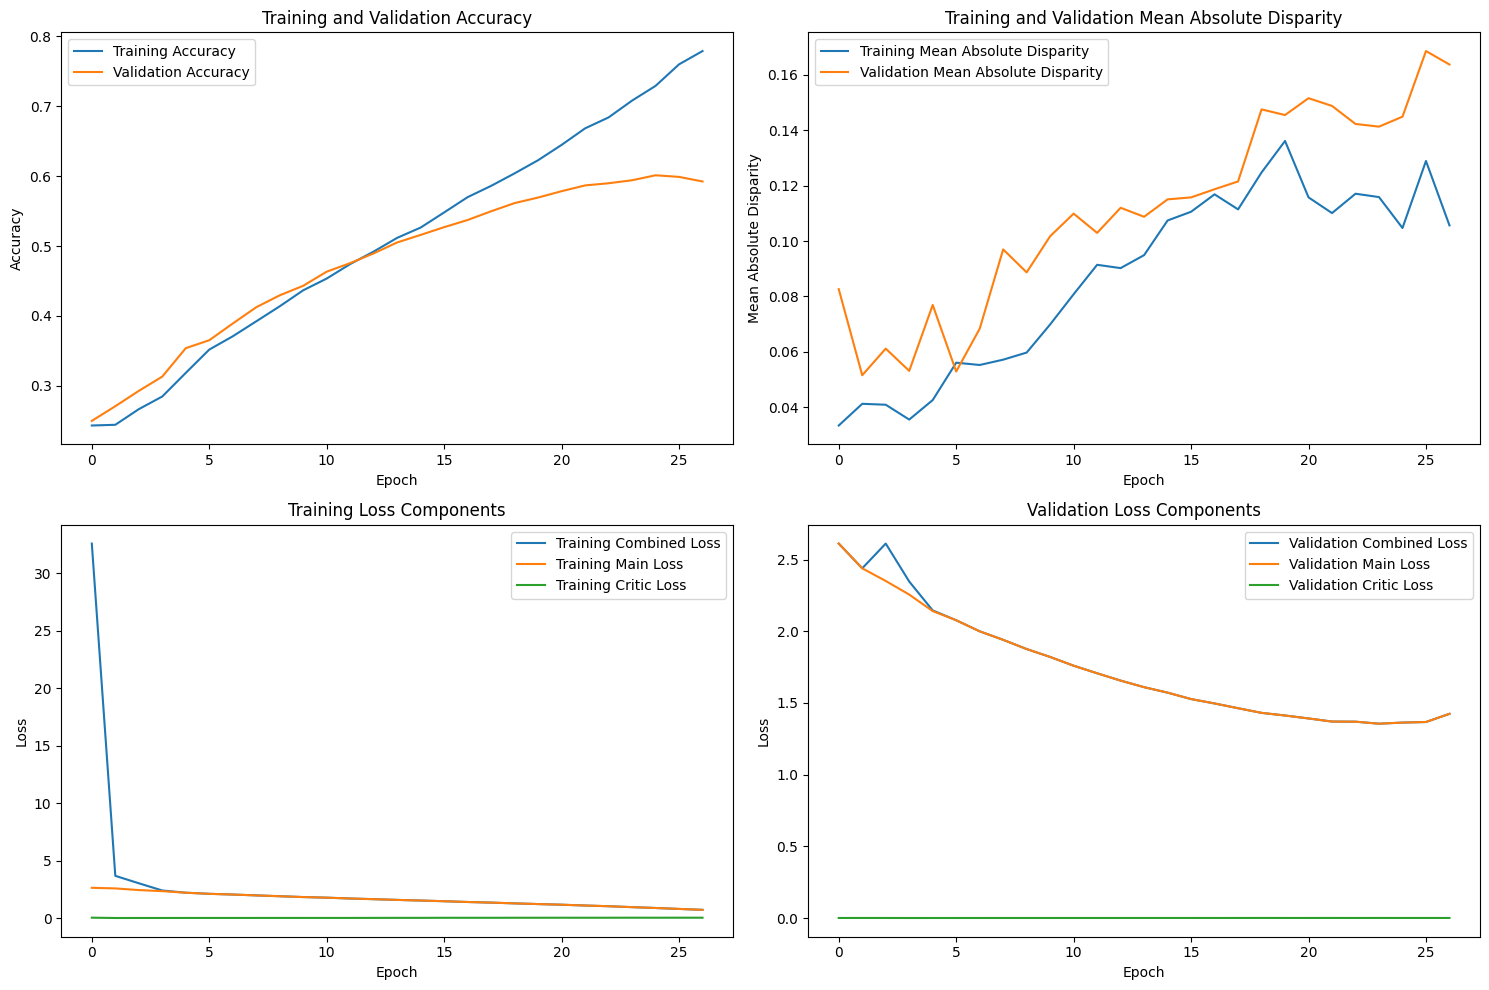

Epoch 28/200, Training:  46%|█████████████████████████████████████████▏                                               | 75/162 [00:42<00:48,  1.81it/s]

In [ ]:
# Create dict to store best model states
all_best_model_states = {}
base_save_dir = "Test_Dir2"

# Loop through the lambda_factor_list
for lambda_factor in lambda_factor_list:
    # Load EfficientNet B0 model
    actor = models.efficientnet_b0(pretrained=True)
    
    # Determine the number of output features from the feature extractor part of EfficientNet B0
    num_ftrs = actor.classifier[1].in_features  # This is the correct number of input features for your adversarial classifier
    
    # Modify the classifier layer of the EfficientNet model to match your number of classes
    actor.classifier[1] = nn.Linear(num_ftrs, num_classes)
    
    # Move the EfficientNet model to the GPU
    actor = actor.to(device)

    # Initialize the Critic model
    critic = Critic(input_size=16).to(device)  # Adjust the input size based on your model's output
    critic_optimizer = optim.Adam(critic.parameters(), lr=learning_rate)
    critic_loss_fn = torch.nn.MSELoss()
    
    # Redefine your main model optimizer if needed
    actor_optimizer = optim.Adam(actor.parameters(), lr=learning_rate)
    actor_loss_fn = nn.CrossEntropyLoss()

    # Train the model
    best_model_state = train_model(actor, actor_optimizer, actor_loss_fn, critic, critic_optimizer, critic_loss_fn,
                                   lambda_factor, epsilon, margin, patience, epochs, device, base_save_dir=base_save_dir)
    all_best_model_states[lambda_factor] = best_model_state

# Save the collective best model states to a file
collective_save_path = os.path.join(base_save_dir, 'all_best_model_states.pth')
torch.save(all_best_model_states, collective_save_path)


In [ ]:
# load models
collective_save_path = os.path.join(base_save_dir, 'all_best_model_states.pth')

# Load the saved model states
all_best_model_states = torch.load(collective_save_path)

# Example: Accessing the best_val_accuracy for a specific lambda value
lambda_value = 50
    if lambda_value in all_best_model_states:
        best_model_state = all_best_model_states[lambda_value]
        best_val_accuracy = best_model_state['best_val_accuracy']
        print(f"Best validation accuracy for lambda {lambda_value}: {best_val_accuracy}")
    else:
        print(f"No model state found for lambda {lambda_value}")

In [ ]:
# add plots